In [1]:
import numpy as np
import pandas as pd
import os
import openpyxl
import tensorflow as tf
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow.keras.layers import LSTM,Dense,GRU,Dropout,SimpleRNN
from sklearn.metrics import mean_squared_error
# from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [2]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
import random as rn
seed_num =42
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)

In [5]:
n_hours = 3
n_features = 43
'''
train_num_24 = 2789
train_num_25 = 2892
train_num_19 = 1934
'''
train_num_24 = 2788
train_num_25 = 2891
train_num_19 = 1933
train_num_26= 3052

In [6]:
# from google.colab import drive
filename = 'j_rain_data.xlsx'

df = pd.read_excel(filename)
df.head

<bound method NDFrame.head of       홍수사상번호     연  월   일  시간  데이터집단 1  Unnamed: 6  Unnamed: 7  Unnamed: 8  \
0          1  2006  7  10   8   6.4000           7           7           7   
1          1  2006  7  10   9   6.3000           7           8           7   
2          1  2006  7  10  10   6.4000           7           9           7   
3          1  2006  7  10  11   7.3000           7          10           7   
4          1  2006  7  10  12   8.2000           7          12           8   
...      ...   ... ..  ..  ..      ...         ...         ...         ...   
3046      26  2018  7   7  17   2.3689           1           0           0   
3047      26  2018  7   7  18   2.3689           1           0           0   
3048      26  2018  7   7  19   2.3689           1           0           0   
3049      26  2018  7   7  20   2.3689           1           0           0   
3050      26  2018  7   7  21   2.3689           1           0           0   

      Unnamed: 9  ...  Unnamed: 3

# min max scaler

In [7]:
# df_metrix 만드는 과정
df_matrix = df.to_numpy()


df_matrix = df_matrix.astype('float32')
df_matrix = df_matrix[:,5:]

scaler = MinMaxScaler(feature_range=(0, 1))
df_matrix = scaler.fit_transform(df_matrix)
print(df_matrix)


# print(df_matrix.shape)
df_matrix1 = df_matrix[0:train_num_25, :] # 주 numpy
# df_matrix2 = df_matrix[train_num_24-4:train_num_25,5:] 
y = df_matrix[n_hours:train_num_25,42:43]
ans = df_matrix[train_num_24:train_num_25,5:6]

print(y.shape)
print(y)
print(df_matrix[0,0])

[[0.01948843 0.0212766  0.01907357 ... 0.09392971 0.15531301 0.0086303 ]
 [0.01918392 0.0212766  0.02179836 ... 0.09329073 0.15491581 0.00992569]
 [0.01948843 0.0212766  0.02452316 ... 0.09329073 0.1545186  0.01152899]
 ...
 [0.00721346 0.00303951 0.         ... 0.1316294  0.44806337        nan]
 [0.00721346 0.00303951 0.         ... 0.13035144 0.44846106        nan]
 [0.00721346 0.00303951 0.         ... 0.12971246 0.44885826        nan]]
(2888, 1)
[[0.01391903]
 [0.01773149]
 [0.02367161]
 ...
 [0.022716  ]
 [0.02221129]
 [0.0217162 ]]
0.01948843


In [8]:
# print(df_matrix)
lag = series_to_supervised(df_matrix1, n_hours,1)

# print(lag)
print(lag.shape[1])
# for i in range(215,258):
#     lag.drop(lag.columns[[i]], axis = 1, inplace = True)


lag = lag.values

tmp = lag.shape[1]

lag = lag[:,0:tmp-1]
print(lag.shape)
lag


172
(2888, 171)


array([[0.01948843, 0.0212766 , 0.01907357, ..., 0.05363984, 0.09329073,
        0.15431976],
       [0.01918392, 0.0212766 , 0.02179836, ..., 0.06130268, 0.09329073,
        0.15392256],
       [0.01948843, 0.0212766 , 0.02452316, ..., 0.0651341 , 0.09329073,
        0.15352583],
       ...,
       [0.11118423, 0.03039514, 0.        , ..., 0.00383142, 0.12204473,
        0.73306847],
       [0.06937759, 0.01823708, 0.        , ..., 0.00383142, 0.12076677,
        0.7334657 ],
       [0.02514799, 0.00607903, 0.        , ..., 0.00383142, 0.11948882,
        0.73406124]], dtype=float32)

In [9]:
# n_train_hours = train_num_19
train_X = lag
train_X
# test_X = lag[n_train_hours:, :]
# train_y = y[:n_train_hours, :]
# test_y = y[n_train_hours:, :]

array([[0.01948843, 0.0212766 , 0.01907357, ..., 0.05363984, 0.09329073,
        0.15431976],
       [0.01918392, 0.0212766 , 0.02179836, ..., 0.06130268, 0.09329073,
        0.15392256],
       [0.01948843, 0.0212766 , 0.02452316, ..., 0.0651341 , 0.09329073,
        0.15352583],
       ...,
       [0.11118423, 0.03039514, 0.        , ..., 0.00383142, 0.12204473,
        0.73306847],
       [0.06937759, 0.01823708, 0.        , ..., 0.00383142, 0.12076677,
        0.7334657 ],
       [0.02514799, 0.00607903, 0.        , ..., 0.00383142, 0.11948882,
        0.73406124]], dtype=float32)

In [10]:
n_obs = n_hours * (n_features)
# train_X, train_y = train[:, :n_obs], train[:, -130]
print('train_X: ',train_X)
# print('train_y: ',train_y)
# test_X, test_y = test[:, :n_obs], test[:, -130]
#print('test_y: ',test_y)
# print(train_X.shape, len(train_X), test_X.shape)
garo = train_X.shape[1]
print(garo)
# reshape input to be 3D [samples, timesteps, features]
print(train_X.shape,y.shape)
train_X = train_X.reshape((train_X.shape[0],1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0],1, test_X.shape[1]))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X:  [[0.01948843 0.0212766  0.01907357 ... 0.05363984 0.09329073 0.15431976]
 [0.01918392 0.0212766  0.02179836 ... 0.06130268 0.09329073 0.15392256]
 [0.01948843 0.0212766  0.02452316 ... 0.0651341  0.09329073 0.15352583]
 ...
 [0.11118423 0.03039514 0.         ... 0.00383142 0.12204473 0.73306847]
 [0.06937759 0.01823708 0.         ... 0.00383142 0.12076677 0.7334657 ]
 [0.02514799 0.00607903 0.         ... 0.00383142 0.11948882 0.73406124]]
171
(2888, 171) (2888, 1)


In [11]:
#print('test_y: ',test_y)

Text(0, 0.5, 'AMOUNT')

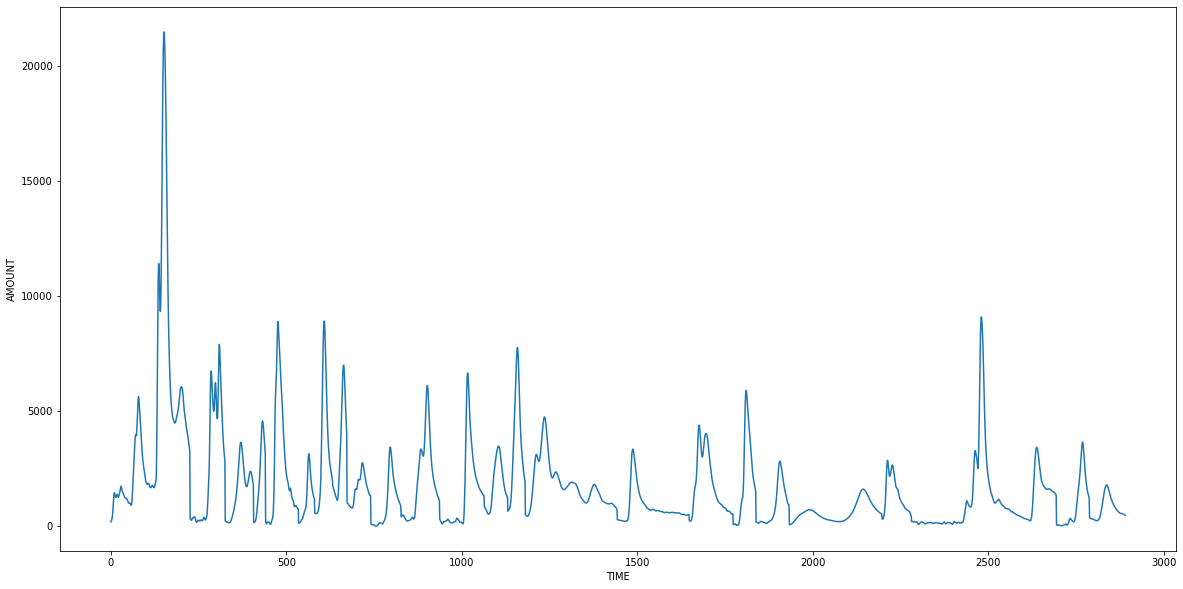

In [12]:
# print(df_matrix[train_num_25-1][42])
plt.figure(figsize=(20, 10))
# sns.lineplot(y=df_scaled['유입량'], x=df['일자'])
# plt.xlabel('TIME')
# plt.ylabel('AMOUNT')
plt.plot(df['유입량'])
plt.xlabel('TIME')
plt.ylabel('AMOUNT')

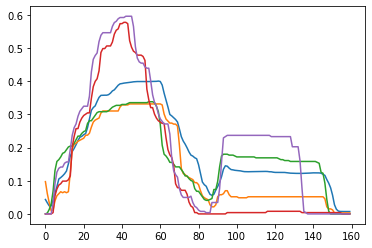

In [13]:
one = df_matrix[train_num_25:train_num_26,0]
two = df_matrix[train_num_25:train_num_26,1]
three = df_matrix[train_num_25:train_num_26,2]
four = df_matrix[train_num_25:train_num_26,3]
five = df_matrix[train_num_25:train_num_26,4]

plt.plot(one)
plt.plot(two)
plt.plot(three)
plt.plot(four)
plt.plot(five)
# plt.plot(real)
plt.show()

In [14]:
# import os
# from keras import optimizers

print(train_num_25,train_num_26)
for i in range(train_num_25,train_num_26-1):
  print(i)
  model = Sequential()
  model.add(LSTM(20, input_shape=(train_X.shape[1],train_X.shape[2]), activation='tanh', return_sequences=False))
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(lr=0.0001)

  model.compile(loss='mean_squared_error', optimizer='adam')
#early_stop = EarlyStopping(monitor='val_loss', patience=3)
#model_path = 'model'
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

  history = model.fit(train_X, y, 
                                    epochs=200, 
                                    batch_size=32,
                                    # validation_data=(test_X, test_y), 
                                    )

  
  tmp = df_matrix[i-3:i+1,:]
  tmp=tmp.reshape(1,172)
  
  # print(tmp.shape)
  tmp = tmp[:,:-1]
  # print(tmp)
  tmp = tmp.reshape((tmp.shape[0],1,tmp.shape[1]))
  # print(tmp)
  ans = model.predict(tmp)
  df_matrix[i][42]=ans
  # print(ans)
  y = np.concatenate((y,ans),axis =0) #정답 붙이기


  # print(train_X.shape,tmp.shape)
  train_X = np.concatenate((train_X,tmp),axis =0)
  # print(train_X)
  # print(y)



2891 3052
2891


2021-09-15 02:44:09.000978: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-09-15 02:44:09.012931: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa98929b410 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-15 02:44:09.012945: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Epoch 1/200
91/91 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 2/200
91/91 [==============================] - 0s 2ms/step - loss: 9.0169e-04
Epoch 3/200
91/91 [==============================] - 0s 2ms/step - loss: 5.0367e-04
Epoch 4/200
91/91 [==============================] - 0s 2ms/step - loss: 3.7315e-04
Epoch 5/200
91/91 [==============================] - 0s 2ms/step - loss: 3.0406e-04
Epoch 6/200
91/91 [==============================] - 0s 2ms/step - loss: 3.3477e-04
Epoch 7/200
91/91 [==============================] - 0s 2ms/step - loss: 2.9727e-04
Epoch 8/200
91/91 [==============================] - 0s 2ms/step - loss: 2.0142e-04
Epoch 9/200
91/91 [==============================] - 0s 2ms/step - loss: 2.4293e-04
Epoch 10/200
91/91 [==============================] - 0s 2ms/step - loss: 2.1330e-04
Epoch 11/200
91/91 [==============================] - 0s 2ms/step - loss: 1.7048e-04
Epoch 12/200
91/91 [==============================] - 0s 2ms/step - loss: 1.79

91/91 [==============================] - 0s 1ms/step - loss: 5.2788e-05
Epoch 98/200
91/91 [==============================] - 0s 1ms/step - loss: 7.2732e-05
Epoch 99/200
91/91 [==============================] - 0s 1ms/step - loss: 5.5062e-05
Epoch 100/200
91/91 [==============================] - 0s 1ms/step - loss: 6.1714e-05
Epoch 101/200
91/91 [==============================] - 0s 1ms/step - loss: 4.5632e-05
Epoch 102/200
91/91 [==============================] - 0s 1ms/step - loss: 3.9752e-05
Epoch 103/200
91/91 [==============================] - 0s 1ms/step - loss: 5.1173e-05
Epoch 104/200
91/91 [==============================] - 0s 1ms/step - loss: 5.0314e-05
Epoch 105/200
91/91 [==============================] - 0s 1ms/step - loss: 4.6222e-05
Epoch 106/200
91/91 [==============================] - 0s 1ms/step - loss: 6.9806e-05
Epoch 107/200
91/91 [==============================] - 0s 1ms/step - loss: 4.8090e-05
Epoch 108/200
91/91 [==============================] - 0s 1ms/step - l

91/91 [==============================] - 0s 2ms/step - loss: 4.1532e-05
Epoch 193/200
91/91 [==============================] - 0s 2ms/step - loss: 4.3734e-05
Epoch 194/200
91/91 [==============================] - 0s 2ms/step - loss: 2.6789e-05
Epoch 195/200
91/91 [==============================] - 0s 1ms/step - loss: 2.5485e-05
Epoch 196/200
91/91 [==============================] - 0s 1ms/step - loss: 4.7028e-05
Epoch 197/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6088e-05
Epoch 198/200
91/91 [==============================] - 0s 1ms/step - loss: 2.4474e-05
Epoch 199/200
91/91 [==============================] - 0s 1ms/step - loss: 3.5627e-05
Epoch 200/200
91/91 [==============================] - 0s 1ms/step - loss: 4.4016e-05
2892
Epoch 1/200
91/91 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 2/200
91/91 [==============================] - 0s 2ms/step - loss: 8.6399e-04
Epoch 3/200
91/91 [==============================] - 0s 1ms/step - loss

91/91 [==============================] - 0s 1ms/step - loss: 6.5440e-05
Epoch 89/200
91/91 [==============================] - 0s 1ms/step - loss: 4.3348e-05
Epoch 90/200
91/91 [==============================] - 0s 1ms/step - loss: 5.7592e-05
Epoch 91/200
91/91 [==============================] - 0s 1ms/step - loss: 5.0768e-05
Epoch 92/200
91/91 [==============================] - 0s 1ms/step - loss: 7.1088e-05
Epoch 93/200
91/91 [==============================] - 0s 1ms/step - loss: 5.3374e-05
Epoch 94/200
91/91 [==============================] - 0s 1ms/step - loss: 6.1561e-05
Epoch 95/200
91/91 [==============================] - 0s 1ms/step - loss: 4.5584e-05
Epoch 96/200
91/91 [==============================] - 0s 1ms/step - loss: 6.3293e-05
Epoch 97/200
91/91 [==============================] - 0s 1ms/step - loss: 5.2387e-05
Epoch 98/200
91/91 [==============================] - 0s 1ms/step - loss: 6.6477e-05
Epoch 99/200
91/91 [==============================] - 0s 1ms/step - loss: 4.44

91/91 [==============================] - 0s 1ms/step - loss: 4.2570e-05
Epoch 184/200
91/91 [==============================] - 0s 1ms/step - loss: 2.3346e-05
Epoch 185/200
91/91 [==============================] - 0s 1ms/step - loss: 2.5544e-05
Epoch 186/200
91/91 [==============================] - 0s 1ms/step - loss: 2.7582e-05
Epoch 187/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6833e-05
Epoch 188/200
91/91 [==============================] - 0s 1ms/step - loss: 2.7422e-05
Epoch 189/200
91/91 [==============================] - 0s 1ms/step - loss: 2.7088e-05
Epoch 190/200
91/91 [==============================] - 0s 1ms/step - loss: 2.5440e-05
Epoch 191/200
91/91 [==============================] - 0s 2ms/step - loss: 2.5426e-05
Epoch 192/200
91/91 [==============================] - 0s 1ms/step - loss: 2.3074e-05
Epoch 193/200
91/91 [==============================] - 0s 1ms/step - loss: 3.2978e-05
Epoch 194/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 1ms/step - loss: 8.5929e-05
Epoch 80/200
91/91 [==============================] - 0s 1ms/step - loss: 1.3720e-04
Epoch 81/200
91/91 [==============================] - 0s 1ms/step - loss: 5.1414e-05
Epoch 82/200
91/91 [==============================] - 0s 1ms/step - loss: 4.0839e-05
Epoch 83/200
91/91 [==============================] - 0s 1ms/step - loss: 4.4586e-05
Epoch 84/200
91/91 [==============================] - 0s 1ms/step - loss: 5.1631e-05
Epoch 85/200
91/91 [==============================] - 0s 1ms/step - loss: 5.8526e-05
Epoch 86/200
91/91 [==============================] - 0s 1ms/step - loss: 6.0013e-05
Epoch 87/200
91/91 [==============================] - 0s 1ms/step - loss: 4.2120e-05
Epoch 88/200
91/91 [==============================] - 0s 1ms/step - loss: 4.9894e-05
Epoch 89/200
91/91 [==============================] - 0s 1ms/step - loss: 5.8812e-05
Epoch 90/200
91/91 [==============================] - 0s 1ms/step - loss: 6.27

91/91 [==============================] - 0s 1ms/step - loss: 2.8084e-05
Epoch 175/200
91/91 [==============================] - 0s 1ms/step - loss: 3.4015e-05
Epoch 176/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6637e-05
Epoch 177/200
91/91 [==============================] - 0s 1ms/step - loss: 2.9433e-05
Epoch 178/200
91/91 [==============================] - 0s 1ms/step - loss: 3.1664e-05
Epoch 179/200
91/91 [==============================] - 0s 1ms/step - loss: 3.4667e-05
Epoch 180/200
91/91 [==============================] - 0s 1ms/step - loss: 3.9577e-05
Epoch 181/200
91/91 [==============================] - 0s 1ms/step - loss: 4.8397e-05
Epoch 182/200
91/91 [==============================] - 0s 1ms/step - loss: 6.2158e-05
Epoch 183/200
91/91 [==============================] - 0s 1ms/step - loss: 3.7412e-05
Epoch 184/200
91/91 [==============================] - 0s 1ms/step - loss: 3.1184e-05
Epoch 185/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 1ms/step - loss: 6.2940e-05
Epoch 71/200
91/91 [==============================] - 0s 2ms/step - loss: 7.5344e-05
Epoch 72/200
91/91 [==============================] - 0s 2ms/step - loss: 4.6755e-05
Epoch 73/200
91/91 [==============================] - 0s 2ms/step - loss: 6.0625e-05
Epoch 74/200
91/91 [==============================] - 0s 1ms/step - loss: 4.9529e-05
Epoch 75/200
91/91 [==============================] - 0s 1ms/step - loss: 6.6337e-05
Epoch 76/200
91/91 [==============================] - 0s 1ms/step - loss: 7.0392e-05
Epoch 77/200
91/91 [==============================] - 0s 1ms/step - loss: 4.9913e-05
Epoch 78/200
91/91 [==============================] - 0s 1ms/step - loss: 5.6396e-05
Epoch 79/200
91/91 [==============================] - 0s 1ms/step - loss: 6.4405e-05
Epoch 80/200
91/91 [==============================] - 0s 1ms/step - loss: 5.3819e-05
Epoch 81/200
91/91 [==============================] - 0s 2ms/step - loss: 5.45

91/91 [==============================] - 0s 1ms/step - loss: 3.2655e-05
Epoch 166/200
91/91 [==============================] - 0s 2ms/step - loss: 2.5921e-05
Epoch 167/200
91/91 [==============================] - 0s 1ms/step - loss: 2.7120e-05
Epoch 168/200
91/91 [==============================] - 0s 1ms/step - loss: 3.3379e-05
Epoch 169/200
91/91 [==============================] - 0s 1ms/step - loss: 6.2299e-05
Epoch 170/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6854e-05
Epoch 171/200
91/91 [==============================] - 0s 1ms/step - loss: 2.4892e-05
Epoch 172/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6638e-05
Epoch 173/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6497e-05
Epoch 174/200
91/91 [==============================] - 0s 1ms/step - loss: 3.4795e-05
Epoch 175/200
91/91 [==============================] - 0s 1ms/step - loss: 5.9388e-05
Epoch 176/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 6.2372e-05
Epoch 62/200
91/91 [==============================] - 0s 2ms/step - loss: 6.7861e-05
Epoch 63/200
91/91 [==============================] - 0s 2ms/step - loss: 6.7398e-05
Epoch 64/200
91/91 [==============================] - 0s 2ms/step - loss: 5.9033e-05
Epoch 65/200
91/91 [==============================] - 0s 2ms/step - loss: 5.8515e-05
Epoch 66/200
91/91 [==============================] - 0s 2ms/step - loss: 5.4668e-05
Epoch 67/200
91/91 [==============================] - 0s 2ms/step - loss: 6.5435e-05
Epoch 68/200
91/91 [==============================] - 0s 2ms/step - loss: 6.1441e-05
Epoch 69/200
91/91 [==============================] - 0s 2ms/step - loss: 5.0927e-05
Epoch 70/200
91/91 [==============================] - 0s 2ms/step - loss: 5.8633e-05
Epoch 71/200
91/91 [==============================] - 0s 2ms/step - loss: 5.2559e-05
Epoch 72/200
91/91 [==============================] - 0s 2ms/step - loss: 5.59

91/91 [==============================] - 0s 2ms/step - loss: 3.1037e-05
Epoch 157/200
91/91 [==============================] - 0s 2ms/step - loss: 3.7634e-05
Epoch 158/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6601e-05
Epoch 159/200
91/91 [==============================] - 0s 2ms/step - loss: 2.5122e-05
Epoch 160/200
91/91 [==============================] - 0s 2ms/step - loss: 4.6825e-05
Epoch 161/200
91/91 [==============================] - 0s 2ms/step - loss: 3.3553e-05
Epoch 162/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8318e-05
Epoch 163/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8315e-05
Epoch 164/200
91/91 [==============================] - 0s 2ms/step - loss: 2.9956e-05
Epoch 165/200
91/91 [==============================] - 0s 2ms/step - loss: 4.6655e-05
Epoch 166/200
91/91 [==============================] - 0s 2ms/step - loss: 3.3160e-05
Epoch 167/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 6.8009e-05
Epoch 53/200
91/91 [==============================] - 0s 2ms/step - loss: 7.9019e-05
Epoch 54/200
91/91 [==============================] - 0s 2ms/step - loss: 6.8275e-05
Epoch 55/200
91/91 [==============================] - 0s 2ms/step - loss: 7.7185e-05
Epoch 56/200
91/91 [==============================] - 0s 2ms/step - loss: 6.3539e-05
Epoch 57/200
91/91 [==============================] - 0s 2ms/step - loss: 7.5783e-05
Epoch 58/200
91/91 [==============================] - 0s 2ms/step - loss: 1.1620e-04
Epoch 59/200
91/91 [==============================] - 0s 2ms/step - loss: 1.2472e-04
Epoch 60/200
91/91 [==============================] - 0s 2ms/step - loss: 6.5530e-05
Epoch 61/200
91/91 [==============================] - 0s 2ms/step - loss: 5.3097e-05
Epoch 62/200
91/91 [==============================] - 0s 2ms/step - loss: 6.3484e-05
Epoch 63/200
91/91 [==============================] - 0s 2ms/step - loss: 5.29

Epoch 148/200
91/91 [==============================] - 0s 1ms/step - loss: 4.1250e-05
Epoch 149/200
91/91 [==============================] - 0s 1ms/step - loss: 3.1134e-05
Epoch 150/200
91/91 [==============================] - 0s 1ms/step - loss: 3.7381e-05
Epoch 151/200
91/91 [==============================] - 0s 1ms/step - loss: 3.6521e-05
Epoch 152/200
91/91 [==============================] - 0s 1ms/step - loss: 2.8420e-05
Epoch 153/200
91/91 [==============================] - 0s 1ms/step - loss: 3.7607e-05
Epoch 154/200
91/91 [==============================] - 0s 1ms/step - loss: 2.8767e-05
Epoch 155/200
91/91 [==============================] - 0s 1ms/step - loss: 5.0800e-05
Epoch 156/200
91/91 [==============================] - 0s 2ms/step - loss: 4.8609e-05
Epoch 157/200
91/91 [==============================] - 0s 1ms/step - loss: 3.4047e-05
Epoch 158/200
91/91 [==============================] - 0s 1ms/step - loss: 2.9714e-05
Epoch 159/200
91/91 [==============================] -

91/91 [==============================] - 0s 1ms/step - loss: 6.7951e-05
Epoch 44/200
91/91 [==============================] - 0s 1ms/step - loss: 5.9963e-05
Epoch 45/200
91/91 [==============================] - 0s 1ms/step - loss: 6.4090e-05
Epoch 46/200
91/91 [==============================] - 0s 1ms/step - loss: 6.5192e-05
Epoch 47/200
91/91 [==============================] - 0s 1ms/step - loss: 7.2932e-05
Epoch 48/200
91/91 [==============================] - 0s 1ms/step - loss: 6.2414e-05
Epoch 49/200
91/91 [==============================] - 0s 1ms/step - loss: 7.0914e-05
Epoch 50/200
91/91 [==============================] - 0s 1ms/step - loss: 6.6073e-05
Epoch 51/200
91/91 [==============================] - 0s 1ms/step - loss: 6.8382e-05
Epoch 52/200
91/91 [==============================] - 0s 1ms/step - loss: 8.4088e-05
Epoch 53/200
91/91 [==============================] - 0s 1ms/step - loss: 6.1162e-05
Epoch 54/200
91/91 [==============================] - 0s 1ms/step - loss: 7.19

91/91 [==============================] - 0s 1ms/step - loss: 3.9238e-05
Epoch 140/200
91/91 [==============================] - 0s 1ms/step - loss: 3.4687e-05
Epoch 141/200
91/91 [==============================] - 0s 1ms/step - loss: 3.1235e-05
Epoch 142/200
91/91 [==============================] - 0s 1ms/step - loss: 3.7931e-05
Epoch 143/200
91/91 [==============================] - 0s 1ms/step - loss: 3.5996e-05
Epoch 144/200
91/91 [==============================] - 0s 1ms/step - loss: 3.7473e-05
Epoch 145/200
91/91 [==============================] - 0s 1ms/step - loss: 3.5007e-05
Epoch 146/200
91/91 [==============================] - 0s 1ms/step - loss: 8.9202e-05
Epoch 147/200
91/91 [==============================] - 0s 1ms/step - loss: 3.2122e-05
Epoch 148/200
91/91 [==============================] - 0s 1ms/step - loss: 4.2105e-05
Epoch 149/200
91/91 [==============================] - 0s 1ms/step - loss: 4.4014e-05
Epoch 150/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 8.4080e-05
Epoch 35/200
91/91 [==============================] - 0s 2ms/step - loss: 8.1566e-05
Epoch 36/200
91/91 [==============================] - 0s 2ms/step - loss: 6.7216e-05
Epoch 37/200
91/91 [==============================] - 0s 2ms/step - loss: 1.0928e-04
Epoch 38/200
91/91 [==============================] - 0s 2ms/step - loss: 8.4698e-05
Epoch 39/200
91/91 [==============================] - 0s 2ms/step - loss: 8.8599e-05
Epoch 40/200
91/91 [==============================] - 0s 2ms/step - loss: 1.1199e-04
Epoch 41/200
91/91 [==============================] - 0s 2ms/step - loss: 7.1948e-05
Epoch 42/200
91/91 [==============================] - 0s 2ms/step - loss: 6.4356e-05
Epoch 43/200
91/91 [==============================] - 0s 2ms/step - loss: 7.4435e-05
Epoch 44/200
91/91 [==============================] - 0s 2ms/step - loss: 5.8253e-05
Epoch 45/200
91/91 [==============================] - 0s 2ms/step - loss: 6.82

91/91 [==============================] - 0s 2ms/step - loss: 4.4492e-05
Epoch 131/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6223e-05
Epoch 132/200
91/91 [==============================] - 0s 2ms/step - loss: 4.0979e-05
Epoch 133/200
91/91 [==============================] - 0s 2ms/step - loss: 4.6738e-05
Epoch 134/200
91/91 [==============================] - 0s 2ms/step - loss: 2.7681e-05
Epoch 135/200
91/91 [==============================] - 0s 2ms/step - loss: 3.3546e-05
Epoch 136/200
91/91 [==============================] - 0s 2ms/step - loss: 3.9863e-05
Epoch 137/200
91/91 [==============================] - 0s 2ms/step - loss: 4.8588e-05
Epoch 138/200
91/91 [==============================] - 0s 2ms/step - loss: 4.3512e-05
Epoch 139/200
91/91 [==============================] - 0s 2ms/step - loss: 3.3989e-05
Epoch 140/200
91/91 [==============================] - 0s 2ms/step - loss: 4.3328e-05
Epoch 141/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 7.3502e-05
Epoch 26/200
91/91 [==============================] - 0s 2ms/step - loss: 8.2778e-05
Epoch 27/200
91/91 [==============================] - 0s 2ms/step - loss: 8.7138e-05
Epoch 28/200
91/91 [==============================] - 0s 2ms/step - loss: 7.5872e-05
Epoch 29/200
91/91 [==============================] - 0s 2ms/step - loss: 1.1447e-04
Epoch 30/200
91/91 [==============================] - 0s 2ms/step - loss: 1.1793e-04
Epoch 31/200
91/91 [==============================] - 0s 2ms/step - loss: 7.4572e-05
Epoch 32/200
91/91 [==============================] - 0s 2ms/step - loss: 7.3312e-05
Epoch 33/200
91/91 [==============================] - 0s 2ms/step - loss: 7.4026e-05
Epoch 34/200
91/91 [==============================] - 0s 2ms/step - loss: 1.1863e-04
Epoch 35/200
91/91 [==============================] - 0s 2ms/step - loss: 7.1286e-05
Epoch 36/200
91/91 [==============================] - 0s 2ms/step - loss: 1.02

91/91 [==============================] - 0s 2ms/step - loss: 4.4314e-05
Epoch 122/200
91/91 [==============================] - 0s 2ms/step - loss: 4.6359e-05
Epoch 123/200
91/91 [==============================] - 0s 2ms/step - loss: 3.1068e-05
Epoch 124/200
91/91 [==============================] - 0s 2ms/step - loss: 4.5651e-05
Epoch 125/200
91/91 [==============================] - 0s 2ms/step - loss: 2.9495e-05
Epoch 126/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6243e-05
Epoch 127/200
91/91 [==============================] - 0s 2ms/step - loss: 3.5252e-05
Epoch 128/200
91/91 [==============================] - 0s 2ms/step - loss: 4.9269e-05
Epoch 129/200
91/91 [==============================] - 0s 2ms/step - loss: 4.0109e-05
Epoch 130/200
91/91 [==============================] - 0s 2ms/step - loss: 3.0239e-05
Epoch 131/200
91/91 [==============================] - 0s 2ms/step - loss: 6.9344e-05
Epoch 132/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 1.1703e-04
Epoch 17/200
91/91 [==============================] - 0s 2ms/step - loss: 1.2289e-04
Epoch 18/200
91/91 [==============================] - 0s 1ms/step - loss: 1.2982e-04
Epoch 19/200
91/91 [==============================] - 0s 1ms/step - loss: 1.4447e-04
Epoch 20/200
91/91 [==============================] - 0s 2ms/step - loss: 9.9880e-05
Epoch 21/200
91/91 [==============================] - 0s 1ms/step - loss: 1.0077e-04
Epoch 22/200
91/91 [==============================] - 0s 1ms/step - loss: 1.0282e-04
Epoch 23/200
91/91 [==============================] - 0s 1ms/step - loss: 1.5999e-04
Epoch 24/200
91/91 [==============================] - 0s 2ms/step - loss: 1.1235e-04
Epoch 25/200
91/91 [==============================] - 0s 1ms/step - loss: 1.1160e-04
Epoch 26/200
91/91 [==============================] - 0s 1ms/step - loss: 1.0867e-04
Epoch 27/200
91/91 [==============================] - 0s 1ms/step - loss: 1.15

91/91 [==============================] - 0s 2ms/step - loss: 3.6867e-05
Epoch 113/200
91/91 [==============================] - 0s 1ms/step - loss: 3.6247e-05
Epoch 114/200
91/91 [==============================] - 0s 2ms/step - loss: 3.1880e-05
Epoch 115/200
91/91 [==============================] - 0s 2ms/step - loss: 3.2785e-05
Epoch 116/200
91/91 [==============================] - 0s 2ms/step - loss: 6.8418e-05
Epoch 117/200
91/91 [==============================] - 0s 2ms/step - loss: 5.2451e-05
Epoch 118/200
91/91 [==============================] - 0s 2ms/step - loss: 4.7895e-05
Epoch 119/200
91/91 [==============================] - 0s 2ms/step - loss: 3.3895e-05
Epoch 120/200
91/91 [==============================] - 0s 2ms/step - loss: 4.7986e-05
Epoch 121/200
91/91 [==============================] - 0s 2ms/step - loss: 5.8523e-05
Epoch 122/200
91/91 [==============================] - 0s 1ms/step - loss: 3.5381e-05
Epoch 123/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 2.6636e-04
Epoch 8/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8086e-04
Epoch 9/200
91/91 [==============================] - 0s 2ms/step - loss: 2.5850e-04
Epoch 10/200
91/91 [==============================] - 0s 2ms/step - loss: 2.0133e-04
Epoch 11/200
91/91 [==============================] - 0s 2ms/step - loss: 2.4666e-04
Epoch 12/200
91/91 [==============================] - 0s 2ms/step - loss: 1.6799e-04
Epoch 13/200
91/91 [==============================] - 0s 2ms/step - loss: 1.5683e-04
Epoch 14/200
91/91 [==============================] - 0s 2ms/step - loss: 1.5016e-04
Epoch 15/200
91/91 [==============================] - 0s 2ms/step - loss: 1.3785e-04
Epoch 16/200
91/91 [==============================] - 0s 2ms/step - loss: 1.7016e-04
Epoch 17/200
91/91 [==============================] - 0s 2ms/step - loss: 1.8646e-04
Epoch 18/200
91/91 [==============================] - 0s 2ms/step - loss: 1.1981

91/91 [==============================] - 0s 2ms/step - loss: 4.6505e-05
Epoch 104/200
91/91 [==============================] - 0s 2ms/step - loss: 5.9921e-05
Epoch 105/200
91/91 [==============================] - 0s 2ms/step - loss: 3.5484e-05
Epoch 106/200
91/91 [==============================] - 0s 2ms/step - loss: 4.9573e-05
Epoch 107/200
91/91 [==============================] - 0s 2ms/step - loss: 3.3933e-05
Epoch 108/200
91/91 [==============================] - 0s 2ms/step - loss: 4.2711e-05
Epoch 109/200
91/91 [==============================] - 0s 2ms/step - loss: 5.8547e-05
Epoch 110/200
91/91 [==============================] - 0s 2ms/step - loss: 4.6323e-05
Epoch 111/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8221e-05
Epoch 112/200
91/91 [==============================] - 0s 2ms/step - loss: 3.4583e-05
Epoch 113/200
91/91 [==============================] - 0s 2ms/step - loss: 4.6101e-05
Epoch 114/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 2.4784e-05
Epoch 199/200
91/91 [==============================] - 0s 2ms/step - loss: 2.5073e-05
Epoch 200/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8921e-05
2902
Epoch 1/200
91/91 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 2/200
91/91 [==============================] - 0s 1ms/step - loss: 9.1751e-04
Epoch 3/200
91/91 [==============================] - 0s 1ms/step - loss: 5.8410e-04
Epoch 4/200
91/91 [==============================] - 0s 1ms/step - loss: 4.2171e-04
Epoch 5/200
91/91 [==============================] - 0s 1ms/step - loss: 3.5104e-04
Epoch 6/200
91/91 [==============================] - 0s 1ms/step - loss: 2.9145e-04
Epoch 7/200
91/91 [==============================] - 0s 1ms/step - loss: 3.0146e-04
Epoch 8/200
91/91 [==============================] - 0s 1ms/step - loss: 2.5951e-04
Epoch 9/200
91/91 [==============================] - 0s 1ms/step - loss: 2.2935e-04

91/91 [==============================] - 0s 2ms/step - loss: 4.4380e-05
Epoch 95/200
91/91 [==============================] - 0s 1ms/step - loss: 4.0614e-05
Epoch 96/200
91/91 [==============================] - 0s 1ms/step - loss: 3.9596e-05
Epoch 97/200
91/91 [==============================] - 0s 1ms/step - loss: 5.5363e-05
Epoch 98/200
91/91 [==============================] - 0s 1ms/step - loss: 4.6261e-05
Epoch 99/200
91/91 [==============================] - 0s 1ms/step - loss: 5.9039e-05
Epoch 100/200
91/91 [==============================] - 0s 1ms/step - loss: 5.9618e-05
Epoch 101/200
91/91 [==============================] - 0s 1ms/step - loss: 4.8794e-05
Epoch 102/200
91/91 [==============================] - 0s 1ms/step - loss: 5.4785e-05
Epoch 103/200
91/91 [==============================] - 0s 1ms/step - loss: 4.7805e-05
Epoch 104/200
91/91 [==============================] - 0s 2ms/step - loss: 4.1370e-05
Epoch 105/200
91/91 [==============================] - 0s 2ms/step - loss

91/91 [==============================] - 0s 1ms/step - loss: 3.4916e-05
Epoch 190/200
91/91 [==============================] - 0s 1ms/step - loss: 2.2566e-05
Epoch 191/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8920e-05
Epoch 192/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8710e-05
Epoch 193/200
91/91 [==============================] - 0s 1ms/step - loss: 2.8445e-05
Epoch 194/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8266e-05
Epoch 195/200
91/91 [==============================] - 0s 1ms/step - loss: 3.2962e-05
Epoch 196/200
91/91 [==============================] - 0s 1ms/step - loss: 2.1813e-05
Epoch 197/200
91/91 [==============================] - 0s 1ms/step - loss: 2.5232e-05
Epoch 198/200
91/91 [==============================] - 0s 1ms/step - loss: 3.2983e-05
Epoch 199/200
91/91 [==============================] - 0s 1ms/step - loss: 2.9089e-05
Epoch 200/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 1ms/step - loss: 4.6925e-05
Epoch 86/200
91/91 [==============================] - 0s 1ms/step - loss: 5.0285e-05
Epoch 87/200
91/91 [==============================] - 0s 1ms/step - loss: 4.7496e-05
Epoch 88/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8089e-05
Epoch 89/200
91/91 [==============================] - 0s 1ms/step - loss: 5.3126e-05
Epoch 90/200
91/91 [==============================] - 0s 1ms/step - loss: 4.6285e-05
Epoch 91/200
91/91 [==============================] - 0s 1ms/step - loss: 9.0147e-05
Epoch 92/200
91/91 [==============================] - 0s 1ms/step - loss: 4.8000e-05
Epoch 93/200
91/91 [==============================] - 0s 2ms/step - loss: 4.5607e-05
Epoch 94/200
91/91 [==============================] - 0s 1ms/step - loss: 4.8502e-05
Epoch 95/200
91/91 [==============================] - 0s 1ms/step - loss: 5.0678e-05
Epoch 96/200
91/91 [==============================] - 0s 1ms/step - loss: 5.27

91/91 [==============================] - 0s 2ms/step - loss: 4.3425e-05
Epoch 181/200
91/91 [==============================] - 0s 2ms/step - loss: 2.9391e-05
Epoch 182/200
91/91 [==============================] - 0s 2ms/step - loss: 3.5396e-05
Epoch 183/200
91/91 [==============================] - 0s 2ms/step - loss: 2.4027e-05
Epoch 184/200
91/91 [==============================] - 0s 2ms/step - loss: 2.7401e-05
Epoch 185/200
91/91 [==============================] - 0s 2ms/step - loss: 3.0390e-05
Epoch 186/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8990e-05
Epoch 187/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8100e-05
Epoch 188/200
91/91 [==============================] - 0s 2ms/step - loss: 2.3840e-05
Epoch 189/200
91/91 [==============================] - 0s 2ms/step - loss: 3.8994e-05
Epoch 190/200
91/91 [==============================] - 0s 2ms/step - loss: 3.2189e-05
Epoch 191/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 5.4182e-05
Epoch 77/200
91/91 [==============================] - 0s 2ms/step - loss: 4.3299e-05
Epoch 78/200
91/91 [==============================] - 0s 2ms/step - loss: 4.8091e-05
Epoch 79/200
91/91 [==============================] - 0s 2ms/step - loss: 9.7799e-05
Epoch 80/200
91/91 [==============================] - 0s 2ms/step - loss: 8.3394e-05
Epoch 81/200
91/91 [==============================] - 0s 2ms/step - loss: 5.5021e-05
Epoch 82/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6490e-05
Epoch 83/200
91/91 [==============================] - 0s 2ms/step - loss: 4.5369e-05
Epoch 84/200
91/91 [==============================] - 0s 2ms/step - loss: 6.4656e-05
Epoch 85/200
91/91 [==============================] - 0s 2ms/step - loss: 9.4836e-05
Epoch 86/200
91/91 [==============================] - 0s 2ms/step - loss: 5.7295e-05
Epoch 87/200
91/91 [==============================] - 0s 2ms/step - loss: 6.79

91/91 [==============================] - 0s 1ms/step - loss: 2.3354e-05
Epoch 172/200
91/91 [==============================] - 0s 1ms/step - loss: 3.0213e-05
Epoch 173/200
91/91 [==============================] - 0s 1ms/step - loss: 2.8331e-05
Epoch 174/200
91/91 [==============================] - 0s 1ms/step - loss: 3.6732e-05
Epoch 175/200
91/91 [==============================] - 0s 1ms/step - loss: 4.3785e-05
Epoch 176/200
91/91 [==============================] - 0s 1ms/step - loss: 2.2947e-05
Epoch 177/200
91/91 [==============================] - 0s 1ms/step - loss: 3.3815e-05
Epoch 178/200
91/91 [==============================] - 0s 1ms/step - loss: 3.9279e-05
Epoch 179/200
91/91 [==============================] - 0s 1ms/step - loss: 3.0798e-05
Epoch 180/200
91/91 [==============================] - 0s 1ms/step - loss: 2.2722e-05
Epoch 181/200
91/91 [==============================] - 0s 2ms/step - loss: 3.2833e-05
Epoch 182/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 9.6607e-05
Epoch 68/200
91/91 [==============================] - 0s 1ms/step - loss: 8.0897e-05
Epoch 69/200
91/91 [==============================] - 0s 1ms/step - loss: 8.9052e-05
Epoch 70/200
91/91 [==============================] - 0s 1ms/step - loss: 4.7169e-05
Epoch 71/200
91/91 [==============================] - 0s 1ms/step - loss: 6.5474e-05
Epoch 72/200
91/91 [==============================] - 0s 1ms/step - loss: 4.3621e-05
Epoch 73/200
91/91 [==============================] - 0s 1ms/step - loss: 8.3043e-05
Epoch 74/200
91/91 [==============================] - 0s 2ms/step - loss: 5.4594e-05
Epoch 75/200
91/91 [==============================] - 0s 2ms/step - loss: 4.7140e-05
Epoch 76/200
91/91 [==============================] - 0s 1ms/step - loss: 4.2756e-05
Epoch 77/200
91/91 [==============================] - 0s 1ms/step - loss: 6.1784e-05
Epoch 78/200
91/91 [==============================] - 0s 1ms/step - loss: 4.70

91/91 [==============================] - 0s 1ms/step - loss: 3.8072e-05
Epoch 163/200
91/91 [==============================] - 0s 1ms/step - loss: 3.1982e-05
Epoch 164/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6448e-05
Epoch 165/200
91/91 [==============================] - 0s 1ms/step - loss: 3.3212e-05
Epoch 166/200
91/91 [==============================] - 0s 1ms/step - loss: 4.2344e-05
Epoch 167/200
91/91 [==============================] - 0s 1ms/step - loss: 3.0521e-05
Epoch 168/200
91/91 [==============================] - 0s 1ms/step - loss: 3.2131e-05
Epoch 169/200
91/91 [==============================] - 0s 1ms/step - loss: 2.3483e-05
Epoch 170/200
91/91 [==============================] - 0s 1ms/step - loss: 4.0407e-05
Epoch 171/200
91/91 [==============================] - 0s 1ms/step - loss: 3.4114e-05
Epoch 172/200
91/91 [==============================] - 0s 1ms/step - loss: 5.9292e-05
Epoch 173/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 1ms/step - loss: 7.9095e-05
Epoch 59/200
91/91 [==============================] - 0s 1ms/step - loss: 6.1624e-05
Epoch 60/200
91/91 [==============================] - 0s 1ms/step - loss: 6.1170e-05
Epoch 61/200
91/91 [==============================] - 0s 1ms/step - loss: 4.9356e-05
Epoch 62/200
91/91 [==============================] - 0s 2ms/step - loss: 5.3720e-05
Epoch 63/200
91/91 [==============================] - 0s 2ms/step - loss: 5.3041e-05
Epoch 64/200
91/91 [==============================] - 0s 1ms/step - loss: 5.6516e-05
Epoch 65/200
91/91 [==============================] - 0s 1ms/step - loss: 6.0731e-05
Epoch 66/200
91/91 [==============================] - 0s 1ms/step - loss: 8.3164e-05
Epoch 67/200
91/91 [==============================] - 0s 1ms/step - loss: 2.0581e-04
Epoch 68/200
91/91 [==============================] - 0s 1ms/step - loss: 5.3864e-05
Epoch 69/200
91/91 [==============================] - 0s 1ms/step - loss: 4.38

91/91 [==============================] - 0s 2ms/step - loss: 5.0662e-05
Epoch 154/200
91/91 [==============================] - 0s 2ms/step - loss: 3.3206e-05
Epoch 155/200
91/91 [==============================] - 0s 2ms/step - loss: 2.7134e-05
Epoch 156/200
91/91 [==============================] - 0s 2ms/step - loss: 3.0378e-05
Epoch 157/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6262e-05
Epoch 158/200
91/91 [==============================] - 0s 2ms/step - loss: 2.6640e-05
Epoch 159/200
91/91 [==============================] - 0s 2ms/step - loss: 3.7305e-05
Epoch 160/200
91/91 [==============================] - 0s 2ms/step - loss: 3.2482e-05
Epoch 161/200
91/91 [==============================] - 0s 2ms/step - loss: 3.8280e-05
Epoch 162/200
91/91 [==============================] - 0s 2ms/step - loss: 3.2621e-05
Epoch 163/200
91/91 [==============================] - 0s 2ms/step - loss: 4.0629e-05
Epoch 164/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 6.1705e-05
Epoch 50/200
91/91 [==============================] - 0s 2ms/step - loss: 7.6570e-05
Epoch 51/200
91/91 [==============================] - 0s 2ms/step - loss: 5.4890e-05
Epoch 52/200
91/91 [==============================] - 0s 2ms/step - loss: 8.8831e-05
Epoch 53/200
91/91 [==============================] - 0s 2ms/step - loss: 7.1931e-05
Epoch 54/200
91/91 [==============================] - 0s 2ms/step - loss: 5.2429e-05
Epoch 55/200
91/91 [==============================] - 0s 2ms/step - loss: 7.1256e-05
Epoch 56/200
91/91 [==============================] - 0s 2ms/step - loss: 8.4987e-05
Epoch 57/200
91/91 [==============================] - 0s 2ms/step - loss: 1.0324e-04
Epoch 58/200
91/91 [==============================] - 0s 2ms/step - loss: 5.8545e-05
Epoch 59/200
91/91 [==============================] - 0s 2ms/step - loss: 5.0724e-05
Epoch 60/200
91/91 [==============================] - 0s 2ms/step - loss: 5.92

91/91 [==============================] - 0s 1ms/step - loss: 3.4029e-05
Epoch 146/200
91/91 [==============================] - 0s 1ms/step - loss: 3.2099e-05
Epoch 147/200
91/91 [==============================] - 0s 1ms/step - loss: 3.6906e-05
Epoch 148/200
91/91 [==============================] - 0s 1ms/step - loss: 5.7813e-05
Epoch 149/200
91/91 [==============================] - 0s 1ms/step - loss: 3.1670e-05
Epoch 150/200
91/91 [==============================] - 0s 1ms/step - loss: 2.5655e-05
Epoch 151/200
91/91 [==============================] - 0s 1ms/step - loss: 3.6301e-05
Epoch 152/200
91/91 [==============================] - 0s 1ms/step - loss: 3.7381e-05
Epoch 153/200
91/91 [==============================] - 0s 1ms/step - loss: 3.7604e-05
Epoch 154/200
91/91 [==============================] - 0s 1ms/step - loss: 3.4324e-05
Epoch 155/200
91/91 [==============================] - 0s 1ms/step - loss: 2.8501e-05
Epoch 156/200
91/91 [==============================] - 0s 1ms/step -

Epoch 41/200
91/91 [==============================] - 0s 2ms/step - loss: 7.8808e-05
Epoch 42/200
91/91 [==============================] - 0s 2ms/step - loss: 1.0187e-04
Epoch 43/200
91/91 [==============================] - 0s 2ms/step - loss: 7.9243e-05
Epoch 44/200
91/91 [==============================] - 0s 2ms/step - loss: 9.3636e-05
Epoch 45/200
91/91 [==============================] - 0s 1ms/step - loss: 6.9282e-05
Epoch 46/200
91/91 [==============================] - 0s 2ms/step - loss: 6.4572e-05
Epoch 47/200
91/91 [==============================] - 0s 1ms/step - loss: 7.9967e-05
Epoch 48/200
91/91 [==============================] - 0s 2ms/step - loss: 8.1619e-05
Epoch 49/200
91/91 [==============================] - 0s 1ms/step - loss: 6.5616e-05
Epoch 50/200
91/91 [==============================] - 0s 1ms/step - loss: 7.2558e-05
Epoch 51/200
91/91 [==============================] - 0s 1ms/step - loss: 7.3425e-05
Epoch 52/200
91/91 [==============================] - 0s 1ms/step

Epoch 137/200
91/91 [==============================] - 0s 1ms/step - loss: 3.7901e-05
Epoch 138/200
91/91 [==============================] - 0s 1ms/step - loss: 6.4763e-05
Epoch 139/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8917e-05
Epoch 140/200
91/91 [==============================] - 0s 1ms/step - loss: 3.7390e-05
Epoch 141/200
91/91 [==============================] - 0s 1ms/step - loss: 3.4756e-05
Epoch 142/200
91/91 [==============================] - 0s 1ms/step - loss: 2.8659e-05
Epoch 143/200
91/91 [==============================] - 0s 1ms/step - loss: 4.0823e-05
Epoch 144/200
91/91 [==============================] - 0s 1ms/step - loss: 5.2502e-05
Epoch 145/200
91/91 [==============================] - 0s 1ms/step - loss: 3.6671e-05
Epoch 146/200
91/91 [==============================] - 0s 1ms/step - loss: 3.1349e-05
Epoch 147/200
91/91 [==============================] - 0s 1ms/step - loss: 3.5540e-05
Epoch 148/200
91/91 [==============================] -

91/91 [==============================] - 0s 1ms/step - loss: 1.2401e-04
Epoch 33/200
91/91 [==============================] - 0s 1ms/step - loss: 7.5143e-05
Epoch 34/200
91/91 [==============================] - 0s 1ms/step - loss: 7.2125e-05
Epoch 35/200
91/91 [==============================] - 0s 1ms/step - loss: 6.3401e-05
Epoch 36/200
91/91 [==============================] - 0s 1ms/step - loss: 7.7650e-05
Epoch 37/200
91/91 [==============================] - 0s 2ms/step - loss: 7.7233e-05
Epoch 38/200
91/91 [==============================] - 0s 2ms/step - loss: 7.6020e-05
Epoch 39/200
91/91 [==============================] - 0s 2ms/step - loss: 7.5663e-05
Epoch 40/200
91/91 [==============================] - 0s 1ms/step - loss: 8.5554e-05
Epoch 41/200
91/91 [==============================] - 0s 1ms/step - loss: 6.9134e-05
Epoch 42/200
91/91 [==============================] - 0s 2ms/step - loss: 1.0492e-04
Epoch 43/200
91/91 [==============================] - 0s 2ms/step - loss: 1.53

91/91 [==============================] - 0s 2ms/step - loss: 3.4710e-05
Epoch 129/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6861e-05
Epoch 130/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6468e-05
Epoch 131/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6309e-05
Epoch 132/200
91/91 [==============================] - 0s 2ms/step - loss: 4.0739e-05
Epoch 133/200
91/91 [==============================] - 0s 2ms/step - loss: 3.7640e-05
Epoch 134/200
91/91 [==============================] - 0s 2ms/step - loss: 5.6921e-05
Epoch 135/200
91/91 [==============================] - 0s 2ms/step - loss: 4.6796e-05
Epoch 136/200
91/91 [==============================] - 0s 2ms/step - loss: 7.4520e-05
Epoch 137/200
91/91 [==============================] - 0s 2ms/step - loss: 4.0655e-05
Epoch 138/200
91/91 [==============================] - 0s 2ms/step - loss: 3.1859e-05
Epoch 139/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 9.6867e-05
Epoch 24/200
91/91 [==============================] - 0s 2ms/step - loss: 7.7788e-05
Epoch 25/200
91/91 [==============================] - 0s 2ms/step - loss: 8.9543e-05
Epoch 26/200
91/91 [==============================] - 0s 2ms/step - loss: 1.0288e-04
Epoch 27/200
91/91 [==============================] - 0s 2ms/step - loss: 9.4217e-05
Epoch 28/200
91/91 [==============================] - 0s 2ms/step - loss: 9.0325e-05
Epoch 29/200
91/91 [==============================] - 0s 2ms/step - loss: 9.7044e-05
Epoch 30/200
91/91 [==============================] - 0s 2ms/step - loss: 1.0636e-04
Epoch 31/200
91/91 [==============================] - 0s 2ms/step - loss: 1.0471e-04
Epoch 32/200
91/91 [==============================] - 0s 2ms/step - loss: 6.6556e-05
Epoch 33/200
91/91 [==============================] - 0s 2ms/step - loss: 7.1181e-05
Epoch 34/200
91/91 [==============================] - 0s 2ms/step - loss: 8.68

91/91 [==============================] - 0s 1ms/step - loss: 3.3876e-05
Epoch 120/200
91/91 [==============================] - 0s 1ms/step - loss: 3.2976e-05
Epoch 121/200
91/91 [==============================] - 0s 1ms/step - loss: 4.4821e-05
Epoch 122/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8490e-05
Epoch 123/200
91/91 [==============================] - 0s 1ms/step - loss: 4.2104e-05
Epoch 124/200
91/91 [==============================] - 0s 1ms/step - loss: 4.5805e-05
Epoch 125/200
91/91 [==============================] - 0s 1ms/step - loss: 5.3006e-05
Epoch 126/200
91/91 [==============================] - 0s 1ms/step - loss: 5.5199e-05
Epoch 127/200
91/91 [==============================] - 0s 1ms/step - loss: 2.9358e-05
Epoch 128/200
91/91 [==============================] - 0s 1ms/step - loss: 4.8222e-05
Epoch 129/200
91/91 [==============================] - 0s 1ms/step - loss: 3.5162e-05
Epoch 130/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 1ms/step - loss: 1.3223e-04
Epoch 15/200
91/91 [==============================] - 0s 1ms/step - loss: 1.2137e-04
Epoch 16/200
91/91 [==============================] - 0s 1ms/step - loss: 1.0715e-04
Epoch 17/200
91/91 [==============================] - 0s 1ms/step - loss: 1.3713e-04
Epoch 18/200
91/91 [==============================] - 0s 1ms/step - loss: 1.3910e-04
Epoch 19/200
91/91 [==============================] - 0s 1ms/step - loss: 9.5504e-05
Epoch 20/200
91/91 [==============================] - 0s 1ms/step - loss: 1.0389e-04
Epoch 21/200
91/91 [==============================] - 0s 1ms/step - loss: 1.0480e-04
Epoch 22/200
91/91 [==============================] - 0s 1ms/step - loss: 1.0441e-04
Epoch 23/200
91/91 [==============================] - 0s 1ms/step - loss: 1.0517e-04
Epoch 24/200
91/91 [==============================] - 0s 2ms/step - loss: 1.0140e-04
Epoch 25/200
91/91 [==============================] - 0s 1ms/step - loss: 9.26

91/91 [==============================] - 0s 1ms/step - loss: 3.4837e-05
Epoch 111/200
91/91 [==============================] - 0s 1ms/step - loss: 1.2255e-04
Epoch 112/200
91/91 [==============================] - 0s 1ms/step - loss: 9.1627e-05
Epoch 113/200
91/91 [==============================] - 0s 1ms/step - loss: 3.6653e-05
Epoch 114/200
91/91 [==============================] - 0s 1ms/step - loss: 4.4721e-05
Epoch 115/200
91/91 [==============================] - 0s 2ms/step - loss: 3.1482e-05
Epoch 116/200
91/91 [==============================] - 0s 2ms/step - loss: 3.2630e-05
Epoch 117/200
91/91 [==============================] - 0s 2ms/step - loss: 5.0296e-05
Epoch 118/200
91/91 [==============================] - 0s 1ms/step - loss: 4.2967e-05
Epoch 119/200
91/91 [==============================] - 0s 1ms/step - loss: 5.1012e-05
Epoch 120/200
91/91 [==============================] - 0s 1ms/step - loss: 4.7062e-05
Epoch 121/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 3.7239e-04
Epoch 6/200
91/91 [==============================] - 0s 2ms/step - loss: 2.6689e-04
Epoch 7/200
91/91 [==============================] - 0s 2ms/step - loss: 2.2828e-04
Epoch 8/200
91/91 [==============================] - 0s 2ms/step - loss: 2.9739e-04
Epoch 9/200
91/91 [==============================] - 0s 2ms/step - loss: 2.2068e-04
Epoch 10/200
91/91 [==============================] - 0s 2ms/step - loss: 1.9396e-04
Epoch 11/200
91/91 [==============================] - 0s 2ms/step - loss: 2.4985e-04
Epoch 12/200
91/91 [==============================] - 0s 2ms/step - loss: 1.6888e-04
Epoch 13/200
91/91 [==============================] - 0s 2ms/step - loss: 1.3872e-04
Epoch 14/200
91/91 [==============================] - 0s 2ms/step - loss: 1.4326e-04
Epoch 15/200
91/91 [==============================] - 0s 2ms/step - loss: 1.4095e-04
Epoch 16/200
91/91 [==============================] - 0s 2ms/step - loss: 1.8763e-

91/91 [==============================] - 0s 2ms/step - loss: 4.0517e-05
Epoch 102/200
91/91 [==============================] - 0s 2ms/step - loss: 4.9729e-05
Epoch 103/200
91/91 [==============================] - 0s 2ms/step - loss: 3.7004e-05
Epoch 104/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6641e-05
Epoch 105/200
91/91 [==============================] - 0s 2ms/step - loss: 4.8214e-05
Epoch 106/200
91/91 [==============================] - 0s 2ms/step - loss: 3.4277e-05
Epoch 107/200
91/91 [==============================] - 0s 2ms/step - loss: 5.4906e-05
Epoch 108/200
91/91 [==============================] - 0s 2ms/step - loss: 4.0901e-05
Epoch 109/200
91/91 [==============================] - 0s 2ms/step - loss: 4.1461e-05
Epoch 110/200
91/91 [==============================] - 0s 2ms/step - loss: 3.6077e-05
Epoch 111/200
91/91 [==============================] - 0s 2ms/step - loss: 3.0662e-05
Epoch 112/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 2ms/step - loss: 2.8482e-05
Epoch 197/200
91/91 [==============================] - 0s 2ms/step - loss: 3.7175e-05
Epoch 198/200
91/91 [==============================] - 0s 2ms/step - loss: 2.9804e-05
Epoch 199/200
91/91 [==============================] - 0s 2ms/step - loss: 3.0840e-05
Epoch 200/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8349e-05
2913
Epoch 1/200
91/91 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 2/200
91/91 [==============================] - 0s 2ms/step - loss: 7.4212e-04
Epoch 3/200
91/91 [==============================] - 0s 2ms/step - loss: 5.3068e-04
Epoch 4/200
91/91 [==============================] - 0s 2ms/step - loss: 4.4223e-04
Epoch 5/200
91/91 [==============================] - 0s 2ms/step - loss: 3.4944e-04
Epoch 6/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8530e-04
Epoch 7/200
91/91 [==============================] - 0s 2ms/step - loss: 2.5279

91/91 [==============================] - 0s 1ms/step - loss: 8.0274e-05
Epoch 93/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8147e-05
Epoch 94/200
91/91 [==============================] - 0s 1ms/step - loss: 4.7252e-05
Epoch 95/200
91/91 [==============================] - 0s 1ms/step - loss: 4.2624e-05
Epoch 96/200
91/91 [==============================] - 0s 1ms/step - loss: 5.8266e-05
Epoch 97/200
91/91 [==============================] - 0s 1ms/step - loss: 4.9819e-05
Epoch 98/200
91/91 [==============================] - 0s 1ms/step - loss: 5.6322e-05
Epoch 99/200
91/91 [==============================] - 0s 1ms/step - loss: 4.7034e-05
Epoch 100/200
91/91 [==============================] - 0s 1ms/step - loss: 6.1500e-05
Epoch 101/200
91/91 [==============================] - 0s 1ms/step - loss: 4.6719e-05
Epoch 102/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8196e-05
Epoch 103/200
91/91 [==============================] - 0s 1ms/step - loss: 

91/91 [==============================] - 0s 1ms/step - loss: 2.2936e-05
Epoch 188/200
91/91 [==============================] - 0s 1ms/step - loss: 2.5940e-05
Epoch 189/200
91/91 [==============================] - 0s 1ms/step - loss: 3.2263e-05
Epoch 190/200
91/91 [==============================] - 0s 1ms/step - loss: 3.5104e-05
Epoch 191/200
91/91 [==============================] - 0s 1ms/step - loss: 2.7535e-05
Epoch 192/200
91/91 [==============================] - 0s 1ms/step - loss: 2.8167e-05
Epoch 193/200
91/91 [==============================] - 0s 1ms/step - loss: 5.0676e-05
Epoch 194/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6060e-05
Epoch 195/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6842e-05
Epoch 196/200
91/91 [==============================] - 0s 1ms/step - loss: 3.2100e-05
Epoch 197/200
91/91 [==============================] - 0s 1ms/step - loss: 4.7491e-05
Epoch 198/200
91/91 [==============================] - 0s 1ms/step -

91/91 [==============================] - 0s 1ms/step - loss: 6.7443e-05
Epoch 84/200
91/91 [==============================] - 0s 1ms/step - loss: 6.1449e-05
Epoch 85/200
91/91 [==============================] - 0s 1ms/step - loss: 6.6292e-05
Epoch 86/200
91/91 [==============================] - 0s 1ms/step - loss: 4.5542e-05
Epoch 87/200
91/91 [==============================] - 0s 1ms/step - loss: 4.2451e-05
Epoch 88/200
91/91 [==============================] - 0s 1ms/step - loss: 5.8441e-05
Epoch 89/200
91/91 [==============================] - 0s 1ms/step - loss: 8.4618e-05
Epoch 90/200
91/91 [==============================] - 0s 1ms/step - loss: 5.4087e-05
Epoch 91/200
91/91 [==============================] - 0s 1ms/step - loss: 7.3811e-05
Epoch 92/200
91/91 [==============================] - 0s 1ms/step - loss: 4.6849e-05
Epoch 93/200
91/91 [==============================] - 0s 1ms/step - loss: 4.8116e-05
Epoch 94/200
91/91 [==============================] - 0s 1ms/step - loss: 7.67

91/91 [==============================] - 0s 2ms/step - loss: 6.0214e-05
Epoch 179/200
91/91 [==============================] - 0s 2ms/step - loss: 3.0409e-05
Epoch 180/200
91/91 [==============================] - 0s 2ms/step - loss: 4.1389e-05
Epoch 181/200
91/91 [==============================] - 0s 2ms/step - loss: 3.2247e-05
Epoch 182/200
91/91 [==============================] - 0s 2ms/step - loss: 4.7568e-05
Epoch 183/200
91/91 [==============================] - 0s 2ms/step - loss: 3.8774e-05
Epoch 184/200
91/91 [==============================] - 0s 2ms/step - loss: 2.9451e-05
Epoch 185/200
91/91 [==============================] - 0s 2ms/step - loss: 3.8887e-05
Epoch 186/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8512e-05
Epoch 187/200
91/91 [==============================] - 0s 2ms/step - loss: 2.8411e-05
Epoch 188/200
91/91 [==============================] - 0s 2ms/step - loss: 4.2092e-05
Epoch 189/200
91/91 [==============================] - 0s 2ms/step -

91/91 [==============================] - 0s 1ms/step - loss: 8.5838e-05
Epoch 75/200
91/91 [==============================] - 0s 1ms/step - loss: 5.5003e-05
Epoch 76/200
91/91 [==============================] - 0s 1ms/step - loss: 8.5638e-05
Epoch 77/200
91/91 [==============================] - 0s 2ms/step - loss: 6.3028e-05
Epoch 78/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8470e-05
Epoch 79/200
91/91 [==============================] - 0s 2ms/step - loss: 5.9945e-05
Epoch 80/200
91/91 [==============================] - 0s 1ms/step - loss: 6.4504e-05
Epoch 81/200
91/91 [==============================] - 0s 1ms/step - loss: 8.8147e-05
Epoch 82/200
91/91 [==============================] - 0s 1ms/step - loss: 5.3080e-05
Epoch 83/200
91/91 [==============================] - 0s 1ms/step - loss: 4.1023e-05
Epoch 84/200
91/91 [==============================] - 0s 1ms/step - loss: 4.0887e-05
Epoch 85/200
91/91 [==============================] - 0s 1ms/step - loss: 5.59

91/91 [==============================] - 0s 1ms/step - loss: 2.4569e-05
Epoch 170/200
91/91 [==============================] - 0s 1ms/step - loss: 3.6920e-05
Epoch 171/200
91/91 [==============================] - 0s 1ms/step - loss: 4.7639e-05
Epoch 172/200
91/91 [==============================] - 0s 1ms/step - loss: 3.8799e-05
Epoch 173/200
91/91 [==============================] - 0s 1ms/step - loss: 7.0621e-05
Epoch 174/200
91/91 [==============================] - 0s 1ms/step - loss: 3.0399e-05
Epoch 175/200
91/91 [==============================] - 0s 1ms/step - loss: 2.7772e-05
Epoch 176/200
91/91 [==============================] - 0s 1ms/step - loss: 2.9209e-05
Epoch 177/200
91/91 [==============================] - 0s 1ms/step - loss: 2.6724e-05
Epoch 178/200
91/91 [==============================] - 0s 1ms/step - loss: 3.0425e-05
Epoch 179/200
91/91 [==============================] - 0s 1ms/step - loss: 3.3534e-05
Epoch 180/200
91/91 [==============================] - 0s 1ms/step -

92/92 [==============================] - 0s 1ms/step - loss: 6.6343e-05
Epoch 66/200
92/92 [==============================] - 0s 1ms/step - loss: 5.5427e-05
Epoch 67/200
92/92 [==============================] - 0s 1ms/step - loss: 8.0499e-05
Epoch 68/200
92/92 [==============================] - 0s 1ms/step - loss: 5.5882e-05
Epoch 69/200
92/92 [==============================] - 0s 1ms/step - loss: 4.8240e-05
Epoch 70/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5421e-05
Epoch 71/200
92/92 [==============================] - 0s 1ms/step - loss: 4.8875e-05
Epoch 72/200
92/92 [==============================] - 0s 1ms/step - loss: 5.8188e-05
Epoch 73/200
92/92 [==============================] - 0s 1ms/step - loss: 6.1560e-05
Epoch 74/200
92/92 [==============================] - 0s 1ms/step - loss: 7.7273e-05
Epoch 75/200
92/92 [==============================] - 0s 1ms/step - loss: 1.7872e-04
Epoch 76/200
92/92 [==============================] - 0s 1ms/step - loss: 6.71

92/92 [==============================] - 0s 2ms/step - loss: 3.1351e-05
Epoch 161/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7382e-05
Epoch 162/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7568e-05
Epoch 163/200
92/92 [==============================] - 0s 1ms/step - loss: 3.1209e-05
Epoch 164/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8008e-05
Epoch 165/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8131e-05
Epoch 166/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7956e-05
Epoch 167/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1378e-05
Epoch 168/200
92/92 [==============================] - 0s 2ms/step - loss: 3.9683e-05
Epoch 169/200
92/92 [==============================] - 0s 1ms/step - loss: 3.0456e-05
Epoch 170/200
92/92 [==============================] - 0s 1ms/step - loss: 8.7871e-05
Epoch 171/200
92/92 [==============================] - 0s 1ms/step -

92/92 [==============================] - 0s 1ms/step - loss: 5.6437e-05
Epoch 57/200
92/92 [==============================] - 0s 1ms/step - loss: 5.9373e-05
Epoch 58/200
92/92 [==============================] - 0s 1ms/step - loss: 8.9155e-05
Epoch 59/200
92/92 [==============================] - 0s 1ms/step - loss: 5.5454e-05
Epoch 60/200
92/92 [==============================] - 0s 1ms/step - loss: 8.3562e-05
Epoch 61/200
92/92 [==============================] - 0s 1ms/step - loss: 1.0376e-04
Epoch 62/200
92/92 [==============================] - 0s 1ms/step - loss: 1.0869e-04
Epoch 63/200
92/92 [==============================] - 0s 1ms/step - loss: 5.6012e-05
Epoch 64/200
92/92 [==============================] - 0s 1ms/step - loss: 2.0480e-04
Epoch 65/200
92/92 [==============================] - 0s 1ms/step - loss: 5.6557e-05
Epoch 66/200
92/92 [==============================] - 0s 1ms/step - loss: 7.2831e-05
Epoch 67/200
92/92 [==============================] - 0s 1ms/step - loss: 6.04

92/92 [==============================] - 0s 2ms/step - loss: 4.2784e-05
Epoch 152/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6399e-05
Epoch 153/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4292e-05
Epoch 154/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2407e-05
Epoch 155/200
92/92 [==============================] - 0s 2ms/step - loss: 2.6669e-05
Epoch 156/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6767e-05
Epoch 157/200
92/92 [==============================] - 0s 2ms/step - loss: 3.9286e-05
Epoch 158/200
92/92 [==============================] - 0s 2ms/step - loss: 4.2217e-05
Epoch 159/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7042e-05
Epoch 160/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5806e-05
Epoch 161/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2582e-05
Epoch 162/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 5.7948e-05
Epoch 48/200
92/92 [==============================] - 0s 2ms/step - loss: 5.8947e-05
Epoch 49/200
92/92 [==============================] - 0s 2ms/step - loss: 7.4111e-05
Epoch 50/200
92/92 [==============================] - 0s 2ms/step - loss: 7.5653e-05
Epoch 51/200
92/92 [==============================] - 0s 2ms/step - loss: 1.5093e-04
Epoch 52/200
92/92 [==============================] - 0s 2ms/step - loss: 9.7577e-05
Epoch 53/200
92/92 [==============================] - 0s 2ms/step - loss: 6.2945e-05
Epoch 54/200
92/92 [==============================] - 0s 2ms/step - loss: 5.3016e-05
Epoch 55/200
92/92 [==============================] - 0s 2ms/step - loss: 5.5108e-05
Epoch 56/200
92/92 [==============================] - 0s 2ms/step - loss: 5.3114e-05
Epoch 57/200
92/92 [==============================] - 0s 2ms/step - loss: 5.7767e-05
Epoch 58/200
92/92 [==============================] - 0s 2ms/step - loss: 1.16

92/92 [==============================] - 0s 2ms/step - loss: 3.8256e-05
Epoch 144/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7061e-05
Epoch 145/200
92/92 [==============================] - 0s 2ms/step - loss: 3.9582e-05
Epoch 146/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2762e-05
Epoch 147/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1546e-05
Epoch 148/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1734e-04
Epoch 149/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4817e-05
Epoch 150/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8269e-05
Epoch 151/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9268e-05
Epoch 152/200
92/92 [==============================] - 0s 2ms/step - loss: 6.3776e-05
Epoch 153/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9948e-05
Epoch 154/200
92/92 [==============================] - 0s 2ms/step -

Epoch 39/200
92/92 [==============================] - 0s 1ms/step - loss: 8.5861e-05
Epoch 40/200
92/92 [==============================] - 0s 1ms/step - loss: 6.9166e-05
Epoch 41/200
92/92 [==============================] - 0s 1ms/step - loss: 7.4447e-05
Epoch 42/200
92/92 [==============================] - 0s 1ms/step - loss: 9.4997e-05
Epoch 43/200
92/92 [==============================] - 0s 1ms/step - loss: 7.2873e-05
Epoch 44/200
92/92 [==============================] - 0s 1ms/step - loss: 7.9725e-05
Epoch 45/200
92/92 [==============================] - 0s 1ms/step - loss: 1.2259e-04
Epoch 46/200
92/92 [==============================] - 0s 1ms/step - loss: 9.6192e-05
Epoch 47/200
92/92 [==============================] - 0s 1ms/step - loss: 8.3902e-05
Epoch 48/200
92/92 [==============================] - 0s 1ms/step - loss: 6.5705e-05
Epoch 49/200
92/92 [==============================] - 0s 1ms/step - loss: 7.1509e-05
Epoch 50/200
92/92 [==============================] - 0s 1ms/step

Epoch 135/200
92/92 [==============================] - 0s 1ms/step - loss: 3.5448e-05
Epoch 136/200
92/92 [==============================] - 0s 1ms/step - loss: 3.0685e-05
Epoch 137/200
92/92 [==============================] - 0s 1ms/step - loss: 5.8938e-05
Epoch 138/200
92/92 [==============================] - 0s 1ms/step - loss: 4.8662e-05
Epoch 139/200
92/92 [==============================] - 0s 1ms/step - loss: 3.2238e-05
Epoch 140/200
92/92 [==============================] - 0s 1ms/step - loss: 3.4404e-05
Epoch 141/200
92/92 [==============================] - 0s 1ms/step - loss: 3.4021e-05
Epoch 142/200
92/92 [==============================] - 0s 1ms/step - loss: 3.8087e-05
Epoch 143/200
92/92 [==============================] - 0s 2ms/step - loss: 6.8300e-05
Epoch 144/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6958e-05
Epoch 145/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0080e-05
Epoch 146/200
92/92 [==============================] -

92/92 [==============================] - 0s 1ms/step - loss: 1.0854e-04
Epoch 31/200
92/92 [==============================] - 0s 1ms/step - loss: 1.0554e-04
Epoch 32/200
92/92 [==============================] - 0s 1ms/step - loss: 1.0987e-04
Epoch 33/200
92/92 [==============================] - 0s 2ms/step - loss: 1.6050e-04
Epoch 34/200
92/92 [==============================] - 0s 1ms/step - loss: 9.5145e-05
Epoch 35/200
92/92 [==============================] - 0s 1ms/step - loss: 8.8891e-05
Epoch 36/200
92/92 [==============================] - 0s 1ms/step - loss: 7.2923e-05
Epoch 37/200
92/92 [==============================] - 0s 1ms/step - loss: 8.5856e-05
Epoch 38/200
92/92 [==============================] - 0s 1ms/step - loss: 6.5513e-05
Epoch 39/200
92/92 [==============================] - 0s 1ms/step - loss: 7.3751e-05
Epoch 40/200
92/92 [==============================] - 0s 1ms/step - loss: 6.7627e-05
Epoch 41/200
92/92 [==============================] - 0s 2ms/step - loss: 6.93

92/92 [==============================] - 0s 2ms/step - loss: 4.2872e-05
Epoch 127/200
92/92 [==============================] - 0s 2ms/step - loss: 5.8257e-05
Epoch 128/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9544e-05
Epoch 129/200
92/92 [==============================] - 0s 2ms/step - loss: 4.2971e-05
Epoch 130/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0435e-05
Epoch 131/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3050e-05
Epoch 132/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4357e-05
Epoch 133/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6941e-05
Epoch 134/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1320e-05
Epoch 135/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7599e-05
Epoch 136/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1088e-05
Epoch 137/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 9.1860e-05
Epoch 22/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0242e-04
Epoch 23/200
92/92 [==============================] - 0s 2ms/step - loss: 1.2419e-04
Epoch 24/200
92/92 [==============================] - 0s 2ms/step - loss: 8.0502e-05
Epoch 25/200
92/92 [==============================] - 0s 2ms/step - loss: 9.1054e-05
Epoch 26/200
92/92 [==============================] - 0s 2ms/step - loss: 1.2060e-04
Epoch 27/200
92/92 [==============================] - 0s 2ms/step - loss: 8.2609e-05
Epoch 28/200
92/92 [==============================] - 0s 2ms/step - loss: 9.6177e-05
Epoch 29/200
92/92 [==============================] - 0s 2ms/step - loss: 7.9458e-05
Epoch 30/200
92/92 [==============================] - 0s 2ms/step - loss: 8.2116e-05
Epoch 31/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0084e-04
Epoch 32/200
92/92 [==============================] - 0s 2ms/step - loss: 9.60

92/92 [==============================] - 0s 2ms/step - loss: 3.1711e-05
Epoch 118/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7789e-05
Epoch 119/200
92/92 [==============================] - 0s 2ms/step - loss: 3.9615e-05
Epoch 120/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5310e-05
Epoch 121/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3684e-05
Epoch 122/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6779e-05
Epoch 123/200
92/92 [==============================] - 0s 2ms/step - loss: 6.0213e-05
Epoch 124/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0110e-04
Epoch 125/200
92/92 [==============================] - 0s 2ms/step - loss: 6.0687e-05
Epoch 126/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9353e-05
Epoch 127/200
92/92 [==============================] - 0s 1ms/step - loss: 4.6495e-05
Epoch 128/200
92/92 [==============================] - 0s 1ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 1.8247e-04
Epoch 13/200
92/92 [==============================] - 0s 1ms/step - loss: 1.7876e-04
Epoch 14/200
92/92 [==============================] - 0s 2ms/step - loss: 1.6959e-04
Epoch 15/200
92/92 [==============================] - 0s 2ms/step - loss: 1.8034e-04
Epoch 16/200
92/92 [==============================] - 0s 1ms/step - loss: 1.4968e-04
Epoch 17/200
92/92 [==============================] - 0s 1ms/step - loss: 1.1782e-04
Epoch 18/200
92/92 [==============================] - 0s 1ms/step - loss: 1.1700e-04
Epoch 19/200
92/92 [==============================] - 0s 1ms/step - loss: 1.5168e-04
Epoch 20/200
92/92 [==============================] - 0s 2ms/step - loss: 1.4732e-04
Epoch 21/200
92/92 [==============================] - 0s 2ms/step - loss: 1.2620e-04
Epoch 22/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1617e-04
Epoch 23/200
92/92 [==============================] - 0s 1ms/step - loss: 9.88

92/92 [==============================] - 0s 2ms/step - loss: 3.6150e-05
Epoch 109/200
92/92 [==============================] - 0s 1ms/step - loss: 4.7198e-05
Epoch 110/200
92/92 [==============================] - 0s 1ms/step - loss: 3.9515e-05
Epoch 111/200
92/92 [==============================] - 0s 2ms/step - loss: 4.3469e-05
Epoch 112/200
92/92 [==============================] - 0s 1ms/step - loss: 5.1159e-05
Epoch 113/200
92/92 [==============================] - 0s 1ms/step - loss: 4.1110e-05
Epoch 114/200
92/92 [==============================] - 0s 1ms/step - loss: 5.2012e-05
Epoch 115/200
92/92 [==============================] - 0s 1ms/step - loss: 4.8597e-05
Epoch 116/200
92/92 [==============================] - 0s 1ms/step - loss: 4.8810e-05
Epoch 117/200
92/92 [==============================] - 0s 1ms/step - loss: 3.8125e-05
Epoch 118/200
92/92 [==============================] - 0s 1ms/step - loss: 3.5465e-05
Epoch 119/200
92/92 [==============================] - 0s 1ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 4.4480e-04
Epoch 4/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7405e-04
Epoch 5/200
92/92 [==============================] - 0s 2ms/step - loss: 2.6862e-04
Epoch 6/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5149e-04
Epoch 7/200
92/92 [==============================] - 0s 2ms/step - loss: 2.3524e-04
Epoch 8/200
92/92 [==============================] - 0s 2ms/step - loss: 2.2183e-04
Epoch 9/200
92/92 [==============================] - 0s 2ms/step - loss: 1.8685e-04
Epoch 10/200
92/92 [==============================] - 0s 1ms/step - loss: 2.4788e-04
Epoch 11/200
92/92 [==============================] - 0s 1ms/step - loss: 1.5800e-04
Epoch 12/200
92/92 [==============================] - 0s 1ms/step - loss: 1.4745e-04
Epoch 13/200
92/92 [==============================] - 0s 1ms/step - loss: 1.3523e-04
Epoch 14/200
92/92 [==============================] - 0s 2ms/step - loss: 1.4025e-04

92/92 [==============================] - 0s 2ms/step - loss: 3.9705e-05
Epoch 100/200
92/92 [==============================] - 0s 2ms/step - loss: 6.9276e-05
Epoch 101/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6933e-05
Epoch 102/200
92/92 [==============================] - 0s 2ms/step - loss: 5.5073e-05
Epoch 103/200
92/92 [==============================] - 0s 2ms/step - loss: 5.8770e-05
Epoch 104/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2670e-05
Epoch 105/200
92/92 [==============================] - 0s 2ms/step - loss: 5.1283e-05
Epoch 106/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0856e-05
Epoch 107/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6732e-05
Epoch 108/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5536e-05
Epoch 109/200
92/92 [==============================] - 0s 2ms/step - loss: 4.3503e-05
Epoch 110/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 2.1673e-05
Epoch 195/200
92/92 [==============================] - 0s 2ms/step - loss: 2.4959e-05
Epoch 196/200
92/92 [==============================] - 0s 2ms/step - loss: 2.0873e-05
Epoch 197/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9068e-05
Epoch 198/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5242e-05
Epoch 199/200
92/92 [==============================] - 0s 2ms/step - loss: 2.3574e-05
Epoch 200/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8410e-05
2924
Epoch 1/200
92/92 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 2/200
92/92 [==============================] - 0s 2ms/step - loss: 9.6228e-04
Epoch 3/200
92/92 [==============================] - 0s 2ms/step - loss: 6.1830e-04
Epoch 4/200
92/92 [==============================] - 0s 2ms/step - loss: 4.3747e-04
Epoch 5/200
92/92 [==============================] - 0s 2ms/step - loss: 3.

92/92 [==============================] - 0s 2ms/step - loss: 6.8378e-05
Epoch 91/200
92/92 [==============================] - 0s 2ms/step - loss: 8.3165e-05
Epoch 92/200
92/92 [==============================] - 0s 2ms/step - loss: 5.7856e-05
Epoch 93/200
92/92 [==============================] - 0s 1ms/step - loss: 5.1859e-05
Epoch 94/200
92/92 [==============================] - 0s 1ms/step - loss: 3.9450e-05
Epoch 95/200
92/92 [==============================] - 0s 1ms/step - loss: 4.2490e-05
Epoch 96/200
92/92 [==============================] - 0s 2ms/step - loss: 4.8408e-05
Epoch 97/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9610e-05
Epoch 98/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1299e-05
Epoch 99/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1964e-05
Epoch 100/200
92/92 [==============================] - 0s 1ms/step - loss: 4.1009e-05
Epoch 101/200
92/92 [==============================] - 0s 1ms/step - loss: 1.

92/92 [==============================] - 0s 1ms/step - loss: 2.6978e-05
Epoch 186/200
92/92 [==============================] - 0s 1ms/step - loss: 2.6603e-05
Epoch 187/200
92/92 [==============================] - 0s 1ms/step - loss: 2.9378e-05
Epoch 188/200
92/92 [==============================] - 0s 1ms/step - loss: 2.1812e-05
Epoch 189/200
92/92 [==============================] - 0s 1ms/step - loss: 2.7911e-05
Epoch 190/200
92/92 [==============================] - 0s 1ms/step - loss: 2.7751e-05
Epoch 191/200
92/92 [==============================] - 0s 1ms/step - loss: 3.4715e-05
Epoch 192/200
92/92 [==============================] - 0s 1ms/step - loss: 3.9884e-05
Epoch 193/200
92/92 [==============================] - 0s 1ms/step - loss: 3.3097e-05
Epoch 194/200
92/92 [==============================] - 0s 1ms/step - loss: 3.0872e-05
Epoch 195/200
92/92 [==============================] - 0s 1ms/step - loss: 2.4070e-05
Epoch 196/200
92/92 [==============================] - 0s 1ms/step -

92/92 [==============================] - 0s 1ms/step - loss: 5.8340e-05
Epoch 82/200
92/92 [==============================] - 0s 1ms/step - loss: 4.3511e-05
Epoch 83/200
92/92 [==============================] - 0s 1ms/step - loss: 5.0785e-05
Epoch 84/200
92/92 [==============================] - 0s 1ms/step - loss: 5.5030e-05
Epoch 85/200
92/92 [==============================] - 0s 1ms/step - loss: 5.1325e-05
Epoch 86/200
92/92 [==============================] - 0s 1ms/step - loss: 6.2562e-05
Epoch 87/200
92/92 [==============================] - 0s 1ms/step - loss: 7.6487e-05
Epoch 88/200
92/92 [==============================] - 0s 1ms/step - loss: 4.3441e-05
Epoch 89/200
92/92 [==============================] - 0s 1ms/step - loss: 4.0775e-05
Epoch 90/200
92/92 [==============================] - 0s 1ms/step - loss: 5.8756e-05
Epoch 91/200
92/92 [==============================] - 0s 1ms/step - loss: 5.7459e-05
Epoch 92/200
92/92 [==============================] - 0s 1ms/step - loss: 4.21

92/92 [==============================] - 0s 2ms/step - loss: 2.8932e-05
Epoch 177/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1912e-05
Epoch 178/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0028e-05
Epoch 179/200
92/92 [==============================] - 0s 2ms/step - loss: 4.3527e-05
Epoch 180/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1560e-05
Epoch 181/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1012e-05
Epoch 182/200
92/92 [==============================] - 0s 1ms/step - loss: 8.6161e-05
Epoch 183/200
92/92 [==============================] - 0s 1ms/step - loss: 3.2860e-05
Epoch 184/200
92/92 [==============================] - 0s 1ms/step - loss: 3.2947e-05
Epoch 185/200
92/92 [==============================] - 0s 1ms/step - loss: 3.7990e-05
Epoch 186/200
92/92 [==============================] - 0s 1ms/step - loss: 2.6340e-05
Epoch 187/200
92/92 [==============================] - 0s 1ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 5.0341e-05
Epoch 73/200
92/92 [==============================] - 0s 2ms/step - loss: 4.8131e-05
Epoch 74/200
92/92 [==============================] - 0s 2ms/step - loss: 4.8693e-05
Epoch 75/200
92/92 [==============================] - 0s 2ms/step - loss: 5.9626e-05
Epoch 76/200
92/92 [==============================] - 0s 2ms/step - loss: 5.1989e-05
Epoch 77/200
92/92 [==============================] - 0s 2ms/step - loss: 6.2235e-05
Epoch 78/200
92/92 [==============================] - 0s 2ms/step - loss: 7.2879e-05
Epoch 79/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0468e-05
Epoch 80/200
92/92 [==============================] - 0s 2ms/step - loss: 5.9388e-05
Epoch 81/200
92/92 [==============================] - 0s 2ms/step - loss: 7.6128e-05
Epoch 82/200
92/92 [==============================] - 0s 2ms/step - loss: 6.1319e-05
Epoch 83/200
92/92 [==============================] - 0s 2ms/step - loss: 4.44

92/92 [==============================] - 0s 2ms/step - loss: 4.8404e-05
Epoch 168/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7505e-05
Epoch 169/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7086e-05
Epoch 170/200
92/92 [==============================] - 0s 2ms/step - loss: 5.5776e-05
Epoch 171/200
92/92 [==============================] - 0s 2ms/step - loss: 2.2864e-05
Epoch 172/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0153e-05
Epoch 173/200
92/92 [==============================] - 0s 2ms/step - loss: 2.3160e-05
Epoch 174/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8593e-05
Epoch 175/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5238e-05
Epoch 176/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0108e-05
Epoch 177/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5616e-05
Epoch 178/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 1ms/step - loss: 6.9777e-05
Epoch 64/200
92/92 [==============================] - 0s 2ms/step - loss: 5.6668e-05
Epoch 65/200
92/92 [==============================] - 0s 2ms/step - loss: 6.4097e-05
Epoch 66/200
92/92 [==============================] - 0s 2ms/step - loss: 5.4576e-05
Epoch 67/200
92/92 [==============================] - 0s 2ms/step - loss: 7.2836e-05
Epoch 68/200
92/92 [==============================] - 0s 1ms/step - loss: 5.9694e-05
Epoch 69/200
92/92 [==============================] - 0s 1ms/step - loss: 5.9549e-05
Epoch 70/200
92/92 [==============================] - 0s 1ms/step - loss: 4.3089e-05
Epoch 71/200
92/92 [==============================] - 0s 1ms/step - loss: 5.5688e-05
Epoch 72/200
92/92 [==============================] - 0s 2ms/step - loss: 8.1031e-05
Epoch 73/200
92/92 [==============================] - 0s 2ms/step - loss: 6.2236e-05
Epoch 74/200
92/92 [==============================] - 0s 1ms/step - loss: 5.29

92/92 [==============================] - 0s 2ms/step - loss: 5.1679e-05
Epoch 159/200
92/92 [==============================] - 0s 1ms/step - loss: 2.9599e-05
Epoch 160/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9058e-05
Epoch 161/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7158e-05
Epoch 162/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8106e-05
Epoch 163/200
92/92 [==============================] - 0s 1ms/step - loss: 3.5879e-05
Epoch 164/200
92/92 [==============================] - 0s 1ms/step - loss: 2.9350e-05
Epoch 165/200
92/92 [==============================] - 0s 2ms/step - loss: 2.2756e-05
Epoch 166/200
92/92 [==============================] - 0s 2ms/step - loss: 5.3311e-05
Epoch 167/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4445e-05
Epoch 168/200
92/92 [==============================] - 0s 1ms/step - loss: 3.2123e-05
Epoch 169/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 4.8826e-05
Epoch 55/200
92/92 [==============================] - 0s 2ms/step - loss: 5.0002e-05
Epoch 56/200
92/92 [==============================] - 0s 2ms/step - loss: 5.0521e-05
Epoch 57/200
92/92 [==============================] - 0s 2ms/step - loss: 6.1335e-05
Epoch 58/200
92/92 [==============================] - 0s 2ms/step - loss: 5.3049e-05
Epoch 59/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5816e-05
Epoch 60/200
92/92 [==============================] - 0s 2ms/step - loss: 9.3760e-05
Epoch 61/200
92/92 [==============================] - 0s 2ms/step - loss: 6.3982e-05
Epoch 62/200
92/92 [==============================] - 0s 3ms/step - loss: 5.7344e-05
Epoch 63/200
92/92 [==============================] - 0s 2ms/step - loss: 6.6486e-05
Epoch 64/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5039e-05
Epoch 65/200
92/92 [==============================] - 0s 2ms/step - loss: 7.03

Epoch 150/200
92/92 [==============================] - 0s 3ms/step - loss: 4.6301e-05
Epoch 151/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9216e-05
Epoch 152/200
92/92 [==============================] - 0s 2ms/step - loss: 2.4693e-05
Epoch 153/200
92/92 [==============================] - 0s 3ms/step - loss: 2.7567e-05
Epoch 154/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2049e-05
Epoch 155/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9412e-05
Epoch 156/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7271e-05
Epoch 157/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1685e-05
Epoch 158/200
92/92 [==============================] - 0s 2ms/step - loss: 4.4927e-05
Epoch 159/200
92/92 [==============================] - 0s 3ms/step - loss: 3.7082e-05
Epoch 160/200
92/92 [==============================] - 0s 3ms/step - loss: 2.9554e-05
Epoch 161/200
92/92 [==============================] -

92/92 [==============================] - 0s 2ms/step - loss: 6.6647e-05
Epoch 46/200
92/92 [==============================] - 0s 2ms/step - loss: 5.9197e-05
Epoch 47/200
92/92 [==============================] - 0s 3ms/step - loss: 6.1449e-05
Epoch 48/200
92/92 [==============================] - 0s 2ms/step - loss: 8.2881e-05
Epoch 49/200
92/92 [==============================] - 0s 2ms/step - loss: 6.0550e-05
Epoch 50/200
92/92 [==============================] - 0s 2ms/step - loss: 8.7176e-05
Epoch 51/200
92/92 [==============================] - 0s 2ms/step - loss: 7.9197e-05
Epoch 52/200
92/92 [==============================] - 0s 2ms/step - loss: 8.6556e-05
Epoch 53/200
92/92 [==============================] - 0s 2ms/step - loss: 8.3477e-05
Epoch 54/200
92/92 [==============================] - 0s 2ms/step - loss: 6.7429e-05
Epoch 55/200
92/92 [==============================] - 0s 2ms/step - loss: 6.0091e-05
Epoch 56/200
92/92 [==============================] - 0s 3ms/step - loss: 1.00

92/92 [==============================] - 0s 2ms/step - loss: 3.0567e-05
Epoch 142/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9227e-05
Epoch 143/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1772e-05
Epoch 144/200
92/92 [==============================] - 0s 3ms/step - loss: 4.8717e-05
Epoch 145/200
92/92 [==============================] - 0s 3ms/step - loss: 3.0772e-05
Epoch 146/200
92/92 [==============================] - 0s 3ms/step - loss: 3.2001e-05
Epoch 147/200
92/92 [==============================] - 0s 2ms/step - loss: 6.7498e-05
Epoch 148/200
92/92 [==============================] - 0s 2ms/step - loss: 5.6955e-05
Epoch 149/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8046e-05
Epoch 150/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5922e-05
Epoch 151/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9163e-05
Epoch 152/200
92/92 [==============================] - 0s 2ms/step -

Epoch 37/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0708e-04
Epoch 38/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0885e-04
Epoch 39/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1535e-04
Epoch 40/200
92/92 [==============================] - 0s 2ms/step - loss: 9.3907e-05
Epoch 41/200
92/92 [==============================] - 0s 2ms/step - loss: 6.2750e-05
Epoch 42/200
92/92 [==============================] - 0s 2ms/step - loss: 6.3281e-05
Epoch 43/200
92/92 [==============================] - 0s 2ms/step - loss: 6.7931e-05
Epoch 44/200
92/92 [==============================] - 0s 2ms/step - loss: 5.9140e-05
Epoch 45/200
92/92 [==============================] - 0s 2ms/step - loss: 6.5859e-05
Epoch 46/200
92/92 [==============================] - 0s 2ms/step - loss: 9.3467e-05
Epoch 47/200
92/92 [==============================] - 0s 2ms/step - loss: 2.0417e-04
Epoch 48/200
92/92 [==============================] - 0s 2ms/step

Epoch 133/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0658e-05
Epoch 134/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5878e-05
Epoch 135/200
92/92 [==============================] - 0s 2ms/step - loss: 4.4245e-05
Epoch 136/200
92/92 [==============================] - 0s 2ms/step - loss: 8.9000e-05
Epoch 137/200
92/92 [==============================] - 0s 2ms/step - loss: 4.2225e-05
Epoch 138/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1275e-05
Epoch 139/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2898e-05
Epoch 140/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4246e-05
Epoch 141/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1710e-05
Epoch 142/200
92/92 [==============================] - 0s 2ms/step - loss: 3.9702e-05
Epoch 143/200
92/92 [==============================] - 0s 2ms/step - loss: 4.2386e-05
Epoch 144/200
92/92 [==============================] -

92/92 [==============================] - 0s 2ms/step - loss: 9.5530e-05
Epoch 29/200
92/92 [==============================] - 0s 3ms/step - loss: 8.2715e-05
Epoch 30/200
92/92 [==============================] - 0s 2ms/step - loss: 7.2017e-05
Epoch 31/200
92/92 [==============================] - 0s 2ms/step - loss: 9.5721e-05
Epoch 32/200
92/92 [==============================] - 0s 2ms/step - loss: 1.3761e-04
Epoch 33/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0779e-04
Epoch 34/200
92/92 [==============================] - 0s 2ms/step - loss: 1.2178e-04
Epoch 35/200
92/92 [==============================] - 0s 2ms/step - loss: 7.0413e-05
Epoch 36/200
92/92 [==============================] - 0s 2ms/step - loss: 6.7437e-05
Epoch 37/200
92/92 [==============================] - 0s 2ms/step - loss: 7.3240e-05
Epoch 38/200
92/92 [==============================] - 0s 2ms/step - loss: 8.7678e-05
Epoch 39/200
92/92 [==============================] - 0s 2ms/step - loss: 9.49

92/92 [==============================] - 0s 2ms/step - loss: 3.1788e-05
Epoch 124/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5633e-05
Epoch 125/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4195e-05
Epoch 126/200
92/92 [==============================] - 0s 2ms/step - loss: 5.1145e-05
Epoch 127/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9963e-05
Epoch 128/200
92/92 [==============================] - 0s 2ms/step - loss: 9.2469e-05
Epoch 129/200
92/92 [==============================] - 0s 2ms/step - loss: 4.3092e-05
Epoch 130/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2892e-05
Epoch 131/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1830e-05
Epoch 132/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5724e-05
Epoch 133/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6562e-05
Epoch 134/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 1.1841e-04
Epoch 19/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0320e-04
Epoch 20/200
92/92 [==============================] - 0s 2ms/step - loss: 9.9967e-05
Epoch 21/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0952e-04
Epoch 22/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0568e-04
Epoch 23/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1228e-04
Epoch 24/200
92/92 [==============================] - 0s 2ms/step - loss: 8.7367e-05
Epoch 25/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1099e-04
Epoch 26/200
92/92 [==============================] - 0s 2ms/step - loss: 9.2606e-05
Epoch 27/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0908e-04
Epoch 28/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0088e-04
Epoch 29/200
92/92 [==============================] - 0s 2ms/step - loss: 1.01

92/92 [==============================] - 0s 2ms/step - loss: 3.4098e-05
Epoch 115/200
92/92 [==============================] - 0s 2ms/step - loss: 5.0769e-05
Epoch 116/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6553e-05
Epoch 117/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3116e-05
Epoch 118/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6732e-05
Epoch 119/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2018e-05
Epoch 120/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6573e-05
Epoch 121/200
92/92 [==============================] - 0s 2ms/step - loss: 5.3085e-05
Epoch 122/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6454e-05
Epoch 123/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5314e-05
Epoch 124/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1102e-05
Epoch 125/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 3ms/step - loss: 2.3313e-04
Epoch 10/200
92/92 [==============================] - 0s 3ms/step - loss: 2.2698e-04
Epoch 11/200
92/92 [==============================] - 0s 3ms/step - loss: 2.2356e-04
Epoch 12/200
92/92 [==============================] - 0s 3ms/step - loss: 1.9239e-04
Epoch 13/200
92/92 [==============================] - 0s 3ms/step - loss: 1.8719e-04
Epoch 14/200
92/92 [==============================] - 0s 3ms/step - loss: 1.8002e-04
Epoch 15/200
92/92 [==============================] - 0s 3ms/step - loss: 1.8301e-04
Epoch 16/200
92/92 [==============================] - 0s 3ms/step - loss: 1.9279e-04
Epoch 17/200
92/92 [==============================] - 0s 2ms/step - loss: 1.2995e-04
Epoch 18/200
92/92 [==============================] - 0s 2ms/step - loss: 1.4772e-04
Epoch 19/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1815e-04
Epoch 20/200
92/92 [==============================] - 0s 2ms/step - loss: 9.96

92/92 [==============================] - 0s 2ms/step - loss: 3.5742e-05
Epoch 106/200
92/92 [==============================] - 0s 2ms/step - loss: 5.4311e-05
Epoch 107/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7392e-05
Epoch 108/200
92/92 [==============================] - 0s 2ms/step - loss: 6.6535e-05
Epoch 109/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0029e-05
Epoch 110/200
92/92 [==============================] - 0s 2ms/step - loss: 5.0455e-05
Epoch 111/200
92/92 [==============================] - 0s 2ms/step - loss: 4.3728e-05
Epoch 112/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4551e-05
Epoch 113/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5262e-05
Epoch 114/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2373e-05
Epoch 115/200
92/92 [==============================] - 0s 3ms/step - loss: 4.2177e-05
Epoch 116/200
92/92 [==============================] - 0s 3ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 2.0802e-05
2934
Epoch 1/200
92/92 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 2/200
92/92 [==============================] - 0s 2ms/step - loss: 9.6366e-04
Epoch 3/200
92/92 [==============================] - 0s 2ms/step - loss: 5.1261e-04
Epoch 4/200
92/92 [==============================] - 0s 2ms/step - loss: 3.9437e-04
Epoch 5/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2150e-04
Epoch 6/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8387e-04
Epoch 7/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5392e-04
Epoch 8/200
92/92 [==============================] - 0s 2ms/step - loss: 2.2621e-04
Epoch 9/200
92/92 [==============================] - 0s 2ms/step - loss: 2.3214e-04
Epoch 10/200
92/92 [==============================] - 0s 2ms/step - loss: 1.8594e-04
Epoch 11/200
92/92 [==============================] - 0s 2ms/step - loss: 2.0541e-04
E

92/92 [==============================] - 0s 2ms/step - loss: 5.9002e-05
Epoch 97/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6787e-05
Epoch 98/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0616e-05
Epoch 99/200
92/92 [==============================] - 0s 2ms/step - loss: 4.8694e-05
Epoch 100/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1041e-05
Epoch 101/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1771e-05
Epoch 102/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6668e-05
Epoch 103/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5732e-05
Epoch 104/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3428e-05
Epoch 105/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7272e-05
Epoch 106/200
92/92 [==============================] - 0s 2ms/step - loss: 4.8894e-05
Epoch 107/200
92/92 [==============================] - 0s 2ms/step - lo

92/92 [==============================] - 0s 2ms/step - loss: 2.5613e-05
Epoch 192/200
92/92 [==============================] - 0s 3ms/step - loss: 3.9668e-05
Epoch 193/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5230e-05
Epoch 194/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5366e-05
Epoch 195/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8247e-05
Epoch 196/200
92/92 [==============================] - 0s 2ms/step - loss: 2.3227e-05
Epoch 197/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8325e-05
Epoch 198/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4570e-05
Epoch 199/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5963e-05
Epoch 200/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7804e-05
2935
Epoch 1/200
92/92 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 2/200
92/92 [==============================] - 0s 2ms/step - lo

92/92 [==============================] - 0s 2ms/step - loss: 6.5174e-05
Epoch 88/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9266e-05
Epoch 89/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9397e-05
Epoch 90/200
92/92 [==============================] - 0s 2ms/step - loss: 6.3486e-05
Epoch 91/200
92/92 [==============================] - 0s 2ms/step - loss: 7.2091e-05
Epoch 92/200
92/92 [==============================] - 0s 2ms/step - loss: 3.9003e-05
Epoch 93/200
92/92 [==============================] - 0s 2ms/step - loss: 5.3466e-05
Epoch 94/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1686e-05
Epoch 95/200
92/92 [==============================] - 0s 2ms/step - loss: 6.8849e-05
Epoch 96/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6179e-05
Epoch 97/200
92/92 [==============================] - 0s 2ms/step - loss: 4.3581e-05
Epoch 98/200
92/92 [==============================] - 0s 2ms/step - loss: 4.62

92/92 [==============================] - 0s 2ms/step - loss: 2.4439e-05
Epoch 183/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2623e-05
Epoch 184/200
92/92 [==============================] - 0s 3ms/step - loss: 3.7747e-05
Epoch 185/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2658e-05
Epoch 186/200
92/92 [==============================] - 0s 3ms/step - loss: 2.5353e-05
Epoch 187/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5802e-05
Epoch 188/200
92/92 [==============================] - 0s 2ms/step - loss: 2.6254e-05
Epoch 189/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6453e-05
Epoch 190/200
92/92 [==============================] - 0s 3ms/step - loss: 4.4195e-05
Epoch 191/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7404e-05
Epoch 192/200
92/92 [==============================] - 0s 3ms/step - loss: 3.2448e-05
Epoch 193/200
92/92 [==============================] - 0s 3ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 5.2037e-05
Epoch 79/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1967e-05
Epoch 80/200
92/92 [==============================] - 0s 2ms/step - loss: 5.1133e-05
Epoch 81/200
92/92 [==============================] - 0s 2ms/step - loss: 7.2094e-05
Epoch 82/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2189e-05
Epoch 83/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6836e-05
Epoch 84/200
92/92 [==============================] - 0s 2ms/step - loss: 8.1337e-05
Epoch 85/200
92/92 [==============================] - 0s 2ms/step - loss: 4.4745e-05
Epoch 86/200
92/92 [==============================] - 0s 2ms/step - loss: 5.0838e-05
Epoch 87/200
92/92 [==============================] - 0s 2ms/step - loss: 4.2617e-05
Epoch 88/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7463e-05
Epoch 89/200
92/92 [==============================] - 0s 2ms/step - loss: 4.24

92/92 [==============================] - 0s 2ms/step - loss: 2.5890e-05
Epoch 174/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2666e-05
Epoch 175/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1575e-05
Epoch 176/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0722e-05
Epoch 177/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6259e-05
Epoch 178/200
92/92 [==============================] - 0s 2ms/step - loss: 4.3609e-05
Epoch 179/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8144e-05
Epoch 180/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7458e-05
Epoch 181/200
92/92 [==============================] - 0s 2ms/step - loss: 5.9243e-05
Epoch 182/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5108e-05
Epoch 183/200
92/92 [==============================] - 0s 2ms/step - loss: 2.4280e-05
Epoch 184/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 5.6269e-05
Epoch 69/200
92/92 [==============================] - 0s 2ms/step - loss: 5.1517e-05
Epoch 70/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7256e-05
Epoch 71/200
92/92 [==============================] - 0s 2ms/step - loss: 5.8696e-05
Epoch 72/200
92/92 [==============================] - 0s 2ms/step - loss: 6.1184e-05
Epoch 73/200
92/92 [==============================] - 0s 2ms/step - loss: 4.4572e-05
Epoch 74/200
92/92 [==============================] - 0s 2ms/step - loss: 5.4315e-05
Epoch 75/200
92/92 [==============================] - 0s 2ms/step - loss: 1.2688e-04
Epoch 76/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0366e-04
Epoch 77/200
92/92 [==============================] - 0s 2ms/step - loss: 6.1789e-05
Epoch 78/200
92/92 [==============================] - 0s 2ms/step - loss: 6.0113e-05
Epoch 79/200
92/92 [==============================] - 0s 2ms/step - loss: 4.64

92/92 [==============================] - 0s 2ms/step - loss: 3.7378e-05
Epoch 164/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0091e-05
Epoch 165/200
92/92 [==============================] - 0s 2ms/step - loss: 2.4319e-05
Epoch 166/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0493e-05
Epoch 167/200
92/92 [==============================] - 0s 2ms/step - loss: 6.3522e-05
Epoch 168/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0410e-05
Epoch 169/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5318e-05
Epoch 170/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0946e-05
Epoch 171/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4870e-05
Epoch 172/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5026e-05
Epoch 173/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7520e-05
Epoch 174/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 6.3408e-05
Epoch 60/200
92/92 [==============================] - 0s 2ms/step - loss: 6.6931e-05
Epoch 61/200
92/92 [==============================] - 0s 2ms/step - loss: 8.5795e-05
Epoch 62/200
92/92 [==============================] - 0s 2ms/step - loss: 9.2816e-05
Epoch 63/200
92/92 [==============================] - 0s 2ms/step - loss: 4.8080e-05
Epoch 64/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5254e-05
Epoch 65/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6887e-05
Epoch 66/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2398e-05
Epoch 67/200
92/92 [==============================] - 0s 2ms/step - loss: 6.0225e-05
Epoch 68/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9613e-05
Epoch 69/200
92/92 [==============================] - 0s 2ms/step - loss: 9.9065e-05
Epoch 70/200
92/92 [==============================] - 0s 2ms/step - loss: 9.39

92/92 [==============================] - 0s 2ms/step - loss: 2.9923e-05
Epoch 155/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7714e-05
Epoch 156/200
92/92 [==============================] - 0s 2ms/step - loss: 4.2392e-05A: 0s - loss: 2.9480e
Epoch 157/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8324e-05
Epoch 158/200
92/92 [==============================] - 0s 2ms/step - loss: 4.4682e-05
Epoch 159/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3643e-05
Epoch 160/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8708e-05
Epoch 161/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5565e-05
Epoch 162/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8189e-05
Epoch 163/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9491e-05
Epoch 164/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8360e-05
Epoch 165/200
92/92 [==========================

92/92 [==============================] - 0s 2ms/step - loss: 5.3822e-05
Epoch 50/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2524e-05
Epoch 51/200
92/92 [==============================] - 0s 2ms/step - loss: 5.1935e-05
Epoch 52/200
92/92 [==============================] - 0s 2ms/step - loss: 6.0137e-05
Epoch 53/200
92/92 [==============================] - 0s 2ms/step - loss: 6.0384e-05
Epoch 54/200
92/92 [==============================] - 0s 2ms/step - loss: 5.5328e-05
Epoch 55/200
92/92 [==============================] - 0s 2ms/step - loss: 5.0672e-05
Epoch 56/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2863e-05
Epoch 57/200
92/92 [==============================] - 0s 2ms/step - loss: 7.4603e-05
Epoch 58/200
92/92 [==============================] - 0s 2ms/step - loss: 7.4983e-05
Epoch 59/200
92/92 [==============================] - 0s 2ms/step - loss: 5.5174e-05
Epoch 60/200
92/92 [==============================] - 0s 2ms/step - loss: 4.07

92/92 [==============================] - 0s 2ms/step - loss: 4.2776e-05
Epoch 146/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3404e-05
Epoch 147/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7416e-05
Epoch 148/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5154e-05
Epoch 149/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9451e-05
Epoch 150/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6933e-05
Epoch 151/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9183e-05
Epoch 152/200
92/92 [==============================] - 0s 2ms/step - loss: 2.3834e-05
Epoch 153/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8988e-05
Epoch 154/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6922e-05
Epoch 155/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5810e-05
Epoch 156/200
92/92 [==============================] - 0s 2ms/step -

Epoch 41/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1321e-04
Epoch 42/200
92/92 [==============================] - 0s 2ms/step - loss: 6.1356e-05
Epoch 43/200
92/92 [==============================] - 0s 2ms/step - loss: 7.4914e-05
Epoch 44/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2308e-05
Epoch 45/200
92/92 [==============================] - 0s 2ms/step - loss: 6.2831e-05
Epoch 46/200
92/92 [==============================] - 0s 2ms/step - loss: 7.8316e-05
Epoch 47/200
92/92 [==============================] - 0s 2ms/step - loss: 9.3287e-05
Epoch 48/200
92/92 [==============================] - 0s 2ms/step - loss: 5.5221e-05
Epoch 49/200
92/92 [==============================] - 0s 2ms/step - loss: 5.8963e-05
Epoch 50/200
92/92 [==============================] - 0s 2ms/step - loss: 6.4850e-05
Epoch 51/200
92/92 [==============================] - 0s 2ms/step - loss: 5.1795e-05
Epoch 52/200
92/92 [==============================] - 0s 2ms/step

Epoch 137/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0639e-05
Epoch 138/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5800e-05
Epoch 139/200
92/92 [==============================] - 0s 2ms/step - loss: 5.5209e-05
Epoch 140/200
92/92 [==============================] - 0s 2ms/step - loss: 5.6672e-05
Epoch 141/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9562e-05
Epoch 142/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0960e-05
Epoch 143/200
92/92 [==============================] - 0s 2ms/step - loss: 2.6737e-05
Epoch 144/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3960e-05
Epoch 145/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6404e-05
Epoch 146/200
92/92 [==============================] - 0s 2ms/step - loss: 2.4795e-05
Epoch 147/200
92/92 [==============================] - 0s 2ms/step - loss: 6.7227e-05
Epoch 148/200
92/92 [==============================] -

92/92 [==============================] - 0s 2ms/step - loss: 7.4844e-05
Epoch 33/200
92/92 [==============================] - 0s 2ms/step - loss: 7.1336e-05
Epoch 34/200
92/92 [==============================] - 0s 2ms/step - loss: 8.0060e-05
Epoch 35/200
92/92 [==============================] - 0s 2ms/step - loss: 8.7865e-05
Epoch 36/200
92/92 [==============================] - 0s 2ms/step - loss: 7.3845e-05
Epoch 37/200
92/92 [==============================] - 0s 2ms/step - loss: 6.7511e-05
Epoch 38/200
92/92 [==============================] - 0s 2ms/step - loss: 8.7594e-05
Epoch 39/200
92/92 [==============================] - 0s 2ms/step - loss: 9.6186e-05
Epoch 40/200
92/92 [==============================] - 0s 2ms/step - loss: 7.4142e-05
Epoch 41/200
92/92 [==============================] - 0s 2ms/step - loss: 8.3512e-05
Epoch 42/200
92/92 [==============================] - 0s 2ms/step - loss: 6.6889e-05
Epoch 43/200
92/92 [==============================] - 0s 2ms/step - loss: 5.98

92/92 [==============================] - 0s 3ms/step - loss: 3.8283e-05
Epoch 129/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4847e-05
Epoch 130/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1999e-05
Epoch 131/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0836e-05
Epoch 132/200
92/92 [==============================] - 0s 2ms/step - loss: 7.1298e-05
Epoch 133/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1714e-05
Epoch 134/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8239e-05
Epoch 135/200
92/92 [==============================] - 0s 2ms/step - loss: 5.4360e-05
Epoch 136/200
92/92 [==============================] - 0s 2ms/step - loss: 5.5644e-05
Epoch 137/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9963e-05
Epoch 138/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7204e-05
Epoch 139/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 1.5467e-04
Epoch 24/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0553e-04
Epoch 25/200
92/92 [==============================] - 0s 2ms/step - loss: 7.7034e-05
Epoch 26/200
92/92 [==============================] - 0s 2ms/step - loss: 9.6887e-05
Epoch 27/200
92/92 [==============================] - 0s 2ms/step - loss: 7.6625e-05
Epoch 28/200
92/92 [==============================] - 0s 2ms/step - loss: 9.2688e-05
Epoch 29/200
92/92 [==============================] - 0s 2ms/step - loss: 8.1536e-05
Epoch 30/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1308e-04
Epoch 31/200
92/92 [==============================] - 0s 2ms/step - loss: 9.1007e-05
Epoch 32/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0801e-04
Epoch 33/200
92/92 [==============================] - 0s 2ms/step - loss: 9.4462e-05
Epoch 34/200
92/92 [==============================] - 0s 2ms/step - loss: 6.56

92/92 [==============================] - 0s 2ms/step - loss: 3.5733e-05
Epoch 120/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7166e-05
Epoch 121/200
92/92 [==============================] - 0s 2ms/step - loss: 6.2670e-05
Epoch 122/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4052e-05
Epoch 123/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8205e-05
Epoch 124/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4852e-05
Epoch 125/200
92/92 [==============================] - 0s 2ms/step - loss: 5.1125e-05
Epoch 126/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7453e-05
Epoch 127/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7405e-05
Epoch 128/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7526e-05
Epoch 129/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5798e-05
Epoch 130/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 1.4792e-04
Epoch 15/200
92/92 [==============================] - 0s 2ms/step - loss: 1.3282e-04
Epoch 16/200
92/92 [==============================] - 0s 2ms/step - loss: 1.4019e-04
Epoch 17/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1428e-04
Epoch 18/200
92/92 [==============================] - 0s 2ms/step - loss: 1.2118e-04
Epoch 19/200
92/92 [==============================] - 0s 2ms/step - loss: 1.3145e-04
Epoch 20/200
92/92 [==============================] - 0s 2ms/step - loss: 1.7306e-04
Epoch 21/200
92/92 [==============================] - 0s 2ms/step - loss: 8.9587e-05
Epoch 22/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0954e-04
Epoch 23/200
92/92 [==============================] - 0s 2ms/step - loss: 9.1985e-05
Epoch 24/200
92/92 [==============================] - 0s 2ms/step - loss: 9.8543e-05
Epoch 25/200
92/92 [==============================] - 0s 3ms/step - loss: 8.69

92/92 [==============================] - 0s 2ms/step - loss: 7.2833e-05
Epoch 111/200
92/92 [==============================] - 0s 2ms/step - loss: 6.8571e-05
Epoch 112/200
92/92 [==============================] - 0s 2ms/step - loss: 9.3276e-05
Epoch 113/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4548e-05
Epoch 114/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1000e-05
Epoch 115/200
92/92 [==============================] - 0s 2ms/step - loss: 5.3378e-05
Epoch 116/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6088e-05
Epoch 117/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3420e-05
Epoch 118/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7227e-05
Epoch 119/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3521e-05
Epoch 120/200
92/92 [==============================] - 0s 2ms/step - loss: 3.7663e-05
Epoch 121/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 3ms/step - loss: 4.0478e-04
Epoch 6/200
92/92 [==============================] - 0s 2ms/step - loss: 2.6224e-04
Epoch 7/200
92/92 [==============================] - 0s 2ms/step - loss: 2.4521e-04
Epoch 8/200
92/92 [==============================] - 0s 2ms/step - loss: 2.1192e-04
Epoch 9/200
92/92 [==============================] - 0s 2ms/step - loss: 1.8958e-04
Epoch 10/200
92/92 [==============================] - 0s 2ms/step - loss: 1.7761e-04
Epoch 11/200
92/92 [==============================] - 0s 2ms/step - loss: 1.9585e-04
Epoch 12/200
92/92 [==============================] - 0s 2ms/step - loss: 1.4475e-04
Epoch 13/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1580e-04
Epoch 14/200
92/92 [==============================] - 0s 2ms/step - loss: 1.2493e-04
Epoch 15/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1570e-04
Epoch 16/200
92/92 [==============================] - 0s 2ms/step - loss: 1.2581e-

92/92 [==============================] - 0s 2ms/step - loss: 4.7094e-05
Epoch 102/200
92/92 [==============================] - 0s 2ms/step - loss: 4.5582e-05
Epoch 103/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8939e-05
Epoch 104/200
92/92 [==============================] - 0s 2ms/step - loss: 3.9594e-05
Epoch 105/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1357e-05
Epoch 106/200
92/92 [==============================] - 0s 2ms/step - loss: 1.0818e-04
Epoch 107/200
92/92 [==============================] - 0s 3ms/step - loss: 3.5688e-05
Epoch 108/200
92/92 [==============================] - 0s 3ms/step - loss: 3.9846e-05
Epoch 109/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9864e-05
Epoch 110/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8400e-05
Epoch 111/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2219e-05
Epoch 112/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 2.2303e-05
Epoch 197/200
92/92 [==============================] - 0s 2ms/step - loss: 2.3605e-05
Epoch 198/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8914e-05
Epoch 199/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0218e-05
Epoch 200/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7348e-05
2945
Epoch 1/200
92/92 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 2/200
92/92 [==============================] - 0s 2ms/step - loss: 9.5050e-04
Epoch 3/200
92/92 [==============================] - 0s 2ms/step - loss: 6.4662e-04
Epoch 4/200
92/92 [==============================] - 0s 2ms/step - loss: 5.6500e-04
Epoch 5/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5184e-04
Epoch 6/200
92/92 [==============================] - 0s 2ms/step - loss: 3.0506e-04
Epoch 7/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5204

92/92 [==============================] - 0s 2ms/step - loss: 4.6690e-05
Epoch 93/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8593e-05
Epoch 94/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0670e-05
Epoch 95/200
92/92 [==============================] - 0s 2ms/step - loss: 4.9033e-05
Epoch 96/200
92/92 [==============================] - 0s 2ms/step - loss: 4.2407e-05
Epoch 97/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1259e-05
Epoch 98/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8591e-05
Epoch 99/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6996e-05
Epoch 100/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7757e-05
Epoch 101/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7026e-05
Epoch 102/200
92/92 [==============================] - 0s 2ms/step - loss: 5.9196e-05
Epoch 103/200
92/92 [==============================] - 0s 2ms/step - loss: 

92/92 [==============================] - 0s 2ms/step - loss: 2.8029e-05
Epoch 188/200
92/92 [==============================] - 0s 2ms/step - loss: 2.4519e-05
Epoch 189/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5120e-05
Epoch 190/200
92/92 [==============================] - 0s 3ms/step - loss: 2.9469e-05
Epoch 191/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7271e-05
Epoch 192/200
92/92 [==============================] - 0s 2ms/step - loss: 4.4527e-05
Epoch 193/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8518e-05
Epoch 194/200
92/92 [==============================] - 0s 2ms/step - loss: 2.6895e-05
Epoch 195/200
92/92 [==============================] - 0s 2ms/step - loss: 2.5276e-05
Epoch 196/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7985e-05
Epoch 197/200
92/92 [==============================] - 0s 2ms/step - loss: 2.6931e-05
Epoch 198/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 3.7367e-05
Epoch 84/200
92/92 [==============================] - 0s 2ms/step - loss: 4.4009e-05
Epoch 85/200
92/92 [==============================] - 0s 2ms/step - loss: 4.6575e-05
Epoch 86/200
92/92 [==============================] - 0s 2ms/step - loss: 4.1059e-05
Epoch 87/200
92/92 [==============================] - 0s 2ms/step - loss: 4.7042e-05
Epoch 88/200
92/92 [==============================] - 0s 2ms/step - loss: 4.2791e-05
Epoch 89/200
92/92 [==============================] - 0s 2ms/step - loss: 5.3042e-05
Epoch 90/200
92/92 [==============================] - 0s 2ms/step - loss: 7.6200e-05
Epoch 91/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2595e-05
Epoch 92/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8094e-05
Epoch 93/200
92/92 [==============================] - 0s 2ms/step - loss: 7.9823e-05
Epoch 94/200
92/92 [==============================] - 0s 2ms/step - loss: 6.21

92/92 [==============================] - 0s 2ms/step - loss: 3.1545e-05
Epoch 179/200
92/92 [==============================] - 0s 2ms/step - loss: 2.3878e-05
Epoch 180/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2618e-05
Epoch 181/200
92/92 [==============================] - 0s 2ms/step - loss: 6.8736e-05
Epoch 182/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7317e-05
Epoch 183/200
92/92 [==============================] - 0s 2ms/step - loss: 2.7037e-05
Epoch 184/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9548e-05
Epoch 185/200
92/92 [==============================] - 0s 3ms/step - loss: 2.3713e-05
Epoch 186/200
92/92 [==============================] - 0s 3ms/step - loss: 2.6506e-05
Epoch 187/200
92/92 [==============================] - 0s 2ms/step - loss: 3.6769e-05
Epoch 188/200
92/92 [==============================] - 0s 2ms/step - loss: 2.2011e-05
Epoch 189/200
92/92 [==============================] - 0s 2ms/step -

92/92 [==============================] - 0s 2ms/step - loss: 7.1270e-05
Epoch 75/200
92/92 [==============================] - 0s 2ms/step - loss: 5.7653e-05
Epoch 76/200
92/92 [==============================] - 0s 2ms/step - loss: 5.4259e-05
Epoch 77/200
92/92 [==============================] - 0s 2ms/step - loss: 6.9889e-05
Epoch 78/200
92/92 [==============================] - 0s 2ms/step - loss: 4.4399e-05
Epoch 79/200
92/92 [==============================] - 0s 2ms/step - loss: 5.9048e-05
Epoch 80/200
92/92 [==============================] - 0s 2ms/step - loss: 4.2095e-05
Epoch 81/200
92/92 [==============================] - 0s 2ms/step - loss: 5.2395e-05
Epoch 82/200
92/92 [==============================] - 0s 2ms/step - loss: 4.8796e-05
Epoch 83/200
92/92 [==============================] - 0s 2ms/step - loss: 8.4538e-05
Epoch 84/200
92/92 [==============================] - 0s 2ms/step - loss: 5.0057e-05
Epoch 85/200
92/92 [==============================] - 0s 2ms/step - loss: 4.90

92/92 [==============================] - 0s 2ms/step - loss: 3.5601e-05
Epoch 170/200
92/92 [==============================] - 0s 2ms/step - loss: 3.4816e-05
Epoch 171/200
92/92 [==============================] - 0s 2ms/step - loss: 2.9475e-05
Epoch 172/200
92/92 [==============================] - 0s 2ms/step - loss: 3.3241e-05
Epoch 173/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2035e-05
Epoch 174/200
92/92 [==============================] - 0s 2ms/step - loss: 3.8818e-05
Epoch 175/200
92/92 [==============================] - 0s 2ms/step - loss: 2.8714e-05
Epoch 176/200
92/92 [==============================] - 0s 2ms/step - loss: 4.0607e-05
Epoch 177/200
92/92 [==============================] - 0s 2ms/step - loss: 3.1626e-05
Epoch 178/200
92/92 [==============================] - 0s 2ms/step - loss: 3.5049e-05
Epoch 179/200
92/92 [==============================] - 0s 2ms/step - loss: 3.2493e-05
Epoch 180/200
92/92 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 6.8420e-05
Epoch 66/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4818e-05
Epoch 67/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5719e-05
Epoch 68/200
93/93 [==============================] - 0s 2ms/step - loss: 5.1264e-05
Epoch 69/200
93/93 [==============================] - 0s 2ms/step - loss: 4.9151e-05
Epoch 70/200
93/93 [==============================] - 0s 2ms/step - loss: 6.9568e-05
Epoch 71/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8086e-05
Epoch 72/200
93/93 [==============================] - 0s 2ms/step - loss: 6.0562e-05
Epoch 73/200
93/93 [==============================] - 0s 2ms/step - loss: 8.9388e-05
Epoch 74/200
93/93 [==============================] - 0s 2ms/step - loss: 5.5646e-05
Epoch 75/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0985e-05
Epoch 76/200
93/93 [==============================] - 0s 2ms/step - loss: 6.28

93/93 [==============================] - 0s 2ms/step - loss: 5.9371e-05
Epoch 161/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3007e-05
Epoch 162/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5695e-05
Epoch 163/200
93/93 [==============================] - 0s 2ms/step - loss: 3.6071e-05
Epoch 164/200
93/93 [==============================] - 0s 2ms/step - loss: 3.8819e-05
Epoch 165/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1972e-05
Epoch 166/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3788e-05
Epoch 167/200
93/93 [==============================] - 0s 2ms/step - loss: 5.7571e-05
Epoch 168/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9603e-05
Epoch 169/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4423e-05
Epoch 170/200
93/93 [==============================] - 0s 2ms/step - loss: 5.5241e-05
Epoch 171/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 6.6810e-05
Epoch 57/200
93/93 [==============================] - 0s 2ms/step - loss: 9.5287e-05
Epoch 58/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8014e-05
Epoch 59/200
93/93 [==============================] - 0s 2ms/step - loss: 6.6550e-05
Epoch 60/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8429e-05
Epoch 61/200
93/93 [==============================] - 0s 2ms/step - loss: 8.0314e-05
Epoch 62/200
93/93 [==============================] - 0s 2ms/step - loss: 8.4053e-05
Epoch 63/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8291e-05
Epoch 64/200
93/93 [==============================] - 0s 2ms/step - loss: 6.3589e-05
Epoch 65/200
93/93 [==============================] - 0s 2ms/step - loss: 5.5236e-05
Epoch 66/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0077e-05
Epoch 67/200
93/93 [==============================] - 0s 2ms/step - loss: 6.93

93/93 [==============================] - 0s 2ms/step - loss: 6.1544e-05
Epoch 152/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9191e-05
Epoch 153/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5568e-05
Epoch 154/200
93/93 [==============================] - 0s 2ms/step - loss: 6.3691e-05
Epoch 155/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7453e-05
Epoch 156/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9403e-05
Epoch 157/200
93/93 [==============================] - 0s 2ms/step - loss: 3.8040e-05
Epoch 158/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6986e-05
Epoch 159/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0729e-05
Epoch 160/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7246e-05
Epoch 161/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2374e-05
Epoch 162/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 6.7417e-05
Epoch 48/200
93/93 [==============================] - 0s 2ms/step - loss: 7.7732e-05
Epoch 49/200
93/93 [==============================] - 0s 2ms/step - loss: 5.9076e-05
Epoch 50/200
93/93 [==============================] - 0s 2ms/step - loss: 7.3097e-05
Epoch 51/200
93/93 [==============================] - 0s 2ms/step - loss: 8.1932e-05
Epoch 52/200
93/93 [==============================] - 0s 2ms/step - loss: 5.3755e-05
Epoch 53/200
93/93 [==============================] - 0s 2ms/step - loss: 7.7118e-05A: 0s - loss: 7.2688e-
Epoch 54/200
93/93 [==============================] - 0s 2ms/step - loss: 6.3661e-05
Epoch 55/200
93/93 [==============================] - 0s 2ms/step - loss: 7.2362e-05
Epoch 56/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0661e-05
Epoch 57/200
93/93 [==============================] - 0s 2ms/step - loss: 6.8978e-05
Epoch 58/200
93/93 [==============================] - 0s

93/93 [==============================] - 0s 2ms/step - loss: 3.2452e-05
Epoch 143/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6975e-05
Epoch 144/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9921e-05
Epoch 145/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4972e-05
Epoch 146/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4525e-05
Epoch 147/200
93/93 [==============================] - 0s 2ms/step - loss: 3.8480e-05
Epoch 148/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9329e-05
Epoch 149/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5118e-05
Epoch 150/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9867e-05
Epoch 151/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9480e-05
Epoch 152/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2463e-04
Epoch 153/200
93/93 [==============================] - 0s 2ms/step -

Epoch 38/200
93/93 [==============================] - 0s 2ms/step - loss: 6.6278e-05
Epoch 39/200
93/93 [==============================] - 0s 2ms/step - loss: 7.1119e-05
Epoch 40/200
93/93 [==============================] - 0s 2ms/step - loss: 8.5679e-05
Epoch 41/200
93/93 [==============================] - 0s 2ms/step - loss: 7.8693e-05
Epoch 42/200
93/93 [==============================] - 0s 2ms/step - loss: 6.5125e-05
Epoch 43/200
93/93 [==============================] - 0s 2ms/step - loss: 7.9958e-05
Epoch 44/200
93/93 [==============================] - 0s 2ms/step - loss: 5.2022e-05
Epoch 45/200
93/93 [==============================] - 0s 2ms/step - loss: 6.6081e-05
Epoch 46/200
93/93 [==============================] - 0s 2ms/step - loss: 6.4578e-05
Epoch 47/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2031e-04
Epoch 48/200
93/93 [==============================] - 0s 2ms/step - loss: 7.4414e-05
Epoch 49/200
93/93 [==============================] - 0s 2ms/step

Epoch 134/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7360e-05
Epoch 135/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4600e-05
Epoch 136/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7681e-05
Epoch 137/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5650e-05
Epoch 138/200
93/93 [==============================] - 0s 2ms/step - loss: 8.6491e-05
Epoch 139/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0494e-05
Epoch 140/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7588e-05
Epoch 141/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5378e-05
Epoch 142/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2776e-05
Epoch 143/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1750e-05
Epoch 144/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4693e-05
Epoch 145/200
93/93 [==============================] -

93/93 [==============================] - 0s 2ms/step - loss: 8.8288e-05
Epoch 30/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0090e-04
Epoch 31/200
93/93 [==============================] - 0s 2ms/step - loss: 9.0852e-05
Epoch 32/200
93/93 [==============================] - 0s 2ms/step - loss: 8.1963e-05
Epoch 33/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2091e-04
Epoch 34/200
93/93 [==============================] - 0s 2ms/step - loss: 8.2575e-05
Epoch 35/200
93/93 [==============================] - 0s 2ms/step - loss: 7.9095e-05
Epoch 36/200
93/93 [==============================] - 0s 2ms/step - loss: 7.5882e-05
Epoch 37/200
93/93 [==============================] - 0s 2ms/step - loss: 7.1810e-05
Epoch 38/200
93/93 [==============================] - 0s 2ms/step - loss: 6.2104e-05
Epoch 39/200
93/93 [==============================] - 0s 2ms/step - loss: 6.8256e-05
Epoch 40/200
93/93 [==============================] - 0s 2ms/step - loss: 8.01

93/93 [==============================] - 0s 2ms/step - loss: 3.3765e-05
Epoch 126/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4273e-05
Epoch 127/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7844e-05
Epoch 128/200
93/93 [==============================] - 0s 2ms/step - loss: 8.5090e-05
Epoch 129/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9293e-05
Epoch 130/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8220e-05
Epoch 131/200
93/93 [==============================] - 0s 2ms/step - loss: 5.1011e-05
Epoch 132/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4352e-05
Epoch 133/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2585e-05
Epoch 134/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8257e-05
Epoch 135/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2751e-05
Epoch 136/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 9.7587e-05
Epoch 21/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0804e-04
Epoch 22/200
93/93 [==============================] - 0s 2ms/step - loss: 1.3841e-04
Epoch 23/200
93/93 [==============================] - 0s 2ms/step - loss: 9.7871e-05
Epoch 24/200
93/93 [==============================] - 0s 2ms/step - loss: 9.1778e-05
Epoch 25/200
93/93 [==============================] - 0s 2ms/step - loss: 9.0575e-05
Epoch 26/200
93/93 [==============================] - 0s 2ms/step - loss: 1.3036e-04
Epoch 27/200
93/93 [==============================] - 0s 2ms/step - loss: 7.8083e-05
Epoch 28/200
93/93 [==============================] - 0s 2ms/step - loss: 8.3991e-05
Epoch 29/200
93/93 [==============================] - 0s 2ms/step - loss: 9.3577e-05
Epoch 30/200
93/93 [==============================] - 0s 2ms/step - loss: 8.4359e-05
Epoch 31/200
93/93 [==============================] - 0s 2ms/step - loss: 6.98

93/93 [==============================] - 0s 2ms/step - loss: 5.9253e-05
Epoch 117/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5526e-05
Epoch 118/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9063e-05
Epoch 119/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8257e-05
Epoch 120/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0019e-05
Epoch 121/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7816e-05
Epoch 122/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5896e-05
Epoch 123/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4878e-05
Epoch 124/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9897e-05
Epoch 125/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4043e-05
Epoch 126/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9370e-05
Epoch 127/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 1.7377e-04
Epoch 12/200
93/93 [==============================] - 0s 2ms/step - loss: 2.4124e-04
Epoch 13/200
93/93 [==============================] - 0s 2ms/step - loss: 1.3998e-04
Epoch 14/200
93/93 [==============================] - 0s 2ms/step - loss: 1.6968e-04
Epoch 15/200
93/93 [==============================] - 0s 2ms/step - loss: 1.5726e-04
Epoch 16/200
93/93 [==============================] - 0s 2ms/step - loss: 1.6026e-04
Epoch 17/200
93/93 [==============================] - 0s 2ms/step - loss: 1.3209e-04
Epoch 18/200
93/93 [==============================] - 0s 2ms/step - loss: 1.5888e-04
Epoch 19/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2294e-04
Epoch 20/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5899e-04
Epoch 21/200
93/93 [==============================] - 0s 1ms/step - loss: 1.1789e-04
Epoch 22/200
93/93 [==============================] - 0s 1ms/step - loss: 1.29

93/93 [==============================] - 0s 2ms/step - loss: 9.9628e-05
Epoch 108/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8372e-05
Epoch 109/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5415e-05
Epoch 110/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3672e-05
Epoch 111/200
93/93 [==============================] - 0s 2ms/step - loss: 3.8496e-05
Epoch 112/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7169e-05
Epoch 113/200
93/93 [==============================] - 0s 2ms/step - loss: 4.4755e-05
Epoch 114/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4117e-05
Epoch 115/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8522e-05
Epoch 116/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5602e-05
Epoch 117/200
93/93 [==============================] - 0s 2ms/step - loss: 4.4289e-05
Epoch 118/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 3ms/step - loss: 6.1226e-04
Epoch 3/200
93/93 [==============================] - 0s 3ms/step - loss: 4.4686e-04
Epoch 4/200
93/93 [==============================] - 0s 3ms/step - loss: 4.0655e-04
Epoch 5/200
93/93 [==============================] - 0s 3ms/step - loss: 3.6674e-04
Epoch 6/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5451e-04
Epoch 7/200
93/93 [==============================] - 0s 2ms/step - loss: 2.3048e-04
Epoch 8/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5976e-04
Epoch 9/200
93/93 [==============================] - 0s 2ms/step - loss: 1.8614e-04
Epoch 10/200
93/93 [==============================] - 0s 3ms/step - loss: 2.0266e-04
Epoch 11/200
93/93 [==============================] - 0s 2ms/step - loss: 1.6082e-04
Epoch 12/200
93/93 [==============================] - 0s 2ms/step - loss: 1.6620e-04
Epoch 13/200
93/93 [==============================] - 0s 2ms/step - loss: 1.4849e-04


93/93 [==============================] - 0s 2ms/step - loss: 4.5024e-05
Epoch 99/200
93/93 [==============================] - 0s 2ms/step - loss: 5.1667e-05
Epoch 100/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0939e-04
Epoch 101/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9242e-05
Epoch 102/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7567e-05
Epoch 103/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1858e-05
Epoch 104/200
93/93 [==============================] - 0s 2ms/step - loss: 3.8984e-05
Epoch 105/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5556e-05
Epoch 106/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2418e-05
Epoch 107/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6139e-05
Epoch 108/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2683e-05
Epoch 109/200
93/93 [==============================] - 0s 2ms/step - 

93/93 [==============================] - 0s 2ms/step - loss: 4.0481e-05
Epoch 194/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8016e-05
Epoch 195/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5533e-05
Epoch 196/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7572e-05
Epoch 197/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5658e-05
Epoch 198/200
93/93 [==============================] - 0s 2ms/step - loss: 3.6597e-05
Epoch 199/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9591e-05
Epoch 200/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0655e-05
2956
Epoch 1/200
93/93 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 2/200
93/93 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 3/200
93/93 [==============================] - 0s 2ms/step - loss: 6.3720e-04
Epoch 4/200
93/93 [==============================] - 0s 2ms/step - loss: 4.34

93/93 [==============================] - 0s 2ms/step - loss: 5.0522e-05
Epoch 90/200
93/93 [==============================] - 0s 1ms/step - loss: 4.2340e-05
Epoch 91/200
93/93 [==============================] - 0s 1ms/step - loss: 6.3001e-05
Epoch 92/200
93/93 [==============================] - 0s 1ms/step - loss: 5.3473e-05
Epoch 93/200
93/93 [==============================] - 0s 1ms/step - loss: 4.6928e-05
Epoch 94/200
93/93 [==============================] - 0s 1ms/step - loss: 4.6919e-05
Epoch 95/200
93/93 [==============================] - 0s 1ms/step - loss: 4.9916e-05
Epoch 96/200
93/93 [==============================] - 0s 1ms/step - loss: 4.7564e-05
Epoch 97/200
93/93 [==============================] - 0s 1ms/step - loss: 6.4490e-05
Epoch 98/200
93/93 [==============================] - 0s 2ms/step - loss: 7.1373e-05
Epoch 99/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1071e-05
Epoch 100/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3

93/93 [==============================] - 0s 2ms/step - loss: 4.3914e-05
Epoch 185/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9368e-05
Epoch 186/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9245e-05
Epoch 187/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9214e-05
Epoch 188/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9811e-05
Epoch 189/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9788e-05
Epoch 190/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5049e-05
Epoch 191/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1004e-05
Epoch 192/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2547e-05
Epoch 193/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8403e-05
Epoch 194/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8247e-05
Epoch 195/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 4.6377e-05
Epoch 81/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6806e-05
Epoch 82/200
93/93 [==============================] - 0s 2ms/step - loss: 5.3651e-05
Epoch 83/200
93/93 [==============================] - 0s 2ms/step - loss: 6.1085e-05
Epoch 84/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3638e-05
Epoch 85/200
93/93 [==============================] - 0s 2ms/step - loss: 6.3434e-05
Epoch 86/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1231e-05
Epoch 87/200
93/93 [==============================] - 0s 2ms/step - loss: 4.4949e-05
Epoch 88/200
93/93 [==============================] - 0s 2ms/step - loss: 1.6053e-04
Epoch 89/200
93/93 [==============================] - 0s 2ms/step - loss: 4.9465e-05
Epoch 90/200
93/93 [==============================] - 0s 3ms/step - loss: 4.0775e-05
Epoch 91/200
93/93 [==============================] - 0s 2ms/step - loss: 7.66

93/93 [==============================] - 0s 2ms/step - loss: 2.8530e-05
Epoch 176/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5984e-05
Epoch 177/200
93/93 [==============================] - 0s 2ms/step - loss: 2.6063e-05
Epoch 178/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0954e-05
Epoch 179/200
93/93 [==============================] - 0s 2ms/step - loss: 3.8220e-05
Epoch 180/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3962e-05
Epoch 181/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1989e-05
Epoch 182/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3930e-05
Epoch 183/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4150e-05
Epoch 184/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9353e-05
Epoch 185/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3153e-05
Epoch 186/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 1.0585e-04
Epoch 72/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8208e-05
Epoch 73/200
93/93 [==============================] - 0s 2ms/step - loss: 5.5508e-05
Epoch 74/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8245e-05
Epoch 75/200
93/93 [==============================] - 0s 2ms/step - loss: 6.2269e-05A: 0s - loss: 4.5439e-
Epoch 76/200
93/93 [==============================] - 0s 2ms/step - loss: 9.0473e-05
Epoch 77/200
93/93 [==============================] - 0s 2ms/step - loss: 5.1825e-05
Epoch 78/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8057e-05
Epoch 79/200
93/93 [==============================] - 0s 2ms/step - loss: 6.0856e-05
Epoch 80/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2157e-05
Epoch 81/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2589e-05
Epoch 82/200
93/93 [==============================] - 0s

93/93 [==============================] - 0s 1ms/step - loss: 3.2246e-05
Epoch 167/200
93/93 [==============================] - 0s 1ms/step - loss: 2.5399e-05
Epoch 168/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2463e-05
Epoch 169/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2928e-05
Epoch 170/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8982e-05
Epoch 171/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8532e-05
Epoch 172/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3611e-05
Epoch 173/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1203e-05
Epoch 174/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0346e-05
Epoch 175/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6855e-05
Epoch 176/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9684e-05
Epoch 177/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 5.9698e-05
Epoch 63/200
93/93 [==============================] - 0s 2ms/step - loss: 5.2062e-05
Epoch 64/200
93/93 [==============================] - 0s 2ms/step - loss: 5.5107e-05
Epoch 65/200
93/93 [==============================] - 0s 2ms/step - loss: 6.7593e-05
Epoch 66/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4184e-05
Epoch 67/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8094e-05
Epoch 68/200
93/93 [==============================] - 0s 2ms/step - loss: 8.5915e-05
Epoch 69/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4686e-05
Epoch 70/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8317e-05
Epoch 71/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1311e-04
Epoch 72/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5170e-05
Epoch 73/200
93/93 [==============================] - 0s 2ms/step - loss: 5.44

93/93 [==============================] - 0s 3ms/step - loss: 3.6417e-05
Epoch 158/200
93/93 [==============================] - 0s 3ms/step - loss: 4.2199e-05
Epoch 159/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7713e-05
Epoch 160/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4089e-05
Epoch 161/200
93/93 [==============================] - 0s 3ms/step - loss: 4.7234e-05
Epoch 162/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0636e-05
Epoch 163/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9258e-05
Epoch 164/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7041e-05
Epoch 165/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7193e-05
Epoch 166/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1523e-05
Epoch 167/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1948e-05
Epoch 168/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 6.8387e-05
Epoch 54/200
93/93 [==============================] - 0s 2ms/step - loss: 6.4390e-05
Epoch 55/200
93/93 [==============================] - 0s 2ms/step - loss: 7.5293e-05
Epoch 56/200
93/93 [==============================] - 0s 2ms/step - loss: 4.9641e-05
Epoch 57/200
93/93 [==============================] - 0s 2ms/step - loss: 5.7944e-05
Epoch 58/200
93/93 [==============================] - 0s 2ms/step - loss: 6.0598e-05
Epoch 59/200
93/93 [==============================] - 0s 2ms/step - loss: 7.8533e-05
Epoch 60/200
93/93 [==============================] - 0s 2ms/step - loss: 9.4054e-05
Epoch 61/200
93/93 [==============================] - 0s 2ms/step - loss: 7.4300e-05
Epoch 62/200
93/93 [==============================] - 0s 2ms/step - loss: 5.5356e-05
Epoch 63/200
93/93 [==============================] - 0s 2ms/step - loss: 5.3215e-05
Epoch 64/200
93/93 [==============================] - 0s 2ms/step - loss: 6.37

Epoch 149/200
93/93 [==============================] - 0s 2ms/step - loss: 7.3628e-05
Epoch 150/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7813e-05
Epoch 151/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3530e-05
Epoch 152/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3181e-05
Epoch 153/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4688e-05
Epoch 154/200
93/93 [==============================] - 0s 2ms/step - loss: 4.4493e-05
Epoch 155/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1313e-04
Epoch 156/200
93/93 [==============================] - 0s 2ms/step - loss: 3.6903e-05
Epoch 157/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8329e-05
Epoch 158/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4796e-05
Epoch 159/200
93/93 [==============================] - 0s 2ms/step - loss: 2.6595e-05
Epoch 160/200
93/93 [==============================] -

93/93 [==============================] - 0s 2ms/step - loss: 5.7289e-05
Epoch 45/200
93/93 [==============================] - 0s 2ms/step - loss: 6.2014e-05
Epoch 46/200
93/93 [==============================] - 0s 2ms/step - loss: 7.4718e-05
Epoch 47/200
93/93 [==============================] - 0s 2ms/step - loss: 6.2327e-05
Epoch 48/200
93/93 [==============================] - 0s 2ms/step - loss: 6.9146e-05
Epoch 49/200
93/93 [==============================] - 0s 2ms/step - loss: 7.2027e-05
Epoch 50/200
93/93 [==============================] - 0s 2ms/step - loss: 8.6365e-05
Epoch 51/200
93/93 [==============================] - 0s 2ms/step - loss: 5.1039e-05
Epoch 52/200
93/93 [==============================] - 0s 2ms/step - loss: 6.8097e-05
Epoch 53/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0375e-04
Epoch 54/200
93/93 [==============================] - 0s 2ms/step - loss: 5.2032e-05
Epoch 55/200
93/93 [==============================] - 0s 2ms/step - loss: 4.85

93/93 [==============================] - 0s 2ms/step - loss: 3.0412e-05
Epoch 141/200
93/93 [==============================] - 0s 2ms/step - loss: 4.4262e-05
Epoch 142/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0731e-05
Epoch 143/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7562e-05
Epoch 144/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2107e-05
Epoch 145/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7540e-05
Epoch 146/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3745e-05A: 0s - loss: 3.3360e-0
Epoch 147/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7299e-05
Epoch 148/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1044e-05
Epoch 149/200
93/93 [==============================] - 0s 2ms/step - loss: 7.0498e-05
Epoch 150/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3300e-05
Epoch 151/200
93/93 [========================

93/93 [==============================] - 0s 2ms/step - loss: 7.2195e-05
Epoch 36/200
93/93 [==============================] - 0s 2ms/step - loss: 8.9394e-05
Epoch 37/200
93/93 [==============================] - 0s 2ms/step - loss: 6.8873e-05
Epoch 38/200
93/93 [==============================] - 0s 2ms/step - loss: 7.6226e-05
Epoch 39/200
93/93 [==============================] - 0s 2ms/step - loss: 6.6303e-05
Epoch 40/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1069e-04
Epoch 41/200
93/93 [==============================] - 0s 2ms/step - loss: 6.3942e-05
Epoch 42/200
93/93 [==============================] - 0s 2ms/step - loss: 6.8091e-05
Epoch 43/200
93/93 [==============================] - 0s 2ms/step - loss: 9.9857e-05
Epoch 44/200
93/93 [==============================] - 0s 2ms/step - loss: 6.8701e-05
Epoch 45/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1404e-04
Epoch 46/200
93/93 [==============================] - 0s 2ms/step - loss: 6.52

93/93 [==============================] - 0s 2ms/step - loss: 3.3054e-05
Epoch 132/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8637e-05
Epoch 133/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0349e-05
Epoch 134/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1839e-05
Epoch 135/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8873e-05
Epoch 136/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3570e-05
Epoch 137/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1258e-05
Epoch 138/200
93/93 [==============================] - 0s 2ms/step - loss: 6.9505e-05
Epoch 139/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7124e-05
Epoch 140/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0120e-05
Epoch 141/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7732e-05
Epoch 142/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 1.1341e-04
Epoch 27/200
93/93 [==============================] - 0s 2ms/step - loss: 8.8760e-05
Epoch 28/200
93/93 [==============================] - 0s 2ms/step - loss: 7.1755e-05
Epoch 29/200
93/93 [==============================] - 0s 2ms/step - loss: 7.0475e-05
Epoch 30/200
93/93 [==============================] - 0s 2ms/step - loss: 7.0167e-05
Epoch 31/200
93/93 [==============================] - 0s 2ms/step - loss: 7.2238e-05
Epoch 32/200
93/93 [==============================] - 0s 2ms/step - loss: 6.9609e-05
Epoch 33/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2954e-04
Epoch 34/200
93/93 [==============================] - 0s 2ms/step - loss: 6.8345e-05
Epoch 35/200
93/93 [==============================] - 0s 2ms/step - loss: 6.7305e-05
Epoch 36/200
93/93 [==============================] - 0s 2ms/step - loss: 7.2064e-05
Epoch 37/200
93/93 [==============================] - 0s 2ms/step - loss: 6.87

93/93 [==============================] - 0s 2ms/step - loss: 3.2493e-05
Epoch 123/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1445e-05
Epoch 124/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8992e-05
Epoch 125/200
93/93 [==============================] - 0s 2ms/step - loss: 3.8468e-05
Epoch 126/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8182e-05
Epoch 127/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5668e-05
Epoch 128/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8330e-05
Epoch 129/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7942e-05
Epoch 130/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5049e-05
Epoch 131/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9733e-05
Epoch 132/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5561e-05
Epoch 133/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 1.1650e-04
Epoch 18/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2392e-04
Epoch 19/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0205e-04
Epoch 20/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1123e-04
Epoch 21/200
93/93 [==============================] - 0s 3ms/step - loss: 1.4097e-04
Epoch 22/200
93/93 [==============================] - 0s 3ms/step - loss: 1.0957e-04
Epoch 23/200
93/93 [==============================] - 0s 2ms/step - loss: 9.1465e-05
Epoch 24/200
93/93 [==============================] - 0s 2ms/step - loss: 8.7501e-05
Epoch 25/200
93/93 [==============================] - 0s 2ms/step - loss: 8.0724e-05
Epoch 26/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0989e-04
Epoch 27/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0107e-04
Epoch 28/200
93/93 [==============================] - 0s 2ms/step - loss: 8.56

93/93 [==============================] - 0s 2ms/step - loss: 5.8772e-05
Epoch 114/200
93/93 [==============================] - 0s 2ms/step - loss: 7.4353e-05
Epoch 115/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2646e-05
Epoch 116/200
93/93 [==============================] - 0s 2ms/step - loss: 3.8414e-05
Epoch 117/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3725e-05
Epoch 118/200
93/93 [==============================] - 0s 2ms/step - loss: 5.7263e-05
Epoch 119/200
93/93 [==============================] - 0s 2ms/step - loss: 5.1966e-05
Epoch 120/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1926e-05
Epoch 121/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1281e-05
Epoch 122/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5574e-05
Epoch 123/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7604e-05
Epoch 124/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 2.1981e-04
Epoch 9/200
93/93 [==============================] - 0s 2ms/step - loss: 1.6154e-04
Epoch 10/200
93/93 [==============================] - 0s 2ms/step - loss: 1.5937e-04
Epoch 11/200
93/93 [==============================] - 0s 2ms/step - loss: 1.4441e-04
Epoch 12/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2692e-04
Epoch 13/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2591e-04
Epoch 14/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2319e-04
Epoch 15/200
93/93 [==============================] - 0s 2ms/step - loss: 1.9986e-04
Epoch 16/200
93/93 [==============================] - 0s 2ms/step - loss: 1.3178e-04
Epoch 17/200
93/93 [==============================] - 0s 2ms/step - loss: 2.2281e-04
Epoch 18/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1702e-04
Epoch 19/200
93/93 [==============================] - 0s 2ms/step - loss: 9.374

93/93 [==============================] - 0s 2ms/step - loss: 4.0731e-05
Epoch 105/200
93/93 [==============================] - 0s 2ms/step - loss: 3.8712e-05
Epoch 106/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7421e-05
Epoch 107/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4546e-05
Epoch 108/200
93/93 [==============================] - 0s 2ms/step - loss: 6.8979e-05
Epoch 109/200
93/93 [==============================] - 0s 2ms/step - loss: 5.9272e-05
Epoch 110/200
93/93 [==============================] - 0s 2ms/step - loss: 6.4586e-05
Epoch 111/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7389e-05
Epoch 112/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5661e-05
Epoch 113/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0403e-05
Epoch 114/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4664e-05
Epoch 115/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 4.1185e-05
Epoch 200/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5449e-05
2966
Epoch 1/200
93/93 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 2/200
93/93 [==============================] - 0s 2ms/step - loss: 8.9289e-04
Epoch 3/200
93/93 [==============================] - 0s 2ms/step - loss: 5.3029e-04
Epoch 4/200
93/93 [==============================] - 0s 2ms/step - loss: 3.6175e-04
Epoch 5/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2513e-04
Epoch 6/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8637e-04
Epoch 7/200
93/93 [==============================] - 0s 2ms/step - loss: 2.3465e-04
Epoch 8/200
93/93 [==============================] - 0s 2ms/step - loss: 2.1299e-04
Epoch 9/200
93/93 [==============================] - 0s 2ms/step - loss: 2.0250e-04
Epoch 10/200
93/93 [==============================] - 0s 2ms/step - loss: 1.8587e-04


93/93 [==============================] - 0s 2ms/step - loss: 3.2344e-05
Epoch 96/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7773e-05
Epoch 97/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0468e-05
Epoch 98/200
93/93 [==============================] - 0s 2ms/step - loss: 3.6950e-05
Epoch 99/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8005e-05
Epoch 100/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9771e-05
Epoch 101/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2925e-05
Epoch 102/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1558e-05
Epoch 103/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7979e-05
Epoch 104/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8870e-05
Epoch 105/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5524e-05
Epoch 106/200
93/93 [==============================] - 0s 2ms/step - los

93/93 [==============================] - 0s 2ms/step - loss: 2.9246e-05
Epoch 191/200
93/93 [==============================] - 0s 2ms/step - loss: 2.1326e-05
Epoch 192/200
93/93 [==============================] - 0s 2ms/step - loss: 2.3858e-05
Epoch 193/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5998e-05
Epoch 194/200
93/93 [==============================] - 0s 2ms/step - loss: 2.6705e-05
Epoch 195/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2961e-05
Epoch 196/200
93/93 [==============================] - 0s 2ms/step - loss: 2.3104e-05
Epoch 197/200
93/93 [==============================] - 0s 2ms/step - loss: 2.6829e-05
Epoch 198/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0130e-05
Epoch 199/200
93/93 [==============================] - 0s 2ms/step - loss: 2.1628e-05
Epoch 200/200
93/93 [==============================] - 0s 2ms/step - loss: 2.1547e-05
2967
Epoch 1/200
93/93 [==============================] - 0s 2ms/ste

93/93 [==============================] - 0s 2ms/step - loss: 7.3904e-05
Epoch 87/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6941e-05
Epoch 88/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4879e-05
Epoch 89/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4534e-05
Epoch 90/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7769e-05
Epoch 91/200
93/93 [==============================] - 0s 2ms/step - loss: 4.9528e-05
Epoch 92/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7355e-05
Epoch 93/200
93/93 [==============================] - 0s 2ms/step - loss: 5.9865e-05
Epoch 94/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7539e-05
Epoch 95/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5169e-05
Epoch 96/200
93/93 [==============================] - 0s 2ms/step - loss: 5.6464e-05
Epoch 97/200
93/93 [==============================] - 0s 2ms/step - loss: 4.87

93/93 [==============================] - 0s 2ms/step - loss: 3.4915e-05
Epoch 182/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7864e-05
Epoch 183/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2688e-05
Epoch 184/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4943e-05
Epoch 185/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8790e-05
Epoch 186/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7366e-05
Epoch 187/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7438e-05
Epoch 188/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8512e-05
Epoch 189/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8206e-05
Epoch 190/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1393e-05
Epoch 191/200
93/93 [==============================] - 0s 2ms/step - loss: 2.1852e-05
Epoch 192/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 5.2541e-05
Epoch 78/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3323e-05
Epoch 79/200
93/93 [==============================] - 0s 2ms/step - loss: 5.6774e-05
Epoch 80/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4626e-05
Epoch 81/200
93/93 [==============================] - 0s 2ms/step - loss: 7.4070e-05
Epoch 82/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4725e-05
Epoch 83/200
93/93 [==============================] - 0s 2ms/step - loss: 5.2689e-05
Epoch 84/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0143e-05
Epoch 85/200
93/93 [==============================] - 0s 2ms/step - loss: 4.5331e-05
Epoch 86/200
93/93 [==============================] - 0s 2ms/step - loss: 6.3823e-05
Epoch 87/200
93/93 [==============================] - 0s 2ms/step - loss: 7.6105e-05
Epoch 88/200
93/93 [==============================] - 0s 2ms/step - loss: 4.37

93/93 [==============================] - 0s 2ms/step - loss: 2.2181e-05
Epoch 173/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7753e-05
Epoch 174/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7074e-05
Epoch 175/200
93/93 [==============================] - 0s 2ms/step - loss: 5.5519e-05
Epoch 176/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3398e-05
Epoch 177/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5961e-05
Epoch 178/200
93/93 [==============================] - 0s 2ms/step - loss: 2.2328e-05
Epoch 179/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9374e-05
Epoch 180/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0739e-05
Epoch 181/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2178e-05
Epoch 182/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0895e-05
Epoch 183/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 5.3920e-05
Epoch 69/200
93/93 [==============================] - 0s 2ms/step - loss: 6.2589e-05
Epoch 70/200
93/93 [==============================] - 0s 2ms/step - loss: 5.7430e-05
Epoch 71/200
93/93 [==============================] - 0s 2ms/step - loss: 4.9988e-05
Epoch 72/200
93/93 [==============================] - 0s 2ms/step - loss: 5.6180e-05
Epoch 73/200
93/93 [==============================] - 0s 2ms/step - loss: 5.7982e-05
Epoch 74/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6112e-05
Epoch 75/200
93/93 [==============================] - 0s 2ms/step - loss: 7.4813e-05
Epoch 76/200
93/93 [==============================] - 0s 2ms/step - loss: 4.9050e-05
Epoch 77/200
93/93 [==============================] - 0s 2ms/step - loss: 6.0103e-05
Epoch 78/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1253e-05
Epoch 79/200
93/93 [==============================] - 0s 2ms/step - loss: 6.15

93/93 [==============================] - 0s 2ms/step - loss: 2.6304e-05
Epoch 164/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7798e-05
Epoch 165/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3912e-05
Epoch 166/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5681e-05
Epoch 167/200
93/93 [==============================] - 0s 2ms/step - loss: 2.3666e-05
Epoch 168/200
93/93 [==============================] - 0s 2ms/step - loss: 2.4266e-05
Epoch 169/200
93/93 [==============================] - 0s 2ms/step - loss: 2.3745e-05
Epoch 170/200
93/93 [==============================] - 0s 2ms/step - loss: 2.6730e-05
Epoch 171/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5612e-05
Epoch 172/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7122e-05
Epoch 173/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9465e-05
Epoch 174/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 5.5028e-05
Epoch 60/200
93/93 [==============================] - 0s 2ms/step - loss: 6.6726e-05
Epoch 61/200
93/93 [==============================] - 0s 2ms/step - loss: 7.1939e-05
Epoch 62/200
93/93 [==============================] - 0s 2ms/step - loss: 6.1775e-05
Epoch 63/200
93/93 [==============================] - 0s 2ms/step - loss: 5.5761e-05
Epoch 64/200
93/93 [==============================] - 0s 2ms/step - loss: 6.3094e-05
Epoch 65/200
93/93 [==============================] - 0s 2ms/step - loss: 6.1910e-05
Epoch 66/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1298e-04
Epoch 67/200
93/93 [==============================] - 0s 2ms/step - loss: 6.9487e-05
Epoch 68/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8263e-05
Epoch 69/200
93/93 [==============================] - 0s 2ms/step - loss: 5.5872e-05
Epoch 70/200
93/93 [==============================] - 0s 2ms/step - loss: 7.09

93/93 [==============================] - 0s 2ms/step - loss: 5.2237e-05
Epoch 155/200
93/93 [==============================] - 0s 2ms/step - loss: 4.9470e-05
Epoch 156/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5858e-05
Epoch 157/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3208e-05
Epoch 158/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1493e-05
Epoch 159/200
93/93 [==============================] - 0s 2ms/step - loss: 2.6553e-05
Epoch 160/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5241e-05
Epoch 161/200
93/93 [==============================] - 0s 2ms/step - loss: 2.4421e-05
Epoch 162/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4265e-05A: 0s - loss: 3.2361e
Epoch 163/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9442e-05
Epoch 164/200
93/93 [==============================] - 0s 2ms/step - loss: 2.4460e-05
Epoch 165/200
93/93 [==========================

93/93 [==============================] - 0s 2ms/step - loss: 6.8200e-05
Epoch 50/200
93/93 [==============================] - 0s 2ms/step - loss: 6.1415e-05
Epoch 51/200
93/93 [==============================] - 0s 2ms/step - loss: 6.2106e-05
Epoch 52/200
93/93 [==============================] - 0s 2ms/step - loss: 6.1662e-05
Epoch 53/200
93/93 [==============================] - 0s 2ms/step - loss: 6.4830e-05
Epoch 54/200
93/93 [==============================] - 0s 2ms/step - loss: 7.4444e-05
Epoch 55/200
93/93 [==============================] - 0s 2ms/step - loss: 6.9707e-05
Epoch 56/200
93/93 [==============================] - 0s 2ms/step - loss: 5.6406e-05
Epoch 57/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8551e-05
Epoch 58/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4078e-05
Epoch 59/200
93/93 [==============================] - 0s 2ms/step - loss: 6.9483e-05
Epoch 60/200
93/93 [==============================] - 0s 2ms/step - loss: 5.21

93/93 [==============================] - 0s 2ms/step - loss: 4.3502e-05
Epoch 145/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5705e-05
Epoch 146/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7731e-05
Epoch 147/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6081e-05
Epoch 148/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3540e-05
Epoch 149/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7261e-05
Epoch 150/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2982e-05
Epoch 151/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2438e-05
Epoch 152/200
93/93 [==============================] - 0s 2ms/step - loss: 5.6580e-05
Epoch 153/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3891e-05
Epoch 154/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3033e-05
Epoch 155/200
93/93 [==============================] - 0s 2ms/step -

Epoch 40/200
93/93 [==============================] - 0s 2ms/step - loss: 7.7748e-05
Epoch 41/200
93/93 [==============================] - 0s 2ms/step - loss: 6.9114e-05
Epoch 42/200
93/93 [==============================] - 0s 2ms/step - loss: 6.7101e-05
Epoch 43/200
93/93 [==============================] - 0s 2ms/step - loss: 7.3170e-05
Epoch 44/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0228e-04
Epoch 45/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4638e-05
Epoch 46/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0411e-05
Epoch 47/200
93/93 [==============================] - 0s 2ms/step - loss: 8.1679e-05
Epoch 48/200
93/93 [==============================] - 0s 2ms/step - loss: 6.1844e-05
Epoch 49/200
93/93 [==============================] - 0s 2ms/step - loss: 7.1808e-05
Epoch 50/200
93/93 [==============================] - 0s 2ms/step - loss: 5.6845e-05
Epoch 51/200
93/93 [==============================] - 0s 2ms/step

93/93 [==============================] - 0s 2ms/step - loss: 3.3784e-05
Epoch 136/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0136e-05
Epoch 137/200
93/93 [==============================] - 0s 2ms/step - loss: 4.4882e-05
Epoch 138/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1266e-05
Epoch 139/200
93/93 [==============================] - 0s 2ms/step - loss: 6.5452e-05
Epoch 140/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9137e-05
Epoch 141/200
93/93 [==============================] - 0s 2ms/step - loss: 2.6406e-05
Epoch 142/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9758e-05
Epoch 143/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0330e-05
Epoch 144/200
93/93 [==============================] - 0s 3ms/step - loss: 3.1659e-05
Epoch 145/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9454e-05
Epoch 146/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 6.9692e-05
Epoch 31/200
93/93 [==============================] - 0s 2ms/step - loss: 8.4203e-05
Epoch 32/200
93/93 [==============================] - 0s 2ms/step - loss: 2.3045e-04
Epoch 33/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0548e-04
Epoch 34/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0593e-04
Epoch 35/200
93/93 [==============================] - 0s 2ms/step - loss: 7.1150e-05
Epoch 36/200
93/93 [==============================] - 0s 2ms/step - loss: 8.3181e-05
Epoch 37/200
93/93 [==============================] - 0s 2ms/step - loss: 9.9293e-05
Epoch 38/200
93/93 [==============================] - 0s 2ms/step - loss: 6.7797e-05
Epoch 39/200
93/93 [==============================] - 0s 2ms/step - loss: 6.9627e-05
Epoch 40/200
93/93 [==============================] - 0s 2ms/step - loss: 6.5131e-05
Epoch 41/200
93/93 [==============================] - 0s 3ms/step - loss: 1.06

93/93 [==============================] - 0s 2ms/step - loss: 4.4590e-05
Epoch 127/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3647e-05
Epoch 128/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1663e-05
Epoch 129/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3397e-05
Epoch 130/200
93/93 [==============================] - 0s 2ms/step - loss: 6.0782e-05
Epoch 131/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9787e-05
Epoch 132/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1325e-05
Epoch 133/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9929e-05
Epoch 134/200
93/93 [==============================] - 0s 2ms/step - loss: 6.7351e-05
Epoch 135/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4146e-05
Epoch 136/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0892e-05
Epoch 137/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 9.2739e-05
Epoch 22/200
93/93 [==============================] - 0s 2ms/step - loss: 9.1654e-05
Epoch 23/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1202e-04
Epoch 24/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1548e-04
Epoch 25/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1027e-04
Epoch 26/200
93/93 [==============================] - 0s 2ms/step - loss: 9.8523e-05
Epoch 27/200
93/93 [==============================] - 0s 2ms/step - loss: 8.4688e-05
Epoch 28/200
93/93 [==============================] - 0s 2ms/step - loss: 7.4794e-05
Epoch 29/200
93/93 [==============================] - 0s 2ms/step - loss: 7.8251e-05
Epoch 30/200
93/93 [==============================] - 0s 2ms/step - loss: 9.6739e-05
Epoch 31/200
93/93 [==============================] - 0s 2ms/step - loss: 6.7594e-05
Epoch 32/200
93/93 [==============================] - 0s 2ms/step - loss: 7.82

93/93 [==============================] - 0s 2ms/step - loss: 3.3077e-05
Epoch 118/200
93/93 [==============================] - 0s 2ms/step - loss: 3.6617e-05
Epoch 119/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1289e-05
Epoch 120/200
93/93 [==============================] - 0s 2ms/step - loss: 5.9839e-05
Epoch 121/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9618e-05
Epoch 122/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9065e-05
Epoch 123/200
93/93 [==============================] - 0s 2ms/step - loss: 3.1649e-05
Epoch 124/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1674e-05
Epoch 125/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8815e-05
Epoch 126/200
93/93 [==============================] - 0s 2ms/step - loss: 4.9463e-05
Epoch 127/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0954e-05
Epoch 128/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 1.4913e-04
Epoch 13/200
93/93 [==============================] - 0s 2ms/step - loss: 2.4339e-04
Epoch 14/200
93/93 [==============================] - 0s 2ms/step - loss: 1.4059e-04
Epoch 15/200
93/93 [==============================] - 0s 2ms/step - loss: 1.3292e-04
Epoch 16/200
93/93 [==============================] - 0s 2ms/step - loss: 1.4400e-04
Epoch 17/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1139e-04
Epoch 18/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0731e-04
Epoch 19/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1535e-04
Epoch 20/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2232e-04
Epoch 21/200
93/93 [==============================] - 0s 2ms/step - loss: 9.6577e-05
Epoch 22/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0838e-04
Epoch 23/200
93/93 [==============================] - 0s 2ms/step - loss: 1.53

93/93 [==============================] - 0s 2ms/step - loss: 5.4643e-05
Epoch 109/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5649e-05
Epoch 110/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7520e-05
Epoch 111/200
93/93 [==============================] - 0s 2ms/step - loss: 5.2965e-05
Epoch 112/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9528e-05
Epoch 113/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5855e-05
Epoch 114/200
93/93 [==============================] - 0s 2ms/step - loss: 4.4114e-05
Epoch 115/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7940e-05
Epoch 116/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3394e-05
Epoch 117/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2889e-05
Epoch 118/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4117e-05
Epoch 119/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 4.4004e-04
Epoch 4/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7044e-04
Epoch 5/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0518e-04
Epoch 6/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5081e-04
Epoch 7/200
93/93 [==============================] - 0s 2ms/step - loss: 2.2611e-04
Epoch 8/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4710e-04
Epoch 9/200
93/93 [==============================] - 0s 2ms/step - loss: 1.9784e-04
Epoch 10/200
93/93 [==============================] - 0s 2ms/step - loss: 1.7099e-04
Epoch 11/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7027e-04
Epoch 12/200
93/93 [==============================] - 0s 2ms/step - loss: 1.7295e-04
Epoch 13/200
93/93 [==============================] - 0s 2ms/step - loss: 1.9166e-04
Epoch 14/200
93/93 [==============================] - 0s 2ms/step - loss: 1.5198e-04

93/93 [==============================] - 0s 2ms/step - loss: 5.8051e-05
Epoch 100/200
93/93 [==============================] - 0s 2ms/step - loss: 7.9442e-05
Epoch 101/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0134e-05
Epoch 102/200
93/93 [==============================] - 0s 2ms/step - loss: 5.1222e-05
Epoch 103/200
93/93 [==============================] - 0s 2ms/step - loss: 4.4957e-05
Epoch 104/200
93/93 [==============================] - 0s 2ms/step - loss: 3.7790e-05
Epoch 105/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1569e-05
Epoch 106/200
93/93 [==============================] - 0s 2ms/step - loss: 6.3659e-05
Epoch 107/200
93/93 [==============================] - 0s 2ms/step - loss: 4.0583e-05
Epoch 108/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1791e-05
Epoch 109/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0391e-05
Epoch 110/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 2.4914e-05
Epoch 195/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7203e-05
Epoch 196/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5078e-05
Epoch 197/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5565e-05
Epoch 198/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3636e-05
Epoch 199/200
93/93 [==============================] - 0s 2ms/step - loss: 2.6737e-05
Epoch 200/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2871e-05
2977
Epoch 1/200
93/93 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 2/200
93/93 [==============================] - 0s 3ms/step - loss: 7.4557e-04
Epoch 3/200
93/93 [==============================] - 0s 3ms/step - loss: 4.6379e-04
Epoch 4/200
93/93 [==============================] - 0s 2ms/step - loss: 3.6121e-04
Epoch 5/200
93/93 [==============================] - 0s 2ms/step - loss: 3.

93/93 [==============================] - 0s 2ms/step - loss: 4.7495e-05
Epoch 91/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6334e-05
Epoch 92/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6442e-05
Epoch 93/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1902e-05
Epoch 94/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4968e-05
Epoch 95/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2664e-05
Epoch 96/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0277e-05
Epoch 97/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2381e-05
Epoch 98/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3146e-05
Epoch 99/200
93/93 [==============================] - 0s 2ms/step - loss: 6.4420e-05
Epoch 100/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0039e-05
Epoch 101/200
93/93 [==============================] - 0s 2ms/step - loss: 3.

93/93 [==============================] - 0s 2ms/step - loss: 2.8601e-05
Epoch 186/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9373e-05
Epoch 187/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8914e-05
Epoch 188/200
93/93 [==============================] - 0s 2ms/step - loss: 2.6806e-05
Epoch 189/200
93/93 [==============================] - 0s 2ms/step - loss: 1.9939e-05
Epoch 190/200
93/93 [==============================] - 0s 2ms/step - loss: 2.1438e-05
Epoch 191/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0394e-05
Epoch 192/200
93/93 [==============================] - 0s 2ms/step - loss: 2.9561e-05
Epoch 193/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7627e-05
Epoch 194/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7058e-05
Epoch 195/200
93/93 [==============================] - 0s 2ms/step - loss: 6.5047e-05
Epoch 196/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 5.4821e-05
Epoch 82/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6925e-05
Epoch 83/200
93/93 [==============================] - 0s 2ms/step - loss: 6.1045e-05
Epoch 84/200
93/93 [==============================] - 0s 2ms/step - loss: 5.7547e-05
Epoch 85/200
93/93 [==============================] - 0s 2ms/step - loss: 4.1789e-05
Epoch 86/200
93/93 [==============================] - 0s 2ms/step - loss: 5.0687e-05
Epoch 87/200
93/93 [==============================] - 0s 2ms/step - loss: 4.2955e-05
Epoch 88/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6251e-05
Epoch 89/200
93/93 [==============================] - 0s 2ms/step - loss: 3.5078e-05
Epoch 90/200
93/93 [==============================] - 0s 2ms/step - loss: 4.6574e-05
Epoch 91/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3973e-05
Epoch 92/200
93/93 [==============================] - 0s 2ms/step - loss: 7.03

93/93 [==============================] - 0s 2ms/step - loss: 2.4826e-05
Epoch 177/200
93/93 [==============================] - 0s 2ms/step - loss: 3.6434e-05
Epoch 178/200
93/93 [==============================] - 0s 2ms/step - loss: 8.2332e-05
Epoch 179/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4514e-05
Epoch 180/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0122e-05
Epoch 181/200
93/93 [==============================] - 0s 2ms/step - loss: 3.2670e-05
Epoch 182/200
93/93 [==============================] - 0s 2ms/step - loss: 5.3625e-05
Epoch 183/200
93/93 [==============================] - 0s 2ms/step - loss: 3.0815e-05
Epoch 184/200
93/93 [==============================] - 0s 2ms/step - loss: 2.5667e-05
Epoch 185/200
93/93 [==============================] - 0s 2ms/step - loss: 3.3727e-05
Epoch 186/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4515e-05
Epoch 187/200
93/93 [==============================] - 0s 2ms/step -

93/93 [==============================] - 0s 2ms/step - loss: 5.8229e-05
Epoch 73/200
93/93 [==============================] - 0s 2ms/step - loss: 7.9004e-05
Epoch 74/200
93/93 [==============================] - 0s 2ms/step - loss: 4.8848e-05
Epoch 75/200
93/93 [==============================] - 0s 2ms/step - loss: 4.3317e-05
Epoch 76/200
93/93 [==============================] - 0s 2ms/step - loss: 4.7370e-05
Epoch 77/200
93/93 [==============================] - 0s 2ms/step - loss: 5.8571e-05
Epoch 78/200
93/93 [==============================] - 0s 2ms/step - loss: 5.4511e-05
Epoch 79/200
93/93 [==============================] - 0s 2ms/step - loss: 3.9622e-05
Epoch 80/200
93/93 [==============================] - 0s 2ms/step - loss: 4.4550e-05
Epoch 81/200
93/93 [==============================] - 0s 2ms/step - loss: 5.2795e-05
Epoch 82/200
93/93 [==============================] - 0s 2ms/step - loss: 5.6154e-05
Epoch 83/200
93/93 [==============================] - 0s 2ms/step - loss: 5.37

93/93 [==============================] - 0s 2ms/step - loss: 3.1886e-05
Epoch 168/200
93/93 [==============================] - 0s 2ms/step - loss: 2.2754e-05
Epoch 169/200
93/93 [==============================] - 0s 2ms/step - loss: 2.8518e-05
Epoch 170/200
93/93 [==============================] - 0s 2ms/step - loss: 2.3226e-05
Epoch 171/200
93/93 [==============================] - 0s 2ms/step - loss: 2.7525e-05
Epoch 172/200
93/93 [==============================] - 0s 2ms/step - loss: 3.4980e-05
Epoch 173/200
93/93 [==============================] - 0s 1ms/step - loss: 2.9614e-05
Epoch 174/200
93/93 [==============================] - 0s 1ms/step - loss: 2.4067e-05
Epoch 175/200
93/93 [==============================] - 0s 1ms/step - loss: 2.3891e-05
Epoch 176/200
93/93 [==============================] - 0s 1ms/step - loss: 3.5279e-05
Epoch 177/200
93/93 [==============================] - 0s 1ms/step - loss: 2.9959e-05
Epoch 178/200
93/93 [==============================] - 0s 1ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 1.5925e-04
Epoch 63/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3678e-04
Epoch 64/200
94/94 [==============================] - 0s 2ms/step - loss: 5.6526e-05
Epoch 65/200
94/94 [==============================] - 0s 2ms/step - loss: 5.5124e-05
Epoch 66/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2213e-05
Epoch 67/200
94/94 [==============================] - 0s 2ms/step - loss: 6.7809e-05
Epoch 68/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0760e-05
Epoch 69/200
94/94 [==============================] - 0s 2ms/step - loss: 5.5409e-05
Epoch 70/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6556e-05
Epoch 71/200
94/94 [==============================] - 0s 2ms/step - loss: 6.5879e-05
Epoch 72/200
94/94 [==============================] - 0s 2ms/step - loss: 4.9021e-05
Epoch 73/200
94/94 [==============================] - 0s 3ms/step - loss: 4.29

94/94 [==============================] - 0s 2ms/step - loss: 3.4325e-05
Epoch 158/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1176e-04
Epoch 159/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9525e-05
Epoch 160/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0136e-05
Epoch 161/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6189e-05
Epoch 162/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0105e-05
Epoch 163/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6278e-05A: 0s - loss: 2.6968e-0
Epoch 164/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3416e-05
Epoch 165/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7773e-05
Epoch 166/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0230e-05
Epoch 167/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8621e-05
Epoch 168/200
94/94 [========================

94/94 [==============================] - 0s 2ms/step - loss: 1.0319e-04
Epoch 53/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2452e-05
Epoch 54/200
94/94 [==============================] - 0s 2ms/step - loss: 8.7471e-05
Epoch 55/200
94/94 [==============================] - 0s 2ms/step - loss: 7.2494e-05
Epoch 56/200
94/94 [==============================] - 0s 2ms/step - loss: 7.0239e-05
Epoch 57/200
94/94 [==============================] - 0s 2ms/step - loss: 7.1249e-05
Epoch 58/200
94/94 [==============================] - 0s 2ms/step - loss: 6.4956e-05
Epoch 59/200
94/94 [==============================] - 0s 2ms/step - loss: 5.9995e-05
Epoch 60/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6484e-05
Epoch 61/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8189e-05
Epoch 62/200
94/94 [==============================] - 0s 2ms/step - loss: 5.5755e-05
Epoch 63/200
94/94 [==============================] - 0s 2ms/step - loss: 6.76

Epoch 148/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4745e-05
Epoch 149/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3964e-05
Epoch 150/200
94/94 [==============================] - 0s 2ms/step - loss: 1.8807e-04
Epoch 151/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4426e-05
Epoch 152/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7103e-05
Epoch 153/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3084e-05
Epoch 154/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0982e-05
Epoch 155/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4354e-05
Epoch 156/200
94/94 [==============================] - 0s 2ms/step - loss: 4.9006e-05
Epoch 157/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3547e-05
Epoch 158/200
94/94 [==============================] - 0s 2ms/step - loss: 2.4427e-04
Epoch 159/200
94/94 [==============================] -

94/94 [==============================] - 0s 2ms/step - loss: 9.4753e-05
Epoch 44/200
94/94 [==============================] - 0s 2ms/step - loss: 9.5113e-05
Epoch 45/200
94/94 [==============================] - 0s 2ms/step - loss: 8.9116e-05
Epoch 46/200
94/94 [==============================] - 0s 2ms/step - loss: 1.2135e-04
Epoch 47/200
94/94 [==============================] - 0s 2ms/step - loss: 7.9433e-05
Epoch 48/200
94/94 [==============================] - 0s 2ms/step - loss: 8.3816e-05
Epoch 49/200
94/94 [==============================] - 0s 2ms/step - loss: 1.2660e-04
Epoch 50/200
94/94 [==============================] - 0s 2ms/step - loss: 6.1111e-05
Epoch 51/200
94/94 [==============================] - 0s 2ms/step - loss: 6.4339e-05
Epoch 52/200
94/94 [==============================] - 0s 2ms/step - loss: 5.3473e-05
Epoch 53/200
94/94 [==============================] - 0s 2ms/step - loss: 7.0164e-05
Epoch 54/200
94/94 [==============================] - 0s 2ms/step - loss: 6.38

94/94 [==============================] - 0s 2ms/step - loss: 4.7043e-05
Epoch 140/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6443e-05
Epoch 141/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5872e-05
Epoch 142/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2167e-05
Epoch 143/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1274e-05
Epoch 144/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6285e-05
Epoch 145/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5121e-05
Epoch 146/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3706e-05
Epoch 147/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4348e-05
Epoch 148/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4306e-05
Epoch 149/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1491e-05
Epoch 150/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 8.2361e-05
Epoch 35/200
94/94 [==============================] - 0s 2ms/step - loss: 9.3978e-05
Epoch 36/200
94/94 [==============================] - 0s 2ms/step - loss: 8.8150e-05
Epoch 37/200
94/94 [==============================] - 0s 2ms/step - loss: 9.5968e-05
Epoch 38/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0208e-04
Epoch 39/200
94/94 [==============================] - 0s 2ms/step - loss: 6.7286e-05
Epoch 40/200
94/94 [==============================] - 0s 2ms/step - loss: 9.7029e-05
Epoch 41/200
94/94 [==============================] - 0s 2ms/step - loss: 6.8765e-05
Epoch 42/200
94/94 [==============================] - 0s 2ms/step - loss: 7.7525e-05
Epoch 43/200
94/94 [==============================] - 0s 2ms/step - loss: 8.2343e-05
Epoch 44/200
94/94 [==============================] - 0s 2ms/step - loss: 6.3456e-05
Epoch 45/200
94/94 [==============================] - 0s 2ms/step - loss: 6.09

94/94 [==============================] - 0s 2ms/step - loss: 3.0551e-05
Epoch 131/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8596e-05
Epoch 132/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6439e-05
Epoch 133/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6221e-05
Epoch 134/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2939e-05
Epoch 135/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8681e-05
Epoch 136/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4951e-05
Epoch 137/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6164e-05
Epoch 138/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7116e-05
Epoch 139/200
94/94 [==============================] - 0s 2ms/step - loss: 7.0999e-05
Epoch 140/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9744e-05
Epoch 141/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 9.4200e-05
Epoch 26/200
94/94 [==============================] - 0s 2ms/step - loss: 1.4593e-04
Epoch 27/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1604e-04
Epoch 28/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2931e-05
Epoch 29/200
94/94 [==============================] - 0s 2ms/step - loss: 9.5652e-05
Epoch 30/200
94/94 [==============================] - 0s 2ms/step - loss: 9.3118e-05
Epoch 31/200
94/94 [==============================] - 0s 2ms/step - loss: 6.6810e-05
Epoch 32/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1618e-04
Epoch 33/200
94/94 [==============================] - 0s 2ms/step - loss: 7.2124e-05
Epoch 34/200
94/94 [==============================] - 0s 2ms/step - loss: 9.0629e-05
Epoch 35/200
94/94 [==============================] - 0s 2ms/step - loss: 9.3210e-05
Epoch 36/200
94/94 [==============================] - 0s 2ms/step - loss: 1.37

94/94 [==============================] - 0s 2ms/step - loss: 3.5263e-05
Epoch 122/200
94/94 [==============================] - 0s 2ms/step - loss: 5.7882e-05
Epoch 123/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6275e-05
Epoch 124/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5170e-05
Epoch 125/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6387e-05
Epoch 126/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8051e-05
Epoch 127/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0186e-05
Epoch 128/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2630e-05
Epoch 129/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4642e-05
Epoch 130/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9179e-05
Epoch 131/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1582e-05
Epoch 132/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 1.2064e-04
Epoch 17/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1820e-04
Epoch 18/200
94/94 [==============================] - 0s 3ms/step - loss: 1.1532e-04
Epoch 19/200
94/94 [==============================] - 0s 3ms/step - loss: 9.2606e-05
Epoch 20/200
94/94 [==============================] - 0s 3ms/step - loss: 1.2792e-04
Epoch 21/200
94/94 [==============================] - 0s 3ms/step - loss: 1.0268e-04
Epoch 22/200
94/94 [==============================] - 0s 3ms/step - loss: 1.0179e-04
Epoch 23/200
94/94 [==============================] - 0s 3ms/step - loss: 1.0329e-04
Epoch 24/200
94/94 [==============================] - 0s 3ms/step - loss: 7.6670e-05
Epoch 25/200
94/94 [==============================] - 0s 3ms/step - loss: 1.1494e-04
Epoch 26/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0310e-04
Epoch 27/200
94/94 [==============================] - 0s 2ms/step - loss: 9.35

94/94 [==============================] - 0s 2ms/step - loss: 4.1420e-05
Epoch 113/200
94/94 [==============================] - 0s 2ms/step - loss: 4.7730e-05
Epoch 114/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1190e-05
Epoch 115/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0606e-05
Epoch 116/200
94/94 [==============================] - 0s 2ms/step - loss: 5.1387e-05
Epoch 117/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1557e-05
Epoch 118/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7370e-05
Epoch 119/200
94/94 [==============================] - 0s 2ms/step - loss: 9.5715e-05
Epoch 120/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6731e-05
Epoch 121/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8130e-05
Epoch 122/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9611e-05
Epoch 123/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 2.1258e-04
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 1.9766e-04
Epoch 9/200
94/94 [==============================] - 0s 2ms/step - loss: 1.8432e-04
Epoch 10/200
94/94 [==============================] - 0s 2ms/step - loss: 1.7587e-04
Epoch 11/200
94/94 [==============================] - 0s 2ms/step - loss: 2.0123e-04
Epoch 12/200
94/94 [==============================] - 0s 2ms/step - loss: 1.4606e-04
Epoch 13/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3411e-04
Epoch 14/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3374e-04
Epoch 15/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3544e-04
Epoch 16/200
94/94 [==============================] - 0s 2ms/step - loss: 1.4071e-04
Epoch 17/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0565e-04
Epoch 18/200
94/94 [==============================] - 0s 2ms/step - loss: 1.4663

94/94 [==============================] - 0s 2ms/step - loss: 4.2308e-05
Epoch 104/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7934e-05
Epoch 105/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1506e-05
Epoch 106/200
94/94 [==============================] - 0s 2ms/step - loss: 5.1084e-05
Epoch 107/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8493e-05
Epoch 108/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5333e-05
Epoch 109/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8417e-05
Epoch 110/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8896e-05
Epoch 111/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2297e-05
Epoch 112/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3324e-05
Epoch 113/200
94/94 [==============================] - 0s 2ms/step - loss: 7.4994e-05
Epoch 114/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 3.9783e-05
Epoch 199/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9870e-05
Epoch 200/200
94/94 [==============================] - 0s 2ms/step - loss: 2.2926e-05
2987
Epoch 1/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 6.9965e-04
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 5.1951e-04
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3353e-04
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4411e-04
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 2.2908e-04
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - loss: 2.0335e-04
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6401e-04
Epoch 9/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3713e-04

94/94 [==============================] - 0s 2ms/step - loss: 4.8555e-05
Epoch 95/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3536e-05
Epoch 96/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3542e-05
Epoch 97/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1139e-05
Epoch 98/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1183e-05
Epoch 99/200
94/94 [==============================] - 0s 2ms/step - loss: 4.9641e-05
Epoch 100/200
94/94 [==============================] - 0s 2ms/step - loss: 6.0814e-05
Epoch 101/200
94/94 [==============================] - 0s 2ms/step - loss: 7.5925e-05
Epoch 102/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8630e-05
Epoch 103/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9923e-05
Epoch 104/200
94/94 [==============================] - 0s 3ms/step - loss: 3.6297e-05
Epoch 105/200
94/94 [==============================] - 0s 2ms/step - loss

94/94 [==============================] - 0s 2ms/step - loss: 3.5447e-05
Epoch 190/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5098e-05
Epoch 191/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7960e-05
Epoch 192/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5704e-05
Epoch 193/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7869e-05
Epoch 194/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4920e-05
Epoch 195/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5431e-05
Epoch 196/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3152e-05
Epoch 197/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3069e-05
Epoch 198/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7000e-05
Epoch 199/200
94/94 [==============================] - 0s 2ms/step - loss: 2.0464e-05
Epoch 200/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 3.8806e-05
Epoch 86/200
94/94 [==============================] - 0s 2ms/step - loss: 4.7635e-05
Epoch 87/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3619e-05
Epoch 88/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9644e-05
Epoch 89/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3124e-05
Epoch 90/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0556e-05
Epoch 91/200
94/94 [==============================] - 0s 2ms/step - loss: 5.2890e-05
Epoch 92/200
94/94 [==============================] - 0s 2ms/step - loss: 4.8498e-05
Epoch 93/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7395e-05
Epoch 94/200
94/94 [==============================] - 0s 2ms/step - loss: 7.1331e-05
Epoch 95/200
94/94 [==============================] - 0s 2ms/step - loss: 7.1911e-05
Epoch 96/200
94/94 [==============================] - 0s 2ms/step - loss: 5.57

94/94 [==============================] - 0s 2ms/step - loss: 2.8150e-05
Epoch 181/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4976e-05
Epoch 182/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2569e-05
Epoch 183/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9618e-05
Epoch 184/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3515e-05
Epoch 185/200
94/94 [==============================] - 0s 2ms/step - loss: 2.4515e-05
Epoch 186/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8229e-05
Epoch 187/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3216e-05
Epoch 188/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1940e-05
Epoch 189/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3758e-05
Epoch 190/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8991e-05
Epoch 191/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 7.9303e-05
Epoch 77/200
94/94 [==============================] - 0s 2ms/step - loss: 5.4714e-05
Epoch 78/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0383e-05
Epoch 79/200
94/94 [==============================] - 0s 2ms/step - loss: 5.5665e-05
Epoch 80/200
94/94 [==============================] - 0s 2ms/step - loss: 4.8356e-05
Epoch 81/200
94/94 [==============================] - 0s 2ms/step - loss: 5.4115e-05
Epoch 82/200
94/94 [==============================] - 0s 2ms/step - loss: 4.7941e-05
Epoch 83/200
94/94 [==============================] - 0s 2ms/step - loss: 5.5821e-05
Epoch 84/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0330e-05
Epoch 85/200
94/94 [==============================] - 0s 2ms/step - loss: 5.2989e-05
Epoch 86/200
94/94 [==============================] - 0s 2ms/step - loss: 7.2672e-05
Epoch 87/200
94/94 [==============================] - 0s 2ms/step - loss: 7.03

94/94 [==============================] - 0s 3ms/step - loss: 3.4341e-05
Epoch 172/200
94/94 [==============================] - 0s 3ms/step - loss: 4.4089e-05
Epoch 173/200
94/94 [==============================] - 0s 3ms/step - loss: 3.4339e-05
Epoch 174/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9103e-05
Epoch 175/200
94/94 [==============================] - 0s 2ms/step - loss: 2.4992e-05
Epoch 176/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6430e-05
Epoch 177/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8475e-05
Epoch 178/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9674e-05
Epoch 179/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0468e-05
Epoch 180/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3633e-05
Epoch 181/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8130e-05
Epoch 182/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 6.8423e-05
Epoch 68/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8336e-05
Epoch 69/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4485e-05
Epoch 70/200
94/94 [==============================] - 0s 2ms/step - loss: 7.0385e-05
Epoch 71/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0143e-05
Epoch 72/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2844e-05
Epoch 73/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8128e-05
Epoch 74/200
94/94 [==============================] - 0s 2ms/step - loss: 5.2108e-05
Epoch 75/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6358e-05
Epoch 76/200
94/94 [==============================] - 0s 2ms/step - loss: 6.6445e-05
Epoch 77/200
94/94 [==============================] - 0s 2ms/step - loss: 5.9287e-05
Epoch 78/200
94/94 [==============================] - 0s 2ms/step - loss: 4.55

94/94 [==============================] - 0s 2ms/step - loss: 2.9040e-05
Epoch 163/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1315e-05
Epoch 164/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3633e-05
Epoch 165/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0885e-05
Epoch 166/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3800e-05
Epoch 167/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7886e-05
Epoch 168/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7177e-05
Epoch 169/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6191e-05
Epoch 170/200
94/94 [==============================] - 0s 2ms/step - loss: 4.5376e-05
Epoch 171/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6077e-05
Epoch 172/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5383e-05
Epoch 173/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 1ms/step - loss: 6.1800e-05
Epoch 58/200
94/94 [==============================] - 0s 1ms/step - loss: 4.9084e-05
Epoch 59/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6054e-05
Epoch 60/200
94/94 [==============================] - 0s 2ms/step - loss: 4.5516e-05
Epoch 61/200
94/94 [==============================] - 0s 2ms/step - loss: 6.3099e-05
Epoch 62/200
94/94 [==============================] - 0s 2ms/step - loss: 8.1242e-05
Epoch 63/200
94/94 [==============================] - 0s 2ms/step - loss: 8.4716e-05
Epoch 64/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6416e-05
Epoch 65/200
94/94 [==============================] - 0s 2ms/step - loss: 9.4206e-05
Epoch 66/200
94/94 [==============================] - 0s 2ms/step - loss: 4.8085e-05
Epoch 67/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3763e-05
Epoch 68/200
94/94 [==============================] - 0s 2ms/step - loss: 5.14

94/94 [==============================] - 0s 2ms/step - loss: 3.1111e-05
Epoch 153/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3796e-05
Epoch 154/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7605e-05
Epoch 155/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7215e-05
Epoch 156/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2627e-05
Epoch 157/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0004e-05
Epoch 158/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6599e-05
Epoch 159/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3839e-05
Epoch 160/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5840e-05
Epoch 161/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0727e-05
Epoch 162/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8551e-05
Epoch 163/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 5.7870e-05
Epoch 48/200
94/94 [==============================] - 0s 2ms/step - loss: 7.4526e-05
Epoch 49/200
94/94 [==============================] - 0s 2ms/step - loss: 6.6492e-05
Epoch 50/200
94/94 [==============================] - 0s 2ms/step - loss: 5.5842e-05
Epoch 51/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0133e-04
Epoch 52/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0769e-05
Epoch 53/200
94/94 [==============================] - 0s 2ms/step - loss: 7.2598e-05
Epoch 54/200
94/94 [==============================] - 0s 2ms/step - loss: 7.7752e-05
Epoch 55/200
94/94 [==============================] - 0s 2ms/step - loss: 5.3151e-05
Epoch 56/200
94/94 [==============================] - 0s 2ms/step - loss: 4.9420e-05
Epoch 57/200
94/94 [==============================] - 0s 2ms/step - loss: 6.8842e-05
Epoch 58/200
94/94 [==============================] - 0s 2ms/step - loss: 5.62

94/94 [==============================] - 0s 2ms/step - loss: 4.0502e-05
Epoch 144/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7115e-05
Epoch 145/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9774e-05
Epoch 146/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4347e-05
Epoch 147/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5395e-05
Epoch 148/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0151e-05
Epoch 149/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3355e-05
Epoch 150/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0622e-05
Epoch 151/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1736e-05
Epoch 152/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1611e-05
Epoch 153/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0387e-05
Epoch 154/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 1.1415e-04
Epoch 39/200
94/94 [==============================] - 0s 2ms/step - loss: 6.6876e-05
Epoch 40/200
94/94 [==============================] - 0s 2ms/step - loss: 6.8222e-05
Epoch 41/200
94/94 [==============================] - 0s 2ms/step - loss: 6.9791e-05
Epoch 42/200
94/94 [==============================] - 0s 2ms/step - loss: 8.8356e-05
Epoch 43/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0676e-04
Epoch 44/200
94/94 [==============================] - 0s 2ms/step - loss: 7.2378e-05
Epoch 45/200
94/94 [==============================] - 0s 2ms/step - loss: 5.9607e-05
Epoch 46/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2614e-05
Epoch 47/200
94/94 [==============================] - 0s 2ms/step - loss: 5.7251e-05
Epoch 48/200
94/94 [==============================] - 0s 2ms/step - loss: 5.9956e-05
Epoch 49/200
94/94 [==============================] - 0s 2ms/step - loss: 6.32

94/94 [==============================] - 0s 2ms/step - loss: 3.6111e-05
Epoch 134/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9643e-05
Epoch 135/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7645e-05
Epoch 136/200
94/94 [==============================] - 0s 2ms/step - loss: 4.5903e-05
Epoch 137/200
94/94 [==============================] - 0s 2ms/step - loss: 6.5846e-05
Epoch 138/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9059e-05
Epoch 139/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2788e-05
Epoch 140/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7057e-05
Epoch 141/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9219e-05
Epoch 142/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6001e-05
Epoch 143/200
94/94 [==============================] - 0s 2ms/step - loss: 4.5122e-05
Epoch 144/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 8.9516e-05
Epoch 29/200
94/94 [==============================] - 0s 2ms/step - loss: 9.7278e-05
Epoch 30/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1157e-04
Epoch 31/200
94/94 [==============================] - 0s 2ms/step - loss: 7.9640e-05
Epoch 32/200
94/94 [==============================] - 0s 2ms/step - loss: 8.4051e-05
Epoch 33/200
94/94 [==============================] - 0s 2ms/step - loss: 9.2990e-05
Epoch 34/200
94/94 [==============================] - 0s 2ms/step - loss: 6.9434e-05
Epoch 35/200
94/94 [==============================] - 0s 2ms/step - loss: 7.2754e-05
Epoch 36/200
94/94 [==============================] - 0s 2ms/step - loss: 9.4214e-05
Epoch 37/200
94/94 [==============================] - 0s 2ms/step - loss: 7.2090e-05
Epoch 38/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1493e-04
Epoch 39/200
94/94 [==============================] - 0s 2ms/step - loss: 6.81

94/94 [==============================] - 0s 2ms/step - loss: 4.9208e-05
Epoch 125/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4650e-05
Epoch 126/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5166e-05
Epoch 127/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0276e-05
Epoch 128/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6112e-05
Epoch 129/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1679e-05
Epoch 130/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7503e-05
Epoch 131/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0926e-05
Epoch 132/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9316e-05
Epoch 133/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3089e-05
Epoch 134/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4463e-05
Epoch 135/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 1.6108e-04
Epoch 20/200
94/94 [==============================] - 0s 2ms/step - loss: 9.1542e-05
Epoch 21/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1759e-04
Epoch 22/200
94/94 [==============================] - 0s 2ms/step - loss: 9.8809e-05
Epoch 23/200
94/94 [==============================] - 0s 2ms/step - loss: 1.2305e-04
Epoch 24/200
94/94 [==============================] - 0s 2ms/step - loss: 8.4321e-05
Epoch 25/200
94/94 [==============================] - 0s 2ms/step - loss: 9.2228e-05
Epoch 26/200
94/94 [==============================] - 0s 2ms/step - loss: 7.8359e-05
Epoch 27/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0011e-04
Epoch 28/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1329e-04
Epoch 29/200
94/94 [==============================] - 0s 2ms/step - loss: 8.2487e-05
Epoch 30/200
94/94 [==============================] - 0s 2ms/step - loss: 7.95

94/94 [==============================] - 0s 2ms/step - loss: 3.6289e-05
Epoch 116/200
94/94 [==============================] - 0s 2ms/step - loss: 4.7555e-05
Epoch 117/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4673e-05
Epoch 118/200
94/94 [==============================] - 0s 2ms/step - loss: 6.6088e-05
Epoch 119/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3047e-05
Epoch 120/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1884e-05
Epoch 121/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6198e-05
Epoch 122/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0155e-05
Epoch 123/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3089e-05
Epoch 124/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3773e-05
Epoch 125/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0186e-05
Epoch 126/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 1.9549e-04
Epoch 11/200
94/94 [==============================] - 0s 2ms/step - loss: 1.4658e-04
Epoch 12/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3664e-04
Epoch 13/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3852e-04
Epoch 14/200
94/94 [==============================] - 0s 2ms/step - loss: 1.4034e-04
Epoch 15/200
94/94 [==============================] - 0s 2ms/step - loss: 1.2943e-04
Epoch 16/200
94/94 [==============================] - 0s 2ms/step - loss: 1.5658e-04
Epoch 17/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3525e-04
Epoch 18/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1396e-04
Epoch 19/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0226e-04
Epoch 20/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3149e-04
Epoch 21/200
94/94 [==============================] - 0s 2ms/step - loss: 1.00

94/94 [==============================] - 0s 2ms/step - loss: 4.1818e-05
Epoch 107/200
94/94 [==============================] - 0s 3ms/step - loss: 4.1366e-05
Epoch 108/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6434e-05
Epoch 109/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7918e-05
Epoch 110/200
94/94 [==============================] - 0s 2ms/step - loss: 6.5132e-05
Epoch 111/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8546e-05
Epoch 112/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3812e-05
Epoch 113/200
94/94 [==============================] - 0s 3ms/step - loss: 5.4154e-05
Epoch 114/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5872e-05
Epoch 115/200
94/94 [==============================] - 0s 3ms/step - loss: 3.6696e-05
Epoch 116/200
94/94 [==============================] - 0s 3ms/step - loss: 3.5059e-05
Epoch 117/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 6.3282e-04
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1533e-04
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2769e-04
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3540e-04
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2742e-04
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - loss: 1.8570e-04
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 2.0117e-04
Epoch 9/200
94/94 [==============================] - 0s 2ms/step - loss: 1.8258e-04
Epoch 10/200
94/94 [==============================] - 0s 2ms/step - loss: 1.7055e-04
Epoch 11/200
94/94 [==============================] - 0s 2ms/step - loss: 2.0356e-04
Epoch 12/200
94/94 [==============================] - 0s 2ms/step - loss: 1.6133e-04
Epoch

94/94 [==============================] - 0s 2ms/step - loss: 5.8430e-05
Epoch 98/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4116e-05
Epoch 99/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2977e-05
Epoch 100/200
94/94 [==============================] - 0s 2ms/step - loss: 5.4341e-05
Epoch 101/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6385e-05
Epoch 102/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3739e-05
Epoch 103/200
94/94 [==============================] - 0s 2ms/step - loss: 9.0750e-05
Epoch 104/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9740e-05
Epoch 105/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4166e-05
Epoch 106/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2893e-05
Epoch 107/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7119e-05
Epoch 108/200
94/94 [==============================] - 0s 2ms/step - l

94/94 [==============================] - 0s 2ms/step - loss: 3.3126e-05
Epoch 193/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7916e-05
Epoch 194/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6704e-05
Epoch 195/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8488e-05
Epoch 196/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9613e-05
Epoch 197/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0095e-05
Epoch 198/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8778e-05
Epoch 199/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3704e-05
Epoch 200/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6760e-05
2998
Epoch 1/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 7.5577e-04
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss

94/94 [==============================] - 0s 2ms/step - loss: 4.4102e-05
Epoch 89/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2956e-05
Epoch 90/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2123e-05
Epoch 91/200
94/94 [==============================] - 0s 2ms/step - loss: 5.4293e-05
Epoch 92/200
94/94 [==============================] - 0s 2ms/step - loss: 8.2427e-05
Epoch 93/200
94/94 [==============================] - 0s 2ms/step - loss: 7.0078e-05
Epoch 94/200
94/94 [==============================] - 0s 2ms/step - loss: 7.8710e-05
Epoch 95/200
94/94 [==============================] - 0s 2ms/step - loss: 4.5589e-05
Epoch 96/200
94/94 [==============================] - 0s 2ms/step - loss: 4.8358e-05
Epoch 97/200
94/94 [==============================] - 0s 2ms/step - loss: 4.8968e-05
Epoch 98/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2120e-05
Epoch 99/200
94/94 [==============================] - 0s 2ms/step - loss: 4.84

94/94 [==============================] - 0s 2ms/step - loss: 4.9965e-05
Epoch 184/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4163e-05
Epoch 185/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5054e-05
Epoch 186/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5292e-05
Epoch 187/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5621e-05
Epoch 188/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2804e-05
Epoch 189/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5701e-05
Epoch 190/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5511e-05
Epoch 191/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4393e-05
Epoch 192/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9684e-05
Epoch 193/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6861e-05
Epoch 194/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 4.4791e-05
Epoch 79/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7765e-05
Epoch 80/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8696e-05
Epoch 81/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1089e-05
Epoch 82/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2888e-05
Epoch 83/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1326e-05
Epoch 84/200
94/94 [==============================] - 0s 2ms/step - loss: 5.3390e-05
Epoch 85/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2209e-05
Epoch 86/200
94/94 [==============================] - 0s 2ms/step - loss: 6.4503e-05
Epoch 87/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1832e-05
Epoch 88/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8678e-05
Epoch 89/200
94/94 [==============================] - 0s 2ms/step - loss: 3.98

94/94 [==============================] - 0s 2ms/step - loss: 3.0599e-05
Epoch 174/200
94/94 [==============================] - 0s 2ms/step - loss: 2.4777e-05
Epoch 175/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5635e-05
Epoch 176/200
94/94 [==============================] - 0s 2ms/step - loss: 2.4704e-05
Epoch 177/200
94/94 [==============================] - 0s 2ms/step - loss: 2.4252e-05
Epoch 178/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4459e-05
Epoch 179/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0663e-05
Epoch 180/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6607e-05
Epoch 181/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9077e-05
Epoch 182/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9453e-05
Epoch 183/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5373e-05
Epoch 184/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 6.1312e-05
Epoch 70/200
94/94 [==============================] - 0s 2ms/step - loss: 8.3863e-05
Epoch 71/200
94/94 [==============================] - 0s 3ms/step - loss: 5.2539e-05
Epoch 72/200
94/94 [==============================] - 0s 2ms/step - loss: 4.9952e-05
Epoch 73/200
94/94 [==============================] - 0s 2ms/step - loss: 7.1006e-05
Epoch 74/200
94/94 [==============================] - 0s 2ms/step - loss: 4.8524e-05
Epoch 75/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2277e-05
Epoch 76/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0287e-05
Epoch 77/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2451e-05
Epoch 78/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2830e-05
Epoch 79/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6751e-05
Epoch 80/200
94/94 [==============================] - 0s 2ms/step - loss: 4.70

94/94 [==============================] - 0s 2ms/step - loss: 3.0846e-05
Epoch 165/200
94/94 [==============================] - 0s 2ms/step - loss: 4.8064e-05
Epoch 166/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8629e-05
Epoch 167/200
94/94 [==============================] - 0s 2ms/step - loss: 2.2031e-05
Epoch 168/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8321e-05
Epoch 169/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6986e-05
Epoch 170/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7944e-05
Epoch 171/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9478e-05
Epoch 172/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3643e-05
Epoch 173/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0621e-05
Epoch 174/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2070e-05
Epoch 175/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 6.5982e-05
Epoch 61/200
94/94 [==============================] - 0s 2ms/step - loss: 6.0942e-05
Epoch 62/200
94/94 [==============================] - 0s 2ms/step - loss: 5.1123e-05
Epoch 63/200
94/94 [==============================] - 0s 2ms/step - loss: 5.3108e-05
Epoch 64/200
94/94 [==============================] - 0s 2ms/step - loss: 7.1661e-05
Epoch 65/200
94/94 [==============================] - 0s 2ms/step - loss: 5.1484e-05
Epoch 66/200
94/94 [==============================] - 0s 2ms/step - loss: 7.2858e-05
Epoch 67/200
94/94 [==============================] - 0s 2ms/step - loss: 6.1542e-05
Epoch 68/200
94/94 [==============================] - 0s 2ms/step - loss: 5.1528e-05
Epoch 69/200
94/94 [==============================] - 0s 2ms/step - loss: 5.5844e-05
Epoch 70/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2100e-05
Epoch 71/200
94/94 [==============================] - 0s 2ms/step - loss: 4.66

94/94 [==============================] - 0s 2ms/step - loss: 3.6487e-05
Epoch 156/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7618e-05
Epoch 157/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8868e-05
Epoch 158/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0930e-05
Epoch 159/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6073e-05
Epoch 160/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7195e-05
Epoch 161/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6588e-05
Epoch 162/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0057e-05
Epoch 163/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0270e-05
Epoch 164/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6583e-05
Epoch 165/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3974e-05
Epoch 166/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 6.7857e-05
Epoch 52/200
94/94 [==============================] - 0s 2ms/step - loss: 7.1170e-05
Epoch 53/200
94/94 [==============================] - 0s 2ms/step - loss: 7.9737e-05
Epoch 54/200
94/94 [==============================] - 0s 2ms/step - loss: 7.1745e-05
Epoch 55/200
94/94 [==============================] - 0s 2ms/step - loss: 7.3754e-05
Epoch 56/200
94/94 [==============================] - 0s 2ms/step - loss: 6.9394e-05
Epoch 57/200
94/94 [==============================] - 0s 2ms/step - loss: 7.4596e-05
Epoch 58/200
94/94 [==============================] - 0s 2ms/step - loss: 5.2876e-05
Epoch 59/200
94/94 [==============================] - 0s 2ms/step - loss: 5.4714e-05
Epoch 60/200
94/94 [==============================] - 0s 2ms/step - loss: 6.8674e-05
Epoch 61/200
94/94 [==============================] - 0s 2ms/step - loss: 5.6363e-05
Epoch 62/200
94/94 [==============================] - 0s 2ms/step - loss: 5.77

Epoch 147/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6750e-05
Epoch 148/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0278e-05
Epoch 149/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7365e-05
Epoch 150/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1083e-05
Epoch 151/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3501e-05
Epoch 152/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6911e-05
Epoch 153/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1468e-05
Epoch 154/200
94/94 [==============================] - 0s 2ms/step - loss: 5.9857e-05
Epoch 155/200
94/94 [==============================] - 0s 2ms/step - loss: 5.3227e-05
Epoch 156/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9600e-05
Epoch 157/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0728e-05
Epoch 158/200
94/94 [==============================] -

94/94 [==============================] - 0s 2ms/step - loss: 1.1228e-04
Epoch 43/200
94/94 [==============================] - 0s 2ms/step - loss: 7.5406e-05
Epoch 44/200
94/94 [==============================] - 0s 2ms/step - loss: 6.9166e-05
Epoch 45/200
94/94 [==============================] - 0s 2ms/step - loss: 6.1877e-05
Epoch 46/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8043e-05
Epoch 47/200
94/94 [==============================] - 0s 2ms/step - loss: 5.3574e-05
Epoch 48/200
94/94 [==============================] - 0s 2ms/step - loss: 2.1564e-04
Epoch 49/200
94/94 [==============================] - 0s 2ms/step - loss: 6.2933e-05
Epoch 50/200
94/94 [==============================] - 0s 2ms/step - loss: 6.3807e-05
Epoch 51/200
94/94 [==============================] - 0s 2ms/step - loss: 5.4953e-05
Epoch 52/200
94/94 [==============================] - 0s 2ms/step - loss: 6.0830e-05
Epoch 53/200
94/94 [==============================] - 0s 2ms/step - loss: 7.10

94/94 [==============================] - 0s 2ms/step - loss: 4.5306e-05
Epoch 139/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2930e-05
Epoch 140/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8919e-05
Epoch 141/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1508e-05
Epoch 142/200
94/94 [==============================] - 0s 2ms/step - loss: 6.6541e-05
Epoch 143/200
94/94 [==============================] - 0s 2ms/step - loss: 3.0602e-05
Epoch 144/200
94/94 [==============================] - 0s 2ms/step - loss: 4.5224e-05
Epoch 145/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9483e-05
Epoch 146/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3799e-05
Epoch 147/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2026e-05
Epoch 148/200
94/94 [==============================] - 0s 2ms/step - loss: 5.5266e-05
Epoch 149/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 7.7093e-05
Epoch 34/200
94/94 [==============================] - 0s 2ms/step - loss: 9.4297e-05
Epoch 35/200
94/94 [==============================] - 0s 2ms/step - loss: 7.1192e-05
Epoch 36/200
94/94 [==============================] - 0s 2ms/step - loss: 9.9745e-05
Epoch 37/200
94/94 [==============================] - 0s 2ms/step - loss: 8.2259e-05
Epoch 38/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1252e-04
Epoch 39/200
94/94 [==============================] - 0s 2ms/step - loss: 8.5617e-05
Epoch 40/200
94/94 [==============================] - 0s 2ms/step - loss: 8.0307e-05
Epoch 41/200
94/94 [==============================] - 0s 2ms/step - loss: 7.6565e-05
Epoch 42/200
94/94 [==============================] - 0s 2ms/step - loss: 6.0330e-05
Epoch 43/200
94/94 [==============================] - 0s 2ms/step - loss: 8.6189e-05
Epoch 44/200
94/94 [==============================] - 0s 2ms/step - loss: 6.61

Epoch 129/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8720e-05
Epoch 130/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2961e-05
Epoch 131/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6769e-05
Epoch 132/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6432e-05
Epoch 133/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7767e-05
Epoch 134/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5513e-05
Epoch 135/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7957e-05
Epoch 136/200
94/94 [==============================] - 0s 2ms/step - loss: 6.7211e-05
Epoch 137/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4766e-05
Epoch 138/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2361e-05
Epoch 139/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7338e-05
Epoch 140/200
94/94 [==============================] -

94/94 [==============================] - 0s 2ms/step - loss: 1.1399e-04
Epoch 25/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0314e-04
Epoch 26/200
94/94 [==============================] - 0s 2ms/step - loss: 8.6677e-05
Epoch 27/200
94/94 [==============================] - 0s 2ms/step - loss: 9.5829e-05
Epoch 28/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0601e-04
Epoch 29/200
94/94 [==============================] - 0s 2ms/step - loss: 9.4389e-05
Epoch 30/200
94/94 [==============================] - 0s 2ms/step - loss: 9.3244e-05
Epoch 31/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0683e-04
Epoch 32/200
94/94 [==============================] - 0s 2ms/step - loss: 8.8879e-05
Epoch 33/200
94/94 [==============================] - 0s 2ms/step - loss: 7.2820e-05
Epoch 34/200
94/94 [==============================] - 0s 2ms/step - loss: 8.3558e-05
Epoch 35/200
94/94 [==============================] - 0s 2ms/step - loss: 8.01

94/94 [==============================] - 0s 2ms/step - loss: 3.6971e-05
Epoch 121/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3269e-05
Epoch 122/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7367e-05
Epoch 123/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7833e-05
Epoch 124/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9716e-05
Epoch 125/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7881e-05
Epoch 126/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3896e-05
Epoch 127/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8730e-05
Epoch 128/200
94/94 [==============================] - 0s 2ms/step - loss: 5.7005e-05
Epoch 129/200
94/94 [==============================] - 0s 2ms/step - loss: 8.4016e-05
Epoch 130/200
94/94 [==============================] - 0s 2ms/step - loss: 4.6427e-05
Epoch 131/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 9.9123e-05
Epoch 16/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0532e-04
Epoch 17/200
94/94 [==============================] - 0s 2ms/step - loss: 1.2563e-04
Epoch 18/200
94/94 [==============================] - 0s 2ms/step - loss: 9.3745e-05
Epoch 19/200
94/94 [==============================] - 0s 2ms/step - loss: 8.6512e-05
Epoch 20/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3009e-04
Epoch 21/200
94/94 [==============================] - 0s 2ms/step - loss: 8.1532e-05
Epoch 22/200
94/94 [==============================] - 0s 2ms/step - loss: 1.2731e-04
Epoch 23/200
94/94 [==============================] - 0s 2ms/step - loss: 7.1927e-05
Epoch 24/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0481e-04
Epoch 25/200
94/94 [==============================] - 0s 2ms/step - loss: 6.9922e-05
Epoch 26/200
94/94 [==============================] - 0s 2ms/step - loss: 9.55

94/94 [==============================] - 0s 2ms/step - loss: 2.9536e-05
Epoch 112/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3327e-05
Epoch 113/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8959e-05
Epoch 114/200
94/94 [==============================] - 0s 2ms/step - loss: 5.1772e-05
Epoch 115/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4788e-05
Epoch 116/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1536e-05
Epoch 117/200
94/94 [==============================] - 0s 2ms/step - loss: 3.3059e-05
Epoch 118/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5520e-05
Epoch 119/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1571e-05
Epoch 120/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5851e-05
Epoch 121/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4118e-05
Epoch 122/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 2.0862e-04
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - loss: 2.2255e-04
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 1.6675e-04
Epoch 9/200
94/94 [==============================] - 0s 2ms/step - loss: 1.4259e-04
Epoch 10/200
94/94 [==============================] - 0s 2ms/step - loss: 1.6533e-04
Epoch 11/200
94/94 [==============================] - 0s 2ms/step - loss: 1.5425e-04
Epoch 12/200
94/94 [==============================] - 0s 2ms/step - loss: 1.2455e-04
Epoch 13/200
94/94 [==============================] - 0s 2ms/step - loss: 1.5482e-04
Epoch 14/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3376e-04
Epoch 15/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3698e-04
Epoch 16/200
94/94 [==============================] - 0s 2ms/step - loss: 1.1594e-04
Epoch 17/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0062e

94/94 [==============================] - 0s 2ms/step - loss: 3.8539e-05
Epoch 103/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3385e-05
Epoch 104/200
94/94 [==============================] - 0s 2ms/step - loss: 4.8196e-05
Epoch 105/200
94/94 [==============================] - 0s 2ms/step - loss: 4.7965e-05
Epoch 106/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1805e-05
Epoch 107/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8181e-05
Epoch 108/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0628e-05
Epoch 109/200
94/94 [==============================] - 0s 2ms/step - loss: 5.2038e-05
Epoch 110/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2556e-05
Epoch 111/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0137e-05
Epoch 112/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2658e-05
Epoch 113/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 2.6655e-05
Epoch 198/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9673e-05
Epoch 199/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4170e-05
Epoch 200/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5289e-05
3008
Epoch 1/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 2/200
94/94 [==============================] - 0s 3ms/step - loss: 8.5461e-04
Epoch 3/200
94/94 [==============================] - 0s 3ms/step - loss: 5.4332e-04
Epoch 4/200
94/94 [==============================] - 0s 3ms/step - loss: 4.0934e-04
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8833e-04
Epoch 6/200
94/94 [==============================] - 0s 3ms/step - loss: 3.0742e-04
Epoch 7/200
94/94 [==============================] - 0s 3ms/step - loss: 2.4176e-04
Epoch 8/200
94/94 [==============================] - 0s 3ms/step - loss: 2.5107e-

94/94 [==============================] - 0s 2ms/step - loss: 4.0080e-05
Epoch 94/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7183e-05
Epoch 95/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4918e-05
Epoch 96/200
94/94 [==============================] - 0s 2ms/step - loss: 6.0395e-05
Epoch 97/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6496e-05
Epoch 98/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8735e-05
Epoch 99/200
94/94 [==============================] - 0s 2ms/step - loss: 6.6394e-05
Epoch 100/200
94/94 [==============================] - 0s 2ms/step - loss: 4.1882e-05
Epoch 101/200
94/94 [==============================] - 0s 2ms/step - loss: 7.4700e-05
Epoch 102/200
94/94 [==============================] - 0s 2ms/step - loss: 6.4662e-05
Epoch 103/200
94/94 [==============================] - 0s 3ms/step - loss: 6.6281e-05
Epoch 104/200
94/94 [==============================] - 0s 2ms/step - loss:

94/94 [==============================] - 0s 2ms/step - loss: 3.5384e-05
Epoch 189/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3659e-05
Epoch 190/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7773e-05
Epoch 191/200
94/94 [==============================] - 0s 2ms/step - loss: 2.2436e-05
Epoch 192/200
94/94 [==============================] - 0s 2ms/step - loss: 2.1823e-05
Epoch 193/200
94/94 [==============================] - 0s 2ms/step - loss: 3.7280e-05
Epoch 194/200
94/94 [==============================] - 0s 2ms/step - loss: 2.2875e-05
Epoch 195/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3832e-05
Epoch 196/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6178e-05
Epoch 197/200
94/94 [==============================] - 0s 2ms/step - loss: 1.9848e-05
Epoch 198/200
94/94 [==============================] - 0s 2ms/step - loss: 3.1115e-05
Epoch 199/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 5.5213e-05
Epoch 85/200
94/94 [==============================] - 0s 2ms/step - loss: 5.4089e-05
Epoch 86/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4568e-05
Epoch 87/200
94/94 [==============================] - 0s 2ms/step - loss: 4.9048e-05
Epoch 88/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9125e-05
Epoch 89/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4637e-05
Epoch 90/200
94/94 [==============================] - 0s 2ms/step - loss: 6.1023e-05
Epoch 91/200
94/94 [==============================] - 0s 2ms/step - loss: 4.5255e-05
Epoch 92/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6247e-05
Epoch 93/200
94/94 [==============================] - 0s 2ms/step - loss: 7.3589e-05
Epoch 94/200
94/94 [==============================] - 0s 2ms/step - loss: 4.7070e-05
Epoch 95/200
94/94 [==============================] - 0s 2ms/step - loss: 5.97

94/94 [==============================] - 0s 2ms/step - loss: 2.7941e-05
Epoch 180/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5464e-05
Epoch 181/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6517e-05
Epoch 182/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2899e-05
Epoch 183/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7690e-05
Epoch 184/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2065e-05
Epoch 185/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8343e-05
Epoch 186/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8316e-05
Epoch 187/200
94/94 [==============================] - 0s 2ms/step - loss: 2.4026e-05
Epoch 188/200
94/94 [==============================] - 0s 2ms/step - loss: 2.1824e-05
Epoch 189/200
94/94 [==============================] - 0s 2ms/step - loss: 3.2603e-05
Epoch 190/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 6.0445e-05
Epoch 76/200
94/94 [==============================] - 0s 2ms/step - loss: 5.7774e-05
Epoch 77/200
94/94 [==============================] - 0s 2ms/step - loss: 6.1962e-05
Epoch 78/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2649e-05
Epoch 79/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3232e-05
Epoch 80/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9642e-05
Epoch 81/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9202e-05A: 0s - loss: 3.9854e
Epoch 82/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0672e-05
Epoch 83/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0138e-05
Epoch 84/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2713e-05
Epoch 85/200
94/94 [==============================] - 0s 2ms/step - loss: 5.7870e-05
Epoch 86/200
94/94 [==============================] - 0s 

94/94 [==============================] - 0s 2ms/step - loss: 2.9396e-05
Epoch 171/200
94/94 [==============================] - 0s 2ms/step - loss: 3.5886e-05
Epoch 172/200
94/94 [==============================] - 0s 2ms/step - loss: 2.4235e-05
Epoch 173/200
94/94 [==============================] - 0s 2ms/step - loss: 2.9385e-05
Epoch 174/200
94/94 [==============================] - 0s 2ms/step - loss: 2.2620e-05
Epoch 175/200
94/94 [==============================] - 0s 2ms/step - loss: 5.1909e-05
Epoch 176/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2981e-05
Epoch 177/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5804e-05
Epoch 178/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6500e-05
Epoch 179/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6731e-05
Epoch 180/200
94/94 [==============================] - 0s 2ms/step - loss: 3.6719e-05
Epoch 181/200
94/94 [==============================] - 0s 2ms/step -

94/94 [==============================] - 0s 2ms/step - loss: 5.0870e-05
Epoch 67/200
94/94 [==============================] - 0s 2ms/step - loss: 4.7221e-05
Epoch 68/200
94/94 [==============================] - 0s 2ms/step - loss: 7.0959e-05
Epoch 69/200
94/94 [==============================] - 0s 2ms/step - loss: 6.5398e-05
Epoch 70/200
94/94 [==============================] - 0s 2ms/step - loss: 4.3618e-05
Epoch 71/200
94/94 [==============================] - 0s 2ms/step - loss: 4.5131e-05
Epoch 72/200
94/94 [==============================] - 0s 2ms/step - loss: 4.0192e-05
Epoch 73/200
94/94 [==============================] - 0s 2ms/step - loss: 3.9839e-05
Epoch 74/200
94/94 [==============================] - 0s 2ms/step - loss: 5.0288e-05
Epoch 75/200
94/94 [==============================] - 0s 2ms/step - loss: 4.4742e-05
Epoch 76/200
94/94 [==============================] - 0s 2ms/step - loss: 8.3092e-05
Epoch 77/200
94/94 [==============================] - 0s 2ms/step - loss: 4.81

94/94 [==============================] - 0s 2ms/step - loss: 4.1461e-05
Epoch 162/200
94/94 [==============================] - 0s 2ms/step - loss: 7.5123e-05
Epoch 163/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6186e-05
Epoch 164/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7251e-05
Epoch 165/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8058e-05
Epoch 166/200
94/94 [==============================] - 0s 2ms/step - loss: 2.7726e-05
Epoch 167/200
94/94 [==============================] - 0s 2ms/step - loss: 2.5747e-05
Epoch 168/200
94/94 [==============================] - 0s 2ms/step - loss: 2.6607e-05
Epoch 169/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8927e-05
Epoch 170/200
94/94 [==============================] - 0s 2ms/step - loss: 3.4558e-05
Epoch 171/200
94/94 [==============================] - 0s 2ms/step - loss: 2.8478e-05
Epoch 172/200
94/94 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 5.5053e-05
Epoch 58/200
95/95 [==============================] - 0s 2ms/step - loss: 5.5167e-05
Epoch 59/200
95/95 [==============================] - 0s 2ms/step - loss: 5.4950e-05
Epoch 60/200
95/95 [==============================] - 0s 2ms/step - loss: 6.0381e-05
Epoch 61/200
95/95 [==============================] - 0s 2ms/step - loss: 7.1748e-05
Epoch 62/200
95/95 [==============================] - 0s 2ms/step - loss: 4.8186e-05
Epoch 63/200
95/95 [==============================] - 0s 2ms/step - loss: 5.4449e-05
Epoch 64/200
95/95 [==============================] - 0s 2ms/step - loss: 8.9191e-05
Epoch 65/200
95/95 [==============================] - 0s 2ms/step - loss: 5.9811e-05
Epoch 66/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9594e-05
Epoch 67/200
95/95 [==============================] - 0s 2ms/step - loss: 7.9213e-05
Epoch 68/200
95/95 [==============================] - 0s 2ms/step - loss: 2.29

95/95 [==============================] - 0s 2ms/step - loss: 4.1921e-05
Epoch 153/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7894e-05
Epoch 154/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1694e-05
Epoch 155/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1480e-05
Epoch 156/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0426e-05
Epoch 157/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7107e-05
Epoch 158/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0798e-05
Epoch 159/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9449e-05
Epoch 160/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1016e-05
Epoch 161/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0665e-05
Epoch 162/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1588e-05
Epoch 163/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 7.1979e-05
Epoch 49/200
95/95 [==============================] - 0s 2ms/step - loss: 7.3951e-05
Epoch 50/200
95/95 [==============================] - 0s 2ms/step - loss: 8.1171e-05
Epoch 51/200
95/95 [==============================] - 0s 2ms/step - loss: 6.7044e-05
Epoch 52/200
95/95 [==============================] - 0s 2ms/step - loss: 8.3310e-05
Epoch 53/200
95/95 [==============================] - 0s 2ms/step - loss: 6.6356e-05
Epoch 54/200
95/95 [==============================] - 0s 2ms/step - loss: 6.2284e-05
Epoch 55/200
95/95 [==============================] - 0s 2ms/step - loss: 6.7345e-05
Epoch 56/200
95/95 [==============================] - 0s 2ms/step - loss: 7.3719e-05
Epoch 57/200
95/95 [==============================] - 0s 2ms/step - loss: 5.3654e-05
Epoch 58/200
95/95 [==============================] - 0s 2ms/step - loss: 1.8125e-04
Epoch 59/200
95/95 [==============================] - 0s 2ms/step - loss: 1.24

95/95 [==============================] - 0s 2ms/step - loss: 5.4028e-05
Epoch 145/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0240e-05
Epoch 146/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2110e-05
Epoch 147/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7782e-05
Epoch 148/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2969e-05
Epoch 149/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6538e-05
Epoch 150/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6033e-05
Epoch 151/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6789e-05
Epoch 152/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0764e-05
Epoch 153/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9830e-05
Epoch 154/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0512e-04
Epoch 155/200
95/95 [==============================] - 0s 2ms/step -

Epoch 40/200
95/95 [==============================] - 0s 2ms/step - loss: 9.3872e-05
Epoch 41/200
95/95 [==============================] - 0s 2ms/step - loss: 7.9830e-05
Epoch 42/200
95/95 [==============================] - 0s 2ms/step - loss: 6.6254e-05
Epoch 43/200
95/95 [==============================] - 0s 2ms/step - loss: 8.4587e-05
Epoch 44/200
95/95 [==============================] - 0s 2ms/step - loss: 7.1815e-05
Epoch 45/200
95/95 [==============================] - 0s 2ms/step - loss: 6.6695e-05
Epoch 46/200
95/95 [==============================] - 0s 2ms/step - loss: 8.2476e-05
Epoch 47/200
95/95 [==============================] - 0s 2ms/step - loss: 7.3374e-05
Epoch 48/200
95/95 [==============================] - 0s 2ms/step - loss: 7.4487e-05
Epoch 49/200
95/95 [==============================] - 0s 2ms/step - loss: 7.6574e-05
Epoch 50/200
95/95 [==============================] - 0s 2ms/step - loss: 8.3519e-05
Epoch 51/200
95/95 [==============================] - 0s 2ms/step

Epoch 136/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5401e-05
Epoch 137/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1159e-05
Epoch 138/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3519e-05
Epoch 139/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5479e-05
Epoch 140/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0728e-05
Epoch 141/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6131e-05
Epoch 142/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9965e-05
Epoch 143/200
95/95 [==============================] - 0s 2ms/step - loss: 6.7111e-05
Epoch 144/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2064e-05
Epoch 145/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9244e-05
Epoch 146/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1267e-05
Epoch 147/200
95/95 [==============================] -

95/95 [==============================] - 0s 2ms/step - loss: 6.8797e-05
Epoch 32/200
95/95 [==============================] - 0s 2ms/step - loss: 7.4696e-05
Epoch 33/200
95/95 [==============================] - 0s 2ms/step - loss: 6.8675e-05
Epoch 34/200
95/95 [==============================] - 0s 2ms/step - loss: 7.4886e-05
Epoch 35/200
95/95 [==============================] - 0s 2ms/step - loss: 8.3307e-05
Epoch 36/200
95/95 [==============================] - 0s 2ms/step - loss: 1.5770e-04
Epoch 37/200
95/95 [==============================] - 0s 2ms/step - loss: 8.1026e-05
Epoch 38/200
95/95 [==============================] - 0s 2ms/step - loss: 6.8454e-05
Epoch 39/200
95/95 [==============================] - 0s 2ms/step - loss: 7.6642e-05
Epoch 40/200
95/95 [==============================] - 0s 2ms/step - loss: 7.2975e-05
Epoch 41/200
95/95 [==============================] - 0s 2ms/step - loss: 7.6797e-05
Epoch 42/200
95/95 [==============================] - 0s 2ms/step - loss: 6.88

95/95 [==============================] - 0s 2ms/step - loss: 3.4138e-05
Epoch 128/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9427e-05
Epoch 129/200
95/95 [==============================] - 0s 2ms/step - loss: 4.4008e-05
Epoch 130/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9809e-05
Epoch 131/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6658e-05
Epoch 132/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4337e-05
Epoch 133/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0505e-05
Epoch 134/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6604e-05
Epoch 135/200
95/95 [==============================] - 0s 2ms/step - loss: 5.5399e-05
Epoch 136/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8887e-05
Epoch 137/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4774e-05
Epoch 138/200
95/95 [==============================] - ETA: 0s - los

95/95 [==============================] - 0s 2ms/step - loss: 1.1705e-04
Epoch 23/200
95/95 [==============================] - 0s 2ms/step - loss: 8.9598e-05
Epoch 24/200
95/95 [==============================] - 0s 2ms/step - loss: 8.0344e-05
Epoch 25/200
95/95 [==============================] - 0s 2ms/step - loss: 8.3766e-05
Epoch 26/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0898e-04
Epoch 27/200
95/95 [==============================] - 0s 2ms/step - loss: 7.1201e-05
Epoch 28/200
95/95 [==============================] - 0s 2ms/step - loss: 9.5172e-05
Epoch 29/200
95/95 [==============================] - 0s 2ms/step - loss: 6.7363e-05
Epoch 30/200
95/95 [==============================] - 0s 2ms/step - loss: 1.4028e-04
Epoch 31/200
95/95 [==============================] - 0s 2ms/step - loss: 9.3036e-05
Epoch 32/200
95/95 [==============================] - 0s 2ms/step - loss: 8.6023e-05
Epoch 33/200
95/95 [==============================] - 0s 2ms/step - loss: 6.45

95/95 [==============================] - 0s 2ms/step - loss: 6.3053e-05
Epoch 119/200
95/95 [==============================] - 0s 2ms/step - loss: 6.1926e-05
Epoch 120/200
95/95 [==============================] - 0s 2ms/step - loss: 8.9703e-05
Epoch 121/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0778e-05
Epoch 122/200
95/95 [==============================] - 0s 2ms/step - loss: 6.9907e-05
Epoch 123/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2981e-05
Epoch 124/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6608e-05
Epoch 125/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3456e-05
Epoch 126/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1306e-05
Epoch 127/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0974e-05
Epoch 128/200
95/95 [==============================] - 0s 2ms/step - loss: 6.5998e-05
Epoch 129/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 1.3590e-04
Epoch 14/200
95/95 [==============================] - 0s 2ms/step - loss: 1.6606e-04
Epoch 15/200
95/95 [==============================] - 0s 2ms/step - loss: 1.3303e-04
Epoch 16/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1819e-04
Epoch 17/200
95/95 [==============================] - 0s 2ms/step - loss: 1.2796e-04
Epoch 18/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1048e-04
Epoch 19/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1371e-04
Epoch 20/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0910e-04
Epoch 21/200
95/95 [==============================] - 0s 2ms/step - loss: 9.4925e-05
Epoch 22/200
95/95 [==============================] - 0s 2ms/step - loss: 1.7147e-04
Epoch 23/200
95/95 [==============================] - 0s 2ms/step - loss: 8.9403e-05
Epoch 24/200
95/95 [==============================] - 0s 2ms/step - loss: 1.04

95/95 [==============================] - 0s 2ms/step - loss: 3.9906e-05
Epoch 110/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5091e-05
Epoch 111/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3196e-05
Epoch 112/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4214e-05
Epoch 113/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5646e-05
Epoch 114/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1155e-05
Epoch 115/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7028e-05
Epoch 116/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9775e-05
Epoch 117/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2274e-05
Epoch 118/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6055e-05
Epoch 119/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0233e-05
Epoch 120/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 4.8780e-04
Epoch 5/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5240e-04
Epoch 6/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0706e-04
Epoch 7/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8157e-04
Epoch 8/200
95/95 [==============================] - 0s 2ms/step - loss: 2.4221e-04
Epoch 9/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6317e-04
Epoch 10/200
95/95 [==============================] - 0s 2ms/step - loss: 1.9226e-04
Epoch 11/200
95/95 [==============================] - 0s 2ms/step - loss: 1.7396e-04
Epoch 12/200
95/95 [==============================] - 0s 2ms/step - loss: 1.9627e-04
Epoch 13/200
95/95 [==============================] - 0s 2ms/step - loss: 1.4196e-04
Epoch 14/200
95/95 [==============================] - 0s 2ms/step - loss: 1.3782e-04
Epoch 15/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1300e-0

95/95 [==============================] - 0s 2ms/step - loss: 4.8363e-05
Epoch 101/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5031e-05
Epoch 102/200
95/95 [==============================] - 0s 2ms/step - loss: 5.2170e-05
Epoch 103/200
95/95 [==============================] - 0s 2ms/step - loss: 5.5105e-05
Epoch 104/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2392e-05
Epoch 105/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5841e-05
Epoch 106/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3660e-05
Epoch 107/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1513e-05
Epoch 108/200
95/95 [==============================] - 0s 2ms/step - loss: 5.4603e-05
Epoch 109/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6297e-05
Epoch 110/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5816e-05
Epoch 111/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 4.1563e-05
Epoch 196/200
95/95 [==============================] - 0s 2ms/step - loss: 2.3632e-05
Epoch 197/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6801e-05
Epoch 198/200
95/95 [==============================] - 0s 2ms/step - loss: 1.9885e-05
Epoch 199/200
95/95 [==============================] - 0s 2ms/step - loss: 1.9184e-05
Epoch 200/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6731e-05
3019
Epoch 1/200
95/95 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 2/200
95/95 [==============================] - 0s 2ms/step - loss: 7.5372e-04
Epoch 3/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0788e-04
Epoch 4/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0440e-04
Epoch 5/200
95/95 [==============================] - 0s 1ms/step - loss: 3.3845e-04
Epoch 6/200
95/95 [==============================] - 0s 1ms/step - loss: 2.95

95/95 [==============================] - 0s 2ms/step - loss: 6.0589e-05
Epoch 92/200
95/95 [==============================] - 0s 2ms/step - loss: 5.4968e-05
Epoch 93/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7449e-05
Epoch 94/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4860e-05
Epoch 95/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9736e-05
Epoch 96/200
95/95 [==============================] - 0s 2ms/step - loss: 5.2573e-05
Epoch 97/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9116e-05
Epoch 98/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6136e-05
Epoch 99/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6631e-05
Epoch 100/200
95/95 [==============================] - 0s 2ms/step - loss: 5.1301e-05
Epoch 101/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7298e-05
Epoch 102/200
95/95 [==============================] - 0s 2ms/step - loss: 5

95/95 [==============================] - 0s 2ms/step - loss: 2.3149e-05
Epoch 187/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8737e-05
Epoch 188/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0011e-05
Epoch 189/200
95/95 [==============================] - 0s 2ms/step - loss: 2.4587e-05
Epoch 190/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1999e-05
Epoch 191/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9696e-05
Epoch 192/200
95/95 [==============================] - 0s 2ms/step - loss: 2.4164e-05
Epoch 193/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0816e-05
Epoch 194/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7727e-05
Epoch 195/200
95/95 [==============================] - 0s 2ms/step - loss: 2.1014e-05
Epoch 196/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0377e-05
Epoch 197/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 6.3944e-05
Epoch 83/200
95/95 [==============================] - 0s 2ms/step - loss: 5.4231e-05
Epoch 84/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6109e-05
Epoch 85/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0834e-05
Epoch 86/200
95/95 [==============================] - 0s 2ms/step - loss: 6.2436e-05
Epoch 87/200
95/95 [==============================] - 0s 2ms/step - loss: 6.6632e-05
Epoch 88/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6481e-05
Epoch 89/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7707e-05
Epoch 90/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9895e-05
Epoch 91/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9658e-05
Epoch 92/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6056e-05
Epoch 93/200
95/95 [==============================] - 0s 2ms/step - loss: 5.22

95/95 [==============================] - 0s 2ms/step - loss: 3.5803e-05
Epoch 177/200
95/95 [==============================] - 0s 2ms/step - loss: 2.2542e-05
Epoch 178/200
95/95 [==============================] - 0s 2ms/step - loss: 2.0263e-05
Epoch 179/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7956e-05
Epoch 180/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8423e-05
Epoch 181/200
95/95 [==============================] - 0s 2ms/step - loss: 2.2718e-05
Epoch 182/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9288e-05
Epoch 183/200
95/95 [==============================] - 0s 2ms/step - loss: 4.4651e-05
Epoch 184/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6508e-05
Epoch 185/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7970e-05
Epoch 186/200
95/95 [==============================] - 0s 2ms/step - loss: 2.3211e-05
Epoch 187/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 5.9852e-05
Epoch 73/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0589e-04
Epoch 74/200
95/95 [==============================] - 0s 2ms/step - loss: 5.2413e-05
Epoch 75/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5334e-05
Epoch 76/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2258e-05
Epoch 77/200
95/95 [==============================] - 0s 2ms/step - loss: 5.1456e-05
Epoch 78/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8089e-05
Epoch 79/200
95/95 [==============================] - 0s 2ms/step - loss: 5.7505e-05
Epoch 80/200
95/95 [==============================] - 0s 2ms/step - loss: 6.7381e-05
Epoch 81/200
95/95 [==============================] - 0s 2ms/step - loss: 5.9612e-05
Epoch 82/200
95/95 [==============================] - 0s 2ms/step - loss: 5.2116e-05
Epoch 83/200
95/95 [==============================] - 0s 2ms/step - loss: 3.88

95/95 [==============================] - 0s 2ms/step - loss: 2.9517e-05
Epoch 168/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6178e-05
Epoch 169/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2317e-05
Epoch 170/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0712e-05
Epoch 171/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5580e-05
Epoch 172/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1992e-05
Epoch 173/200
95/95 [==============================] - 0s 2ms/step - loss: 2.5082e-05
Epoch 174/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6255e-05
Epoch 175/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1156e-05
Epoch 176/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9651e-05
Epoch 177/200
95/95 [==============================] - 0s 2ms/step - loss: 4.4815e-05
Epoch 178/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 4.8702e-05
Epoch 64/200
95/95 [==============================] - 0s 2ms/step - loss: 4.4968e-05
Epoch 65/200
95/95 [==============================] - 0s 2ms/step - loss: 5.1585e-05
Epoch 66/200
95/95 [==============================] - 0s 2ms/step - loss: 5.5924e-05
Epoch 67/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7315e-05
Epoch 68/200
95/95 [==============================] - 0s 2ms/step - loss: 6.6517e-05
Epoch 69/200
95/95 [==============================] - 0s 2ms/step - loss: 7.5777e-05
Epoch 70/200
95/95 [==============================] - 0s 2ms/step - loss: 5.8043e-05
Epoch 71/200
95/95 [==============================] - 0s 2ms/step - loss: 5.3740e-05
Epoch 72/200
95/95 [==============================] - 0s 2ms/step - loss: 4.8675e-05
Epoch 73/200
95/95 [==============================] - 0s 2ms/step - loss: 7.2926e-05
Epoch 74/200
95/95 [==============================] - 0s 2ms/step - loss: 4.55

95/95 [==============================] - 0s 2ms/step - loss: 4.4048e-05
Epoch 159/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0029e-05
Epoch 160/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5620e-05
Epoch 161/200
95/95 [==============================] - 0s 2ms/step - loss: 8.1413e-05
Epoch 162/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9203e-05
Epoch 163/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9973e-05
Epoch 164/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4697e-05
Epoch 165/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8050e-05
Epoch 166/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6807e-05
Epoch 167/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9635e-05
Epoch 168/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3705e-05
Epoch 169/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 6.6945e-05
Epoch 54/200
95/95 [==============================] - 0s 2ms/step - loss: 6.8422e-05
Epoch 55/200
95/95 [==============================] - 0s 3ms/step - loss: 5.4569e-05
Epoch 56/200
95/95 [==============================] - 0s 3ms/step - loss: 5.3668e-05
Epoch 57/200
95/95 [==============================] - 0s 2ms/step - loss: 8.9501e-05
Epoch 58/200
95/95 [==============================] - 0s 2ms/step - loss: 7.1520e-05
Epoch 59/200
95/95 [==============================] - 0s 2ms/step - loss: 6.6609e-05
Epoch 60/200
95/95 [==============================] - 0s 2ms/step - loss: 4.8445e-05
Epoch 61/200
95/95 [==============================] - 0s 2ms/step - loss: 8.4888e-05
Epoch 62/200
95/95 [==============================] - 0s 2ms/step - loss: 8.3557e-05
Epoch 63/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9210e-05
Epoch 64/200
95/95 [==============================] - 0s 2ms/step - loss: 4.53

95/95 [==============================] - 0s 2ms/step - loss: 3.9585e-05
Epoch 149/200
95/95 [==============================] - 0s 2ms/step - loss: 6.8754e-05
Epoch 150/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3221e-05
Epoch 151/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2504e-05
Epoch 152/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8546e-05
Epoch 153/200
95/95 [==============================] - 0s 2ms/step - loss: 2.5577e-05
Epoch 154/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6603e-05
Epoch 155/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9441e-05
Epoch 156/200
95/95 [==============================] - 0s 3ms/step - loss: 2.6709e-05
Epoch 157/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9385e-05
Epoch 158/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6741e-05
Epoch 159/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 6.9954e-05
Epoch 45/200
95/95 [==============================] - 0s 2ms/step - loss: 6.7184e-05
Epoch 46/200
95/95 [==============================] - 0s 2ms/step - loss: 6.6423e-05
Epoch 47/200
95/95 [==============================] - 0s 2ms/step - loss: 7.4893e-05
Epoch 48/200
95/95 [==============================] - 0s 2ms/step - loss: 6.3984e-05
Epoch 49/200
95/95 [==============================] - 0s 2ms/step - loss: 5.5714e-05
Epoch 50/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6323e-05
Epoch 51/200
95/95 [==============================] - 0s 2ms/step - loss: 4.8896e-05
Epoch 52/200
95/95 [==============================] - 0s 2ms/step - loss: 6.3006e-05
Epoch 53/200
95/95 [==============================] - 0s 2ms/step - loss: 5.6430e-05
Epoch 54/200
95/95 [==============================] - 0s 2ms/step - loss: 5.5161e-05
Epoch 55/200
95/95 [==============================] - 0s 2ms/step - loss: 8.29

95/95 [==============================] - 0s 2ms/step - loss: 3.2851e-05
Epoch 140/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6746e-05
Epoch 141/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7874e-05
Epoch 142/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6521e-05
Epoch 143/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0774e-05
Epoch 144/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7809e-05
Epoch 145/200
95/95 [==============================] - 0s 3ms/step - loss: 3.0454e-05
Epoch 146/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8432e-05
Epoch 147/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2619e-05
Epoch 148/200
95/95 [==============================] - 0s 2ms/step - loss: 2.3741e-05
Epoch 149/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1569e-05
Epoch 150/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 8.6040e-05
Epoch 35/200
95/95 [==============================] - 0s 2ms/step - loss: 7.0936e-05
Epoch 36/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1810e-04
Epoch 37/200
95/95 [==============================] - 0s 2ms/step - loss: 7.0291e-05
Epoch 38/200
95/95 [==============================] - 0s 2ms/step - loss: 7.3206e-05
Epoch 39/200
95/95 [==============================] - 0s 2ms/step - loss: 7.3619e-05
Epoch 40/200
95/95 [==============================] - 0s 2ms/step - loss: 7.4806e-05
Epoch 41/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1094e-04
Epoch 42/200
95/95 [==============================] - 0s 2ms/step - loss: 7.5591e-05
Epoch 43/200
95/95 [==============================] - 0s 2ms/step - loss: 7.6644e-05
Epoch 44/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1180e-04
Epoch 45/200
95/95 [==============================] - 0s 2ms/step - loss: 8.25

95/95 [==============================] - 0s 2ms/step - loss: 5.2003e-05
Epoch 130/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6594e-05
Epoch 131/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5452e-05
Epoch 132/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5660e-05
Epoch 133/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6014e-05
Epoch 134/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5067e-05
Epoch 135/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9810e-05
Epoch 136/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0168e-05
Epoch 137/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2144e-05
Epoch 138/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3745e-05
Epoch 139/200
95/95 [==============================] - 0s 2ms/step - loss: 5.1885e-05
Epoch 140/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 8.8184e-05
Epoch 25/200
95/95 [==============================] - 0s 2ms/step - loss: 1.3922e-04
Epoch 26/200
95/95 [==============================] - 0s 2ms/step - loss: 9.2876e-05
Epoch 27/200
95/95 [==============================] - 0s 2ms/step - loss: 7.7657e-05
Epoch 28/200
95/95 [==============================] - 0s 2ms/step - loss: 7.9338e-05
Epoch 29/200
95/95 [==============================] - 0s 2ms/step - loss: 8.7378e-05
Epoch 30/200
95/95 [==============================] - 0s 2ms/step - loss: 8.9090e-05
Epoch 31/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0655e-04
Epoch 32/200
95/95 [==============================] - 0s 2ms/step - loss: 7.1819e-05
Epoch 33/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0855e-04
Epoch 34/200
95/95 [==============================] - 0s 2ms/step - loss: 1.2163e-04
Epoch 35/200
95/95 [==============================] - 0s 2ms/step - loss: 1.14

95/95 [==============================] - 0s 2ms/step - loss: 5.9333e-05
Epoch 121/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2661e-05
Epoch 122/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0035e-05
Epoch 123/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4085e-05
Epoch 124/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9558e-05
Epoch 125/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2577e-05
Epoch 126/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1735e-05
Epoch 127/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7430e-05
Epoch 128/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3716e-05
Epoch 129/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8468e-05
Epoch 130/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7690e-05
Epoch 131/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 1.5005e-04
Epoch 16/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1510e-04
Epoch 17/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1014e-04
Epoch 18/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0554e-04
Epoch 19/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0545e-04
Epoch 20/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0055e-04
Epoch 21/200
95/95 [==============================] - 0s 2ms/step - loss: 9.4345e-05
Epoch 22/200
95/95 [==============================] - 0s 2ms/step - loss: 7.6232e-05
Epoch 23/200
95/95 [==============================] - 0s 2ms/step - loss: 8.4815e-05
Epoch 24/200
95/95 [==============================] - 0s 2ms/step - loss: 8.7026e-05
Epoch 25/200
95/95 [==============================] - 0s 2ms/step - loss: 7.8764e-05
Epoch 26/200
95/95 [==============================] - 0s 2ms/step - loss: 7.37

95/95 [==============================] - 0s 2ms/step - loss: 5.2058e-05
Epoch 112/200
95/95 [==============================] - 0s 3ms/step - loss: 4.0757e-05
Epoch 113/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8095e-05
Epoch 114/200
95/95 [==============================] - 0s 2ms/step - loss: 5.2376e-05
Epoch 115/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8759e-05
Epoch 116/200
95/95 [==============================] - 0s 3ms/step - loss: 3.5677e-05
Epoch 117/200
95/95 [==============================] - 0s 3ms/step - loss: 6.5796e-05
Epoch 118/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3496e-05
Epoch 119/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4186e-05
Epoch 120/200
95/95 [==============================] - 0s 2ms/step - loss: 4.8751e-05
Epoch 121/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5115e-05
Epoch 122/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 2.5829e-04
Epoch 7/200
95/95 [==============================] - 0s 2ms/step - loss: 2.0642e-04
Epoch 8/200
95/95 [==============================] - 0s 2ms/step - loss: 1.9675e-04
Epoch 9/200
95/95 [==============================] - 0s 2ms/step - loss: 1.6932e-04
Epoch 10/200
95/95 [==============================] - 0s 2ms/step - loss: 1.4162e-04
Epoch 11/200
95/95 [==============================] - 0s 2ms/step - loss: 1.3000e-04
Epoch 12/200
95/95 [==============================] - 0s 2ms/step - loss: 1.3405e-04
Epoch 13/200
95/95 [==============================] - 0s 2ms/step - loss: 1.7103e-04
Epoch 14/200
95/95 [==============================] - 0s 2ms/step - loss: 1.4349e-04
Epoch 15/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0411e-04
Epoch 16/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0908e-04
Epoch 17/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0557e

95/95 [==============================] - 0s 2ms/step - loss: 4.2967e-05
Epoch 103/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5527e-05
Epoch 104/200
95/95 [==============================] - 0s 2ms/step - loss: 6.2736e-05
Epoch 105/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1579e-05
Epoch 106/200
95/95 [==============================] - 0s 2ms/step - loss: 5.1804e-05
Epoch 107/200
95/95 [==============================] - 0s 2ms/step - loss: 7.5665e-05
Epoch 108/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9099e-05
Epoch 109/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9860e-05
Epoch 110/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7042e-05
Epoch 111/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3373e-05
Epoch 112/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0091e-05
Epoch 113/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 3.5816e-05
Epoch 198/200
95/95 [==============================] - 0s 2ms/step - loss: 2.3696e-05
Epoch 199/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6406e-05
Epoch 200/200
95/95 [==============================] - 0s 2ms/step - loss: 2.2899e-05
3029
Epoch 1/200
95/95 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 2/200
95/95 [==============================] - 0s 3ms/step - loss: 7.1660e-04
Epoch 3/200
95/95 [==============================] - 0s 2ms/step - loss: 8.1062e-04
Epoch 4/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5158e-04
Epoch 5/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0041e-04
Epoch 6/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6586e-04
Epoch 7/200
95/95 [==============================] - 0s 2ms/step - loss: 2.0508e-04
Epoch 8/200
95/95 [==============================] - 0s 2ms/step - loss: 1.7297e-

95/95 [==============================] - 0s 2ms/step - loss: 6.6403e-05
Epoch 94/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6760e-05
Epoch 95/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2813e-05
Epoch 96/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2782e-05
Epoch 97/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6658e-05
Epoch 98/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9937e-05
Epoch 99/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0053e-05
Epoch 100/200
95/95 [==============================] - 0s 3ms/step - loss: 4.7479e-05
Epoch 101/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1004e-05
Epoch 102/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7606e-05
Epoch 103/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6312e-05
Epoch 104/200
95/95 [==============================] - 0s 2ms/step - loss:

95/95 [==============================] - 0s 2ms/step - loss: 2.8899e-05
Epoch 189/200
95/95 [==============================] - 0s 2ms/step - loss: 2.1723e-05
Epoch 190/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6032e-05
Epoch 191/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7555e-05
Epoch 192/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9933e-05
Epoch 193/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7112e-05
Epoch 194/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8550e-05
Epoch 195/200
95/95 [==============================] - 0s 2ms/step - loss: 2.5390e-05
Epoch 196/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6813e-05
Epoch 197/200
95/95 [==============================] - 0s 2ms/step - loss: 2.4918e-05
Epoch 198/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3954e-05
Epoch 199/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 5.9020e-05
Epoch 85/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3322e-05
Epoch 86/200
95/95 [==============================] - 0s 2ms/step - loss: 4.4638e-05
Epoch 87/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0565e-05
Epoch 88/200
95/95 [==============================] - 0s 2ms/step - loss: 7.9379e-05
Epoch 89/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9485e-05
Epoch 90/200
95/95 [==============================] - 0s 2ms/step - loss: 4.4857e-05
Epoch 91/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8951e-05
Epoch 92/200
95/95 [==============================] - 0s 2ms/step - loss: 6.4968e-05
Epoch 93/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9539e-05
Epoch 94/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6860e-05
Epoch 95/200
95/95 [==============================] - 0s 2ms/step - loss: 6.81

95/95 [==============================] - 0s 2ms/step - loss: 3.6293e-05
Epoch 180/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9801e-05
Epoch 181/200
95/95 [==============================] - 0s 2ms/step - loss: 2.1092e-05
Epoch 182/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8686e-05
Epoch 183/200
95/95 [==============================] - 0s 2ms/step - loss: 2.0582e-05
Epoch 184/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8340e-05
Epoch 185/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0203e-05
Epoch 186/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8367e-05
Epoch 187/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8508e-05
Epoch 188/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6740e-05
Epoch 189/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1024e-05
Epoch 190/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 6.0246e-05
Epoch 76/200
95/95 [==============================] - 0s 2ms/step - loss: 5.2396e-05
Epoch 77/200
95/95 [==============================] - 0s 2ms/step - loss: 4.8132e-05
Epoch 78/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7529e-05
Epoch 79/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7144e-05
Epoch 80/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9685e-05
Epoch 81/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3750e-05
Epoch 82/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2488e-05
Epoch 83/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0654e-05
Epoch 84/200
95/95 [==============================] - 0s 2ms/step - loss: 4.8365e-05
Epoch 85/200
95/95 [==============================] - 0s 2ms/step - loss: 6.1573e-05
Epoch 86/200
95/95 [==============================] - 0s 2ms/step - loss: 5.11

95/95 [==============================] - 0s 2ms/step - loss: 4.2352e-05
Epoch 171/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5011e-05
Epoch 172/200
95/95 [==============================] - 0s 2ms/step - loss: 2.3055e-05
Epoch 173/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4551e-05
Epoch 174/200
95/95 [==============================] - 0s 2ms/step - loss: 2.5244e-05
Epoch 175/200
95/95 [==============================] - 0s 2ms/step - loss: 2.5013e-05
Epoch 176/200
95/95 [==============================] - 0s 2ms/step - loss: 2.5866e-05
Epoch 177/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9428e-05
Epoch 178/200
95/95 [==============================] - 0s 2ms/step - loss: 2.2455e-05
Epoch 179/200
95/95 [==============================] - 0s 2ms/step - loss: 2.2774e-05
Epoch 180/200
95/95 [==============================] - 0s 2ms/step - loss: 2.4812e-05
Epoch 181/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 8.5649e-05
Epoch 67/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0557e-05
Epoch 68/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5401e-05
Epoch 69/200
95/95 [==============================] - 0s 2ms/step - loss: 5.3531e-05
Epoch 70/200
95/95 [==============================] - 0s 2ms/step - loss: 6.2354e-05
Epoch 71/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9968e-05
Epoch 72/200
95/95 [==============================] - 0s 2ms/step - loss: 5.2698e-05
Epoch 73/200
95/95 [==============================] - 0s 2ms/step - loss: 6.6086e-05
Epoch 74/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0741e-05
Epoch 75/200
95/95 [==============================] - 0s 2ms/step - loss: 5.2855e-05
Epoch 76/200
95/95 [==============================] - 0s 2ms/step - loss: 5.5111e-05
Epoch 77/200
95/95 [==============================] - 0s 2ms/step - loss: 6.10

95/95 [==============================] - 0s 2ms/step - loss: 2.4838e-05
Epoch 162/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1198e-05
Epoch 163/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1116e-05
Epoch 164/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7878e-05
Epoch 165/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1330e-05
Epoch 166/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7187e-05
Epoch 167/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1696e-05
Epoch 168/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3212e-05
Epoch 169/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3181e-05
Epoch 170/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6433e-05
Epoch 171/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9276e-05
Epoch 172/200
95/95 [==============================] - 0s 2ms/step -

Epoch 57/200
95/95 [==============================] - 0s 2ms/step - loss: 5.4690e-05
Epoch 58/200
95/95 [==============================] - 0s 2ms/step - loss: 5.3303e-05
Epoch 59/200
95/95 [==============================] - 0s 2ms/step - loss: 9.2610e-05
Epoch 60/200
95/95 [==============================] - 0s 2ms/step - loss: 7.4553e-05
Epoch 61/200
95/95 [==============================] - 0s 2ms/step - loss: 5.2828e-05
Epoch 62/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1980e-05
Epoch 63/200
95/95 [==============================] - 0s 2ms/step - loss: 5.3830e-05
Epoch 64/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7300e-05
Epoch 65/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0267e-05
Epoch 66/200
95/95 [==============================] - 0s 2ms/step - loss: 6.7654e-05
Epoch 67/200
95/95 [==============================] - 0s 2ms/step - loss: 5.4946e-05
Epoch 68/200
95/95 [==============================] - 0s 2ms/step

95/95 [==============================] - 0s 2ms/step - loss: 2.9589e-05
Epoch 153/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3335e-05
Epoch 154/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9442e-05
Epoch 155/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2591e-05
Epoch 156/200
95/95 [==============================] - 0s 2ms/step - loss: 2.4759e-05
Epoch 157/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0046e-05
Epoch 158/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2521e-05
Epoch 159/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3768e-05
Epoch 160/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8107e-05
Epoch 161/200
95/95 [==============================] - 0s 2ms/step - loss: 6.5427e-05
Epoch 162/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6161e-05
Epoch 163/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 4.8278e-05
Epoch 49/200
95/95 [==============================] - 0s 2ms/step - loss: 7.7049e-05
Epoch 50/200
95/95 [==============================] - 0s 3ms/step - loss: 6.4537e-05
Epoch 51/200
95/95 [==============================] - 0s 3ms/step - loss: 6.4470e-05
Epoch 52/200
95/95 [==============================] - 0s 2ms/step - loss: 6.2740e-05
Epoch 53/200
95/95 [==============================] - 0s 2ms/step - loss: 5.8485e-05
Epoch 54/200
95/95 [==============================] - 0s 2ms/step - loss: 5.6151e-05
Epoch 55/200
95/95 [==============================] - 0s 2ms/step - loss: 8.4695e-05
Epoch 56/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9453e-05
Epoch 57/200
95/95 [==============================] - 0s 2ms/step - loss: 5.7981e-05
Epoch 58/200
95/95 [==============================] - 0s 2ms/step - loss: 6.1915e-05
Epoch 59/200
95/95 [==============================] - 0s 2ms/step - loss: 5.83

95/95 [==============================] - 0s 2ms/step - loss: 3.8452e-05
Epoch 145/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6169e-05
Epoch 146/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7909e-05
Epoch 147/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7925e-05A: 0s - loss: 3.2158
Epoch 148/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7795e-05
Epoch 149/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1180e-05A: 0s - loss: 3.1825e-
Epoch 150/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4232e-05
Epoch 151/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3692e-05
Epoch 152/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6645e-05
Epoch 153/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4483e-05
Epoch 154/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8919e-05
Epoch 155/200
95/95 [=====

95/95 [==============================] - 0s 2ms/step - loss: 8.7560e-05
Epoch 40/200
95/95 [==============================] - 0s 2ms/step - loss: 6.4047e-05
Epoch 41/200
95/95 [==============================] - 0s 2ms/step - loss: 8.1717e-05
Epoch 42/200
95/95 [==============================] - 0s 2ms/step - loss: 6.3760e-05
Epoch 43/200
95/95 [==============================] - 0s 2ms/step - loss: 6.3115e-05
Epoch 44/200
95/95 [==============================] - 0s 2ms/step - loss: 5.9637e-05
Epoch 45/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1502e-04
Epoch 46/200
95/95 [==============================] - 0s 2ms/step - loss: 1.8371e-04
Epoch 47/200
95/95 [==============================] - 0s 2ms/step - loss: 5.4955e-05
Epoch 48/200
95/95 [==============================] - 0s 2ms/step - loss: 7.1514e-05
Epoch 49/200
95/95 [==============================] - 0s 2ms/step - loss: 6.0693e-05
Epoch 50/200
95/95 [==============================] - 0s 2ms/step - loss: 4.61

95/95 [==============================] - 0s 2ms/step - loss: 2.5866e-05
Epoch 135/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8184e-05
Epoch 136/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8900e-05
Epoch 137/200
95/95 [==============================] - 0s 2ms/step - loss: 4.4388e-05
Epoch 138/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3240e-05
Epoch 139/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8535e-05
Epoch 140/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0861e-05
Epoch 141/200
95/95 [==============================] - 0s 3ms/step - loss: 2.9991e-05
Epoch 142/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7100e-05
Epoch 143/200
95/95 [==============================] - 0s 2ms/step - loss: 2.5293e-05
Epoch 144/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9913e-05
Epoch 145/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 8.4404e-05
Epoch 30/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1313e-04
Epoch 31/200
95/95 [==============================] - 0s 2ms/step - loss: 8.5674e-05
Epoch 32/200
95/95 [==============================] - 0s 2ms/step - loss: 8.4152e-05
Epoch 33/200
95/95 [==============================] - 0s 2ms/step - loss: 7.8402e-05
Epoch 34/200
95/95 [==============================] - 0s 2ms/step - loss: 8.9963e-05
Epoch 35/200
95/95 [==============================] - 0s 2ms/step - loss: 7.3141e-05
Epoch 36/200
95/95 [==============================] - 0s 2ms/step - loss: 6.3715e-05
Epoch 37/200
95/95 [==============================] - 0s 2ms/step - loss: 6.9047e-05
Epoch 38/200
95/95 [==============================] - 0s 2ms/step - loss: 7.0103e-05
Epoch 39/200
95/95 [==============================] - 0s 2ms/step - loss: 5.6981e-05
Epoch 40/200
95/95 [==============================] - 0s 2ms/step - loss: 1.13

95/95 [==============================] - 0s 2ms/step - loss: 5.2144e-05
Epoch 126/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8050e-05
Epoch 127/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2303e-05
Epoch 128/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1040e-05
Epoch 129/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3739e-05
Epoch 130/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9773e-05
Epoch 131/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2549e-05
Epoch 132/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7531e-05
Epoch 133/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2531e-05
Epoch 134/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2361e-05
Epoch 135/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2960e-05
Epoch 136/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 9.3369e-05
Epoch 21/200
95/95 [==============================] - 0s 2ms/step - loss: 9.3003e-05
Epoch 22/200
95/95 [==============================] - 0s 2ms/step - loss: 9.7492e-05
Epoch 23/200
95/95 [==============================] - 0s 2ms/step - loss: 9.8311e-05
Epoch 24/200
95/95 [==============================] - 0s 2ms/step - loss: 8.6912e-05
Epoch 25/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1980e-04
Epoch 26/200
95/95 [==============================] - 0s 2ms/step - loss: 7.4232e-05
Epoch 27/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1060e-04
Epoch 28/200
95/95 [==============================] - 0s 2ms/step - loss: 8.8009e-05
Epoch 29/200
95/95 [==============================] - 0s 2ms/step - loss: 8.9257e-05
Epoch 30/200
95/95 [==============================] - 0s 2ms/step - loss: 9.3010e-05
Epoch 31/200
95/95 [==============================] - 0s 2ms/step - loss: 8.27

95/95 [==============================] - 0s 2ms/step - loss: 4.3125e-05
Epoch 117/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8695e-05
Epoch 118/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7326e-05
Epoch 119/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5823e-05
Epoch 120/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5440e-05
Epoch 121/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8792e-05
Epoch 122/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0061e-05
Epoch 123/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7057e-05
Epoch 124/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5899e-05
Epoch 125/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4123e-05
Epoch 126/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6667e-05
Epoch 127/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 3ms/step - loss: 1.4465e-04
Epoch 12/200
95/95 [==============================] - 0s 3ms/step - loss: 1.5110e-04
Epoch 13/200
95/95 [==============================] - 0s 3ms/step - loss: 1.9929e-04
Epoch 14/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1226e-04
Epoch 15/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1406e-04
Epoch 16/200
95/95 [==============================] - 0s 2ms/step - loss: 1.4075e-04
Epoch 17/200
95/95 [==============================] - 0s 2ms/step - loss: 1.4755e-04
Epoch 18/200
95/95 [==============================] - 0s 2ms/step - loss: 9.7723e-05
Epoch 19/200
95/95 [==============================] - 0s 2ms/step - loss: 1.1226e-04
Epoch 20/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0411e-04
Epoch 21/200
95/95 [==============================] - 0s 2ms/step - loss: 9.2115e-05
Epoch 22/200
95/95 [==============================] - 0s 2ms/step - loss: 1.36

95/95 [==============================] - 0s 2ms/step - loss: 3.9130e-05
Epoch 108/200
95/95 [==============================] - 0s 2ms/step - loss: 1.0262e-04
Epoch 109/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7407e-05
Epoch 110/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7203e-05
Epoch 111/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7603e-05
Epoch 112/200
95/95 [==============================] - 0s 2ms/step - loss: 5.1980e-05
Epoch 113/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5671e-05
Epoch 114/200
95/95 [==============================] - 0s 2ms/step - loss: 5.1511e-05
Epoch 115/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7182e-05
Epoch 116/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5464e-05
Epoch 117/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5393e-05
Epoch 118/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3/200
95/95 [==============================] - 0s 2ms/step - loss: 6.7835e-04
Epoch 4/200
95/95 [==============================] - 0s 2ms/step - loss: 5.3075e-04
Epoch 5/200
95/95 [==============================] - 0s 2ms/step - loss: 6.0125e-04
Epoch 6/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9350e-04
Epoch 7/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1849e-04
Epoch 8/200
95/95 [==============================] - 0s 2ms/step - loss: 2.6125e-04
Epoch 9/200
95/95 [==============================] - 0s 2ms/step - loss: 2.3947e-04
Epoch 10/200
95/95 [==============================] - 0s 2ms/step - loss: 2.0905e-04
Epoch 11/200
95/95 [==============================] - 0s 2ms/step - loss: 2.2062e-04
Epoch 12/200
95/95 [==============================] - 0s 2ms/step - loss: 1.8770e-04
Epoch 13/200
95/95 [==============================] - 0s 2ms/step - loss: 1.5848e-04
Epoc

95/95 [==============================] - 0s 2ms/step - loss: 6.4900e-05
Epoch 99/200
95/95 [==============================] - 0s 2ms/step - loss: 8.9512e-05
Epoch 100/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0232e-05
Epoch 101/200
95/95 [==============================] - 0s 2ms/step - loss: 6.0683e-05
Epoch 102/200
95/95 [==============================] - 0s 2ms/step - loss: 6.1125e-05
Epoch 103/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6654e-05
Epoch 104/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4344e-05
Epoch 105/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6958e-05
Epoch 106/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6404e-05
Epoch 107/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5975e-05
Epoch 108/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5502e-05
Epoch 109/200
95/95 [==============================] - 0s 2ms/step - 

95/95 [==============================] - 0s 2ms/step - loss: 2.7856e-05
Epoch 194/200
95/95 [==============================] - 0s 2ms/step - loss: 3.4124e-05
Epoch 195/200
95/95 [==============================] - 0s 2ms/step - loss: 2.5335e-05
Epoch 196/200
95/95 [==============================] - 0s 2ms/step - loss: 2.4125e-05
Epoch 197/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2942e-05
Epoch 198/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7662e-05
Epoch 199/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7264e-05
Epoch 200/200
95/95 [==============================] - 0s 2ms/step - loss: 2.4042e-05
3040
Epoch 1/200
95/95 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 2/200
95/95 [==============================] - 0s 2ms/step - loss: 6.2868e-04
Epoch 3/200
95/95 [==============================] - 0s 2ms/step - loss: 4.7013e-04
Epoch 4/200
95/95 [==============================] - 0s 2ms/step - loss: 

95/95 [==============================] - 0s 2ms/step - loss: 5.1277e-05
Epoch 90/200
95/95 [==============================] - 0s 2ms/step - loss: 6.5571e-05
Epoch 91/200
95/95 [==============================] - 0s 2ms/step - loss: 1.6287e-04
Epoch 92/200
95/95 [==============================] - 0s 2ms/step - loss: 5.5593e-05
Epoch 93/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6450e-05
Epoch 94/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0560e-05
Epoch 95/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2666e-05
Epoch 96/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5713e-05
Epoch 97/200
95/95 [==============================] - 0s 2ms/step - loss: 6.0314e-05
Epoch 98/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0664e-05
Epoch 99/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9549e-05
Epoch 100/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3

95/95 [==============================] - 0s 2ms/step - loss: 3.0926e-05
Epoch 185/200
95/95 [==============================] - 0s 2ms/step - loss: 4.4068e-05
Epoch 186/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0903e-05
Epoch 187/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8005e-05
Epoch 188/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5017e-05
Epoch 189/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9195e-05
Epoch 190/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6020e-05
Epoch 191/200
95/95 [==============================] - 0s 2ms/step - loss: 4.8732e-05
Epoch 192/200
95/95 [==============================] - 0s 2ms/step - loss: 3.6412e-05
Epoch 193/200
95/95 [==============================] - 0s 2ms/step - loss: 2.2348e-05
Epoch 194/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0483e-05
Epoch 195/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 4.1276e-05
Epoch 81/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1228e-05
Epoch 82/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0716e-05
Epoch 83/200
95/95 [==============================] - 0s 2ms/step - loss: 7.1937e-05
Epoch 84/200
95/95 [==============================] - 0s 2ms/step - loss: 6.8540e-05
Epoch 85/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1919e-05
Epoch 86/200
95/95 [==============================] - 0s 2ms/step - loss: 5.6671e-05
Epoch 87/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0750e-05
Epoch 88/200
95/95 [==============================] - 0s 2ms/step - loss: 4.1018e-05
Epoch 89/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0653e-05
Epoch 90/200
95/95 [==============================] - 0s 2ms/step - loss: 5.8952e-05
Epoch 91/200
95/95 [==============================] - 0s 2ms/step - loss: 5.49

95/95 [==============================] - 0s 2ms/step - loss: 3.5737e-05
Epoch 176/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9597e-05
Epoch 177/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0837e-05
Epoch 178/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0183e-05
Epoch 179/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1842e-05
Epoch 180/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7861e-05
Epoch 181/200
95/95 [==============================] - 0s 2ms/step - loss: 2.8837e-05
Epoch 182/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3017e-05
Epoch 183/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3152e-05
Epoch 184/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0759e-05
Epoch 185/200
95/95 [==============================] - 0s 2ms/step - loss: 3.5843e-05
Epoch 186/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 4.3999e-05
Epoch 72/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9365e-05
Epoch 73/200
95/95 [==============================] - 0s 2ms/step - loss: 5.8895e-05
Epoch 74/200
95/95 [==============================] - 0s 2ms/step - loss: 5.0358e-05
Epoch 75/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0750e-05
Epoch 76/200
95/95 [==============================] - 0s 2ms/step - loss: 9.0450e-05
Epoch 77/200
95/95 [==============================] - 0s 2ms/step - loss: 6.1454e-05
Epoch 78/200
95/95 [==============================] - 0s 2ms/step - loss: 6.9588e-05
Epoch 79/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6333e-05
Epoch 80/200
95/95 [==============================] - 0s 2ms/step - loss: 4.2458e-05
Epoch 81/200
95/95 [==============================] - 0s 2ms/step - loss: 6.3749e-05
Epoch 82/200
95/95 [==============================] - 0s 2ms/step - loss: 3.65

95/95 [==============================] - 0s 2ms/step - loss: 2.3904e-05
Epoch 167/200
95/95 [==============================] - 0s 2ms/step - loss: 3.7977e-05
Epoch 168/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9524e-05
Epoch 169/200
95/95 [==============================] - 0s 2ms/step - loss: 3.1679e-05
Epoch 170/200
95/95 [==============================] - 0s 2ms/step - loss: 3.0489e-05
Epoch 171/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8955e-05
Epoch 172/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2584e-05
Epoch 173/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9352e-05
Epoch 174/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9640e-05
Epoch 175/200
95/95 [==============================] - 0s 2ms/step - loss: 4.9945e-05
Epoch 176/200
95/95 [==============================] - 0s 2ms/step - loss: 2.5786e-05
Epoch 177/200
95/95 [==============================] - 0s 2ms/step -

95/95 [==============================] - 0s 2ms/step - loss: 5.2077e-05
Epoch 63/200
95/95 [==============================] - 0s 2ms/step - loss: 4.5931e-05
Epoch 64/200
95/95 [==============================] - 0s 2ms/step - loss: 5.3939e-05
Epoch 65/200
95/95 [==============================] - 0s 2ms/step - loss: 5.8373e-05
Epoch 66/200
95/95 [==============================] - 0s 2ms/step - loss: 4.6643e-05
Epoch 67/200
95/95 [==============================] - 0s 2ms/step - loss: 8.4976e-05
Epoch 68/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3609e-05
Epoch 69/200
95/95 [==============================] - 0s 2ms/step - loss: 7.6082e-05
Epoch 70/200
95/95 [==============================] - 0s 2ms/step - loss: 5.5236e-05
Epoch 71/200
95/95 [==============================] - 0s 2ms/step - loss: 5.7075e-05
Epoch 72/200
95/95 [==============================] - 0s 2ms/step - loss: 4.8185e-05
Epoch 73/200
95/95 [==============================] - 0s 2ms/step - loss: 4.32

95/95 [==============================] - 0s 2ms/step - loss: 2.9576e-05
Epoch 158/200
95/95 [==============================] - 0s 3ms/step - loss: 4.4195e-05
Epoch 159/200
95/95 [==============================] - 0s 2ms/step - loss: 3.9309e-05
Epoch 160/200
95/95 [==============================] - 0s 2ms/step - loss: 3.8340e-05
Epoch 161/200
95/95 [==============================] - 0s 2ms/step - loss: 5.1634e-05
Epoch 162/200
95/95 [==============================] - 0s 2ms/step - loss: 2.9300e-05
Epoch 163/200
95/95 [==============================] - 0s 2ms/step - loss: 4.3413e-05
Epoch 164/200
95/95 [==============================] - 0s 2ms/step - loss: 3.3524e-05
Epoch 165/200
95/95 [==============================] - 0s 2ms/step - loss: 2.7163e-05
Epoch 166/200
95/95 [==============================] - 0s 2ms/step - loss: 4.0521e-05
Epoch 167/200
95/95 [==============================] - 0s 2ms/step - loss: 3.2622e-05
Epoch 168/200
95/95 [==============================] - 0s 2ms/step -

96/96 [==============================] - 0s 2ms/step - loss: 6.4776e-05
Epoch 54/200
96/96 [==============================] - 0s 2ms/step - loss: 7.6089e-05
Epoch 55/200
96/96 [==============================] - 0s 2ms/step - loss: 6.0267e-05
Epoch 56/200
96/96 [==============================] - 0s 2ms/step - loss: 4.8514e-05
Epoch 57/200
96/96 [==============================] - 0s 2ms/step - loss: 1.2469e-04
Epoch 58/200
96/96 [==============================] - 0s 2ms/step - loss: 4.4218e-05
Epoch 59/200
96/96 [==============================] - 0s 2ms/step - loss: 6.0553e-05
Epoch 60/200
96/96 [==============================] - 0s 2ms/step - loss: 5.2146e-05
Epoch 61/200
96/96 [==============================] - 0s 2ms/step - loss: 5.7317e-05
Epoch 62/200
96/96 [==============================] - 0s 2ms/step - loss: 5.8346e-05
Epoch 63/200
96/96 [==============================] - 0s 2ms/step - loss: 6.7570e-05
Epoch 64/200
96/96 [==============================] - 0s 2ms/step - loss: 5.14

Epoch 149/200
96/96 [==============================] - 0s 2ms/step - loss: 3.7434e-05
Epoch 150/200
96/96 [==============================] - 0s 2ms/step - loss: 2.6862e-05
Epoch 151/200
96/96 [==============================] - 0s 2ms/step - loss: 3.3250e-05
Epoch 152/200
96/96 [==============================] - 0s 2ms/step - loss: 2.7884e-05
Epoch 153/200
96/96 [==============================] - 0s 2ms/step - loss: 3.6363e-05
Epoch 154/200
96/96 [==============================] - 0s 2ms/step - loss: 3.7805e-05
Epoch 155/200
96/96 [==============================] - 0s 2ms/step - loss: 2.6958e-05
Epoch 156/200
96/96 [==============================] - 0s 2ms/step - loss: 2.6252e-05
Epoch 157/200
96/96 [==============================] - 0s 2ms/step - loss: 2.9165e-05
Epoch 158/200
96/96 [==============================] - 0s 2ms/step - loss: 4.7085e-05
Epoch 159/200
96/96 [==============================] - 0s 2ms/step - loss: 3.0258e-05
Epoch 160/200
96/96 [==============================] -

96/96 [==============================] - 0s 2ms/step - loss: 8.5086e-05
Epoch 45/200
96/96 [==============================] - 0s 2ms/step - loss: 7.7919e-05
Epoch 46/200
96/96 [==============================] - 0s 2ms/step - loss: 7.3386e-05
Epoch 47/200
96/96 [==============================] - 0s 2ms/step - loss: 6.7536e-05
Epoch 48/200
96/96 [==============================] - 0s 2ms/step - loss: 7.1890e-05
Epoch 49/200
96/96 [==============================] - 0s 2ms/step - loss: 6.5287e-05
Epoch 50/200
96/96 [==============================] - 0s 2ms/step - loss: 7.0002e-05
Epoch 51/200
96/96 [==============================] - 0s 2ms/step - loss: 6.4134e-05
Epoch 52/200
96/96 [==============================] - 0s 2ms/step - loss: 7.7530e-05
Epoch 53/200
96/96 [==============================] - 0s 2ms/step - loss: 7.3215e-05
Epoch 54/200
96/96 [==============================] - 0s 2ms/step - loss: 7.7659e-05
Epoch 55/200
96/96 [==============================] - 0s 2ms/step - loss: 8.00

96/96 [==============================] - 0s 2ms/step - loss: 4.7481e-05
Epoch 141/200
96/96 [==============================] - 0s 2ms/step - loss: 3.0978e-05
Epoch 142/200
96/96 [==============================] - 0s 2ms/step - loss: 2.9123e-04
Epoch 143/200
96/96 [==============================] - 0s 2ms/step - loss: 5.3231e-05
Epoch 144/200
96/96 [==============================] - 0s 2ms/step - loss: 3.7725e-05
Epoch 145/200
96/96 [==============================] - 0s 2ms/step - loss: 3.5357e-05
Epoch 146/200
96/96 [==============================] - 0s 2ms/step - loss: 3.5521e-05
Epoch 147/200
96/96 [==============================] - 0s 2ms/step - loss: 3.7370e-05
Epoch 148/200
96/96 [==============================] - 0s 2ms/step - loss: 2.7363e-05
Epoch 149/200
96/96 [==============================] - 0s 2ms/step - loss: 2.6062e-05
Epoch 150/200
96/96 [==============================] - 0s 2ms/step - loss: 3.2012e-05
Epoch 151/200
96/96 [==============================] - 0s 2ms/step -

96/96 [==============================] - 0s 3ms/step - loss: 1.2855e-04
Epoch 36/200
96/96 [==============================] - 0s 3ms/step - loss: 8.1896e-05
Epoch 37/200
96/96 [==============================] - 0s 3ms/step - loss: 7.3739e-05
Epoch 38/200
96/96 [==============================] - 0s 2ms/step - loss: 1.0193e-04
Epoch 39/200
96/96 [==============================] - 0s 2ms/step - loss: 1.1153e-04
Epoch 40/200
96/96 [==============================] - 0s 2ms/step - loss: 7.0822e-05
Epoch 41/200
96/96 [==============================] - 0s 3ms/step - loss: 6.4244e-05
Epoch 42/200
96/96 [==============================] - 0s 2ms/step - loss: 7.5099e-05
Epoch 43/200
96/96 [==============================] - 0s 3ms/step - loss: 1.1823e-04
Epoch 44/200
96/96 [==============================] - 0s 2ms/step - loss: 9.0518e-05
Epoch 45/200
96/96 [==============================] - 0s 3ms/step - loss: 6.3476e-05
Epoch 46/200
96/96 [==============================] - 0s 2ms/step - loss: 7.26

96/96 [==============================] - 0s 2ms/step - loss: 4.1337e-05
Epoch 132/200
96/96 [==============================] - 0s 2ms/step - loss: 3.1634e-05
Epoch 133/200
96/96 [==============================] - 0s 2ms/step - loss: 3.7804e-05
Epoch 134/200
96/96 [==============================] - 0s 2ms/step - loss: 3.5202e-05
Epoch 135/200
96/96 [==============================] - 0s 2ms/step - loss: 3.0418e-05
Epoch 136/200
96/96 [==============================] - 0s 2ms/step - loss: 3.9046e-05
Epoch 137/200
96/96 [==============================] - 0s 2ms/step - loss: 4.0335e-05
Epoch 138/200
96/96 [==============================] - 0s 2ms/step - loss: 5.7696e-05
Epoch 139/200
96/96 [==============================] - 0s 2ms/step - loss: 3.0347e-05
Epoch 140/200
96/96 [==============================] - 0s 2ms/step - loss: 3.1692e-05
Epoch 141/200
96/96 [==============================] - 0s 2ms/step - loss: 3.4605e-05
Epoch 142/200
96/96 [==============================] - 0s 2ms/step -

96/96 [==============================] - 0s 2ms/step - loss: 8.9301e-05
Epoch 27/200
96/96 [==============================] - 0s 2ms/step - loss: 9.6763e-05
Epoch 28/200
96/96 [==============================] - 0s 2ms/step - loss: 6.5595e-05
Epoch 29/200
96/96 [==============================] - 0s 2ms/step - loss: 7.0891e-05
Epoch 30/200
96/96 [==============================] - 0s 2ms/step - loss: 6.7887e-05
Epoch 31/200
96/96 [==============================] - 0s 2ms/step - loss: 1.0611e-04
Epoch 32/200
96/96 [==============================] - 0s 2ms/step - loss: 7.6180e-05
Epoch 33/200
96/96 [==============================] - 0s 2ms/step - loss: 7.7243e-05
Epoch 34/200
96/96 [==============================] - 0s 2ms/step - loss: 6.8837e-05
Epoch 35/200
96/96 [==============================] - 0s 2ms/step - loss: 8.5926e-05
Epoch 36/200
96/96 [==============================] - 0s 2ms/step - loss: 6.3693e-05
Epoch 37/200
96/96 [==============================] - 0s 2ms/step - loss: 5.78

96/96 [==============================] - 0s 2ms/step - loss: 3.5655e-05
Epoch 123/200
96/96 [==============================] - 0s 2ms/step - loss: 3.3719e-05
Epoch 124/200
96/96 [==============================] - 0s 2ms/step - loss: 3.7673e-05
Epoch 125/200
96/96 [==============================] - 0s 2ms/step - loss: 3.2580e-05
Epoch 126/200
96/96 [==============================] - 0s 2ms/step - loss: 5.4556e-05
Epoch 127/200
96/96 [==============================] - 0s 2ms/step - loss: 4.8859e-05
Epoch 128/200
96/96 [==============================] - 0s 2ms/step - loss: 4.5624e-05
Epoch 129/200
96/96 [==============================] - 0s 2ms/step - loss: 4.0183e-05
Epoch 130/200
96/96 [==============================] - 0s 2ms/step - loss: 4.8200e-05
Epoch 131/200
96/96 [==============================] - 0s 2ms/step - loss: 4.1798e-05
Epoch 132/200
96/96 [==============================] - 0s 2ms/step - loss: 3.7999e-05
Epoch 133/200
96/96 [==============================] - 0s 2ms/step -

96/96 [==============================] - 0s 2ms/step - loss: 1.1460e-04
Epoch 18/200
96/96 [==============================] - 0s 2ms/step - loss: 9.8133e-05
Epoch 19/200
96/96 [==============================] - 0s 2ms/step - loss: 9.7092e-05
Epoch 20/200
96/96 [==============================] - 0s 2ms/step - loss: 1.0314e-04
Epoch 21/200
96/96 [==============================] - 0s 2ms/step - loss: 1.0970e-04
Epoch 22/200
96/96 [==============================] - 0s 2ms/step - loss: 9.6736e-05
Epoch 23/200
96/96 [==============================] - 0s 2ms/step - loss: 1.1081e-04
Epoch 24/200
96/96 [==============================] - 0s 2ms/step - loss: 8.0324e-05
Epoch 25/200
96/96 [==============================] - 0s 2ms/step - loss: 8.2174e-05
Epoch 26/200
96/96 [==============================] - 0s 2ms/step - loss: 8.7881e-05
Epoch 27/200
96/96 [==============================] - 0s 2ms/step - loss: 1.0560e-04
Epoch 28/200
96/96 [==============================] - 0s 2ms/step - loss: 7.50

96/96 [==============================] - 0s 2ms/step - loss: 5.6150e-05
Epoch 114/200
96/96 [==============================] - 0s 2ms/step - loss: 4.7247e-05
Epoch 115/200
96/96 [==============================] - 0s 2ms/step - loss: 3.1090e-05
Epoch 116/200
96/96 [==============================] - 0s 2ms/step - loss: 3.4214e-05
Epoch 117/200
96/96 [==============================] - 0s 2ms/step - loss: 5.9200e-05
Epoch 118/200
96/96 [==============================] - 0s 2ms/step - loss: 1.6287e-04
Epoch 119/200
96/96 [==============================] - 0s 2ms/step - loss: 4.4970e-05
Epoch 120/200
96/96 [==============================] - 0s 2ms/step - loss: 3.9059e-05
Epoch 121/200
96/96 [==============================] - 0s 2ms/step - loss: 3.2789e-05
Epoch 122/200
96/96 [==============================] - 0s 2ms/step - loss: 3.0780e-05
Epoch 123/200
96/96 [==============================] - 0s 2ms/step - loss: 4.0614e-05
Epoch 124/200
96/96 [==============================] - 0s 2ms/step -

96/96 [==============================] - 0s 3ms/step - loss: 2.1872e-04
Epoch 9/200
96/96 [==============================] - 0s 3ms/step - loss: 1.9769e-04
Epoch 10/200
96/96 [==============================] - 0s 3ms/step - loss: 1.6951e-04
Epoch 11/200
96/96 [==============================] - 0s 3ms/step - loss: 1.4630e-04
Epoch 12/200
96/96 [==============================] - 0s 3ms/step - loss: 1.6973e-04
Epoch 13/200
96/96 [==============================] - 0s 3ms/step - loss: 1.2170e-04
Epoch 14/200
96/96 [==============================] - 0s 2ms/step - loss: 1.6500e-04
Epoch 15/200
96/96 [==============================] - 0s 2ms/step - loss: 1.3001e-04
Epoch 16/200
96/96 [==============================] - 0s 2ms/step - loss: 1.0877e-04
Epoch 17/200
96/96 [==============================] - 0s 2ms/step - loss: 1.3846e-04
Epoch 18/200
96/96 [==============================] - 0s 2ms/step - loss: 1.9423e-04
Epoch 19/200
96/96 [==============================] - 0s 2ms/step - loss: 9.572

96/96 [==============================] - 0s 2ms/step - loss: 3.5848e-05
Epoch 105/200
96/96 [==============================] - 0s 2ms/step - loss: 6.1051e-05
Epoch 106/200
96/96 [==============================] - 0s 2ms/step - loss: 3.9724e-05
Epoch 107/200
96/96 [==============================] - 0s 2ms/step - loss: 4.7415e-05
Epoch 108/200
96/96 [==============================] - 0s 2ms/step - loss: 4.6063e-05
Epoch 109/200
96/96 [==============================] - 0s 2ms/step - loss: 3.7689e-05
Epoch 110/200
96/96 [==============================] - 0s 2ms/step - loss: 3.5331e-05
Epoch 111/200
96/96 [==============================] - 0s 2ms/step - loss: 5.9245e-05
Epoch 112/200
96/96 [==============================] - 0s 2ms/step - loss: 4.2640e-05
Epoch 113/200
96/96 [==============================] - 0s 2ms/step - loss: 4.8741e-05
Epoch 114/200
96/96 [==============================] - 0s 2ms/step - loss: 3.1418e-05
Epoch 115/200
96/96 [==============================] - 0s 2ms/step -

96/96 [==============================] - 0s 2ms/step - loss: 4.2541e-05
Epoch 200/200
96/96 [==============================] - 0s 2ms/step - loss: 3.3677e-05
3050
Epoch 1/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 2/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3/200
96/96 [==============================] - 0s 2ms/step - loss: 5.3101e-04
Epoch 4/200
96/96 [==============================] - 0s 2ms/step - loss: 4.2750e-04
Epoch 5/200
96/96 [==============================] - 0s 2ms/step - loss: 3.9077e-04
Epoch 6/200
96/96 [==============================] - 0s 2ms/step - loss: 2.6274e-04
Epoch 7/200
96/96 [==============================] - 0s 2ms/step - loss: 2.2018e-04
Epoch 8/200
96/96 [==============================] - 0s 2ms/step - loss: 2.2673e-04
Epoch 9/200
96/96 [==============================] - 0s 2ms/step - loss: 1.6819e-04
Epoch 10/200
96/96 [==============================] - 0s 2ms/step - loss: 1.6640e-04
Epoc

96/96 [==============================] - 0s 2ms/step - loss: 4.1058e-05
Epoch 96/200
96/96 [==============================] - 0s 2ms/step - loss: 7.2125e-05
Epoch 97/200
96/96 [==============================] - 0s 2ms/step - loss: 4.0982e-05
Epoch 98/200
96/96 [==============================] - 0s 2ms/step - loss: 4.0431e-05
Epoch 99/200
96/96 [==============================] - 0s 2ms/step - loss: 6.9664e-05
Epoch 100/200
96/96 [==============================] - 0s 2ms/step - loss: 4.9429e-05
Epoch 101/200
96/96 [==============================] - 0s 2ms/step - loss: 6.6966e-05
Epoch 102/200
96/96 [==============================] - 0s 2ms/step - loss: 4.5413e-05
Epoch 103/200
96/96 [==============================] - 0s 2ms/step - loss: 4.7774e-05
Epoch 104/200
96/96 [==============================] - 0s 2ms/step - loss: 4.6934e-05
Epoch 105/200
96/96 [==============================] - 0s 2ms/step - loss: 4.2160e-05
Epoch 106/200
96/96 [==============================] - 0s 2ms/step - los

96/96 [==============================] - 0s 2ms/step - loss: 2.5010e-05
Epoch 191/200
96/96 [==============================] - 0s 2ms/step - loss: 4.5250e-05
Epoch 192/200
96/96 [==============================] - 0s 2ms/step - loss: 2.9075e-05
Epoch 193/200
96/96 [==============================] - 0s 2ms/step - loss: 2.9909e-05
Epoch 194/200
96/96 [==============================] - 0s 2ms/step - loss: 2.3575e-05
Epoch 195/200
96/96 [==============================] - 0s 2ms/step - loss: 3.4447e-05
Epoch 196/200
96/96 [==============================] - 0s 2ms/step - loss: 3.0781e-05
Epoch 197/200
96/96 [==============================] - 0s 2ms/step - loss: 2.7955e-05
Epoch 198/200
96/96 [==============================] - 0s 2ms/step - loss: 2.3253e-05
Epoch 199/200
96/96 [==============================] - 0s 2ms/step - loss: 2.8702e-05
Epoch 200/200
96/96 [==============================] - 0s 2ms/step - loss: 3.2313e-05


In [15]:

df_matrix =scaler.inverse_transform(df_matrix)

real = df_matrix[train_num_25:train_num_26,42]
print(real)


[  26.93555   106.125244  175.83046   134.04076   207.96902   323.3252
  352.1152    427.8109    423.65897   395.47363   410.1164    400.0282
  309.928     366.4733    210.31      308.69736   249.16866   219.39743
  276.01566   300.2485    272.11575   392.46515   597.158     603.6574
  866.03033  1218.5068   1364.1978   1645.3046   1873.5518   1835.4421
 2171.6777   2198.7957   2596.909    2870.8818   2841.704    2949.7239
 2878.3938   2926.4673   3086.5315   2626.0466   2699.4421   2668.9814
 2770.882    2560.9792   2449.453    2432.3848   2136.1035   2030.6342
 1938.5145   1674.0056   1941.783    1796.6147   1763.4678   1737.6871
 1657.2256   1583.0448   1523.6149   1236.1459   1045.5765    906.62
  873.53394   732.78687   952.3241    867.28845   873.12036   848.0418
  766.66534   774.7266    694.0004    711.2822    628.3877    539.2588
  475.72324   470.21414   400.52863   389.198     354.23138   211.89522
  282.63705   214.86942   240.21008   186.83247   199.117     180.39629
  179

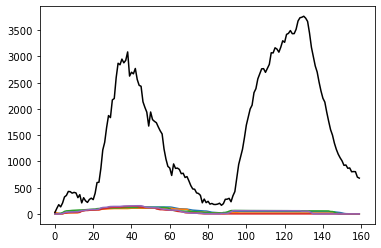

In [16]:
one = df_matrix[train_num_25:train_num_26,0]
two = df_matrix[train_num_25:train_num_26,1]
three = df_matrix[train_num_25:train_num_26,2]
four = df_matrix[train_num_25:train_num_26,3]
five = df_matrix[train_num_25:train_num_26,4]

plt.plot(one)
plt.plot(two)
plt.plot(three)
plt.plot(four)
plt.plot(five)
plt.plot(real,color = 'black')
plt.show()

In [17]:
from openpyxl import Workbook

write_wb = Workbook()
write_ws = write_wb.create_sheet("결과")

write_ws = write_wb.active
real= real.tolist()
# print(len(real))
for i in range(len(real)):
  write_ws.cell(i+1,1,real[i])
write_wb.save('결과200.xlsx')

In [18]:


optimizer = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(loss='mean_squared_error', optimizer='adam')
#early_stop = EarlyStopping(monitor='val_loss', patience=3)
#model_path = 'model'
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train_X, train_y, 
                                    epochs=50, 
                                    batch_size=32,
                                    # validation_data=(test_X, test_y), 
                                    )

NameError: name 'train_y' is not defined

In [ ]:
yhat = model.predict(test_X)


inv_yhat = df_matrix
a=0
for i in range(train_num_19+3,train_num_24):
  df_matrix[i][42]=yhat[a]
  a+=1

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[train_num_19+3:train_num_24,42:43]
print(inv_yhat)


In [ ]:
np.set_printoptions(suppress=True)

print(inv_yhat)
print(inv_yhat.shape)

In [ ]:

inv_y = scaler.inverse_transform(df_matrix)
inv_y = inv_y[train_num_19+3:train_num_24,42:43]


print(inv_y)
print(inv_y.shape)

In [ ]:
print(inv_yhat[0])

In [ ]:
plt.plot(inv_yhat)
plt.plot(inv_y)
plt.show()

In [ ]:
RMSE = mean_squared_error(inv_yhat,inv_y)**0.5
RMSE

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

plt.show()

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_y, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()